In [18]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns
import statsmodels.api
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

# Chemins d'accès aux données
repDataConsolidees = '../../dataConsolidees.gouv/'

# Liste des fichiers usagers disponibles
!pwd
!ls {repDataConsolidees}*  -lrt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


/Users/stephane/Documents/Professionnel/Formation/Certificats/Datascientest/4 - Projet AccidentsRoutiers/scripts/1 - ExplorationDonnees
ls: -lrt: No such file or directory
../../dataConsolidees.gouv/agg_accidents.csv
../../dataConsolidees.gouv/agg_usagers.csv
../../dataConsolidees.gouv/test_set.csv
../../dataConsolidees.gouv/train_set.csv
../../dataConsolidees.gouv/usagers.csv


## ETAPE 1 - CHARGEMENT DATASET TRAIN

In [2]:
# ETAPE 1 - Chgt des données 
train = pd.read_csv (repDataConsolidees + "train_set.csv", dtype={'user_actp' : str}, ) 
train.describe()
save_train = train.copy()                                     # On sauvegarde train (si besoin)

#train = train[train.user_gravite != -1]


In [3]:
# ETAPE 2 - Préparation d'un dataset équilibré
from imblearn.over_sampling import RandomOverSampler, SMOTE
import math
# Préparation 
train = save_train.copy()
train = train[train.user_gravite != -1]                            # Suppression des targets manquantes
y = train.user_gravite                                             # target à rééquilibrer
x = train.drop(['id_accident', 'id_vehicule', 'num_veh', 'user_actp'], axis = 1)                 # suppression des colonnes non numérique et/ou inutile
x = x.fillna(-1)                                                   # Suppression des NaN



In [4]:
# REEQUILIGRABE OVERSAMPLING : SMOTE
x_train_smote, y_smote = SMOTE().fit_resample(x, y)
x_train_smote.vehi_motor = train.vehi_motor.apply(lambda valeur : math.floor(valeur))
x_train_smote.carac_com = train.carac_com.apply(lambda valeur : math.floor(valeur))
x_train_smote.carac_dept = train.carac_dept.apply(lambda valeur : math.floor(valeur))
x_train_smote.vehi_senc = train.vehi_senc.apply(lambda valeur : math.floor(valeur))


In [5]:

# REEQUILIBRAGE OVERSAMPLING : RandomOverSampling
x_train_ro, y_train_ro  = RandomOverSampler().fit_resample(x, y)
x_train_ro.vehi_motor = train.vehi_motor.apply(lambda valeur : math.floor(valeur))
x_train_ro.carac_com = train.carac_com.apply(lambda valeur : math.floor(valeur))
x_train_ro.carac_dept = train.carac_dept.apply(lambda valeur : math.floor(valeur))
x_train_ro.vehi_senc = train.vehi_senc.apply(lambda valeur : math.floor(valeur))



In [6]:
# ETAPE 3 - Préparation des df_metropole et df_dom si besoin de cibler des analyses sur ces zones
# Focus sur accidents survenus en Métropole (ciblage sur les coordonnées GPS)
df_metropole = train[(train.carac_gps_long >= -5) & (train.carac_gps_long <= 10) & (train.carac_gps_lat >= 41) & (train.carac_gps_lat <= 51)]

# Focus sur accidents survenus hors Métropole (ciblage sur les coordonnées GPS)
df_dom = train[~((train.carac_gps_long >= -5) & (train.carac_gps_long <= 10) & (train.carac_gps_lat >= 41) & (train.carac_gps_lat <= 51))]

In [234]:
# Chargement du dernier fichier ...
test_stat = pd.read_csv(repDataConsolidees + "test_stat.csv")
# ... ou Préparation d'un dataframe vide
# test_stat = en charge de conserver les scores de V Cramer et les p-value de Chi2 pour les variables
# catégorielle ou (coef de corrélation et p value anova) pour les variables quantitatives
test_stat3 = pd.DataFrame(columns=['variable', 'categorielle', 'MV_class', 'pvalue', 'coef'])


def add_test_stat (df:pd.DataFrame, variable:str, categorielle:bool, pvalue:float, coef:float) :
    """ La fonction vérifie la présence dans le dataFrame test_stat de la variable 'variable' :
    Si variable déjà présente, mise à jour des valeurs de l'enregistrement existant
    Sinon création d'une nouvelle entrée

    p-value : résultat de chi2 si catégorielle, de anova si quantitative
    coef : indice de Cramer si catégorielle, coef de corrélation sinon
    """
    # Est ce que le nom de la variable se termine par MV : si oui, MV_class <--True et suppression du suffixe au nom de la variable
    MV_class = False
    if variable.endswith(('MV', 'MV2')) : 
        MV_class = True
        if variable.endswith('MV2'):
            variable = variable[:-3]         # Supprime 'MV2' (3 caractères)
         
        else :
            variable = variable[:-2]         # Supprime 'MV' (2 caractères)
        
    # Si hypothèse h0 non écartée --> on force le coef de corrélation (ou indice de cramer si catégorielle) à 0
    if pvalue>0.05 :
        coef = 0

    condition = (df['variable'] == variable) & (df['MV_class'] == MV_class)
    if df[condition].empty:
        # Ajout d'une nouvelle ligne
        df.loc[len(df)] = [variable, categorielle, MV_class, pvalue, coef]

    else :
        # Mise à jour de la valeur existante
        df.loc[condition, 'categorielle'] = categorielle
        df.loc[condition, 'pvalue'] = pvalue
        df.loc[condition, 'coef'] = coef
        


## ETAPE 2 - DECLARATION DES FONCTIONS UTILISEES LORS DE L'EXPLORATION DES DONNEES

In [7]:
def interquantile (df: pd.DataFrame, x: str, afficheDetail: bool = True, exclure_1: bool = True):
    """ Analyse des Outliers d'une colonne de df """
    # Retire les -1 (valeur NaN) pour certaines variables 
    if exclure_1 :
        df_column = df.loc[(df[x] != -1), x]
        
    else :
        df_column = df.loc[:, x]


    # Analyse des Outliers via IQR :
    Q1 = df_column.quantile(0.25)
    Q3 = df_column.quantile(0.75)
    IQR = Q3 - Q1
    inf = Q1 - 1.5 * IQR
    sup = Q3 + 1.5 * IQR

    print ("-> Q1=", Q1, "- Q3=", Q3, "- IQR=", IQR, "- Borne inf=", inf, "- Borne sup=", sup)
    
    if afficheDetail or df_column[(df_column <= inf)].count() > 0 :
        print ("-> Outlier(s) inférieur(s) - min=", df_column[(df_column < inf)].min(),
               "- max=", df_column[(df_column < inf)].max(),
               "- nb=", df_column[(df_column < inf)].count()
        )
        
    if afficheDetail :
        print (df_column[(df_column < inf)].sort_values().values)

    if afficheDetail or df_column[(df_column >= sup)].count() > 0 :
        print ("-> Outlier(s) supérieur(s) - min=", df_column[(df_column > sup)].min(),
               "- max=", df_column[(df_column > sup)].max(),
               "Outliers nb=", df_column[(df_column > sup)].count()
        )
        
    if afficheDetail :
        print (df_column[(df_column > sup)].sort_values().values)
    

In [8]:
def monboxplot (
    df: pd.DataFrame, 
    x: str=None, 
    y: str=None, 
    title: str=None, 
    viewOutliers: bool=True, 
    exclure_1: bool=True,
    code_to_xlabel: {}={}, 
    rotation_xlabel: int=0,
    colors: []=['green', 'yellow', 'orange', 'red'],
    horizontal: bool=False,
    axe:plt.Axes=None) -> ():
    """ Affiche une figure composée de 2 graphes (un boxplot et une ditribution de la variable) de 1 à n boxplots (si x et y définis) 
        Affiche l'analyse des Outliers via les intervales inter Quantile. 

        - df : DataFrame contenant les données à afficher
        - x (str) : variable à analyser
        - y (str) : OPTIONNEL - variable complémentaire (varaible de découpage)
        - title (str) : OPTIONNEL - Titre du graphe
        - viewOutliers (bool) : OPTIONNEL - Le détail des outliers sera affichée sous forme de liste (True).
        - exclure_1 (bool) : OPTIONNEL - Les valeurs -1 seront exclues du graphe (True)
        - code_to_xlabel (dict) : OPTIONNEL - Dictionnaire permettant d'afficher le libellés plutôt que les modalité de 'x'
        - rotation_xlabel (int) : OPTIONNEL - Applique une rotation aux libellés sur l'axe des x
        - horizontal (bool) : OPTIONNEL - Affichage horizontal (True) ou vertical par défaut
        - colors ([]) : OPTIONNEL - Palette de couleurs à utiliser
        - axe (plt.Axes) : OPTIONNEL - Affichage dans cet axe, création d'un nouveau sinon
        
        Returns :
        - figure
        - axes[]
        
    """
    fig = None
    if axe is None :
        fig, axe = plt.subplots(1, 1, figsize=(15, 5))
        
    if horizontal :
        sns.boxplot(x=y, y=x, data = df, ax = axe, palette=colors)

    else :
        sns.boxplot(x=x, y=y, data = df, ax = axe, palette=colors)
        
    axe.set_title (title, fontsize = 12);
    print ("Outliers=") 
    if y is not None :
        interquantile(df, y, viewOutliers, exclure_1)
        
    if code_to_xlabel is not None :
        xticks_labels = axe.get_xticklabels()
        labels = [label.get_text() for label in xticks_labels]
        new_xlabels = [code_to_xlabel[label] if label in code_to_xlabel else label for label in labels]
        axe.set_xticks(ticks = range(len(new_xlabels)), labels = new_xlabels, rotation=rotation_xlabel);

    return fig, axe 
    


In [9]:
def moncountplot (df: pd.DataFrame, 
                  x: str, 
                  hue: str=None, 
                  title: str=None, 
                  code_to_xlabel: {}={}, 
                  rotation_xlabel: int=0,
                  code_to_huelabel: {}={},
                  viewPercent: float=0.0,
                  axe:plt.Axes=None ) -> ():
    """ Affiche un Countplot personnalisé :
        - df : DataFrame contenant les données à afficher
        - x (str) : nom de la variable à afficher sur l'axe des abscisses 
        - hue (str) : OPTIONNEL - variable complémentaire (découpage graphe par cette variable) 
        - title (str) : OPTIONNEL - Titre à afficher
        - code_to_xlabel (dict) : OPTIONNEL - Libellés à privilégier pour les modalités de la variable 'x' (les modalités sinon)
        - rotation_xlabel (int) : OPTIONNEL - Angle de rotation des libellés de l'axe des absisses
        - code_to_huelabel (dict) : OPTIONNEL - Libellés à privilégierpour les modalités de la variable 'hue' (les modalités sinon)
        - viewPercent (float) : OPTIONNEL - seuil à partir duquel le % sera affiché sur le graphe pour chaque modalité (>100 pour ne pas afficher les %)
        - axe (plt.Axes) : OPTIONNEL - Affichage dans cet axe, création d'un nouveau sinon

        Return :
        - fig, axe : fig <-- None si utilisation de l'axe transmis en paramètre
    
    """
    fig = None
    if axe is None :
        fig, axe = plt.subplots(1, 1, figsize=(15, 5))
        
    # Passe les colonnes en str pour éviter un plantage sur startwith
    if hue is None :
        df_str = df[[x]].astype(str)  

    else :
        df_str = df[[x, hue]].astype(str)  
    
    sns.countplot(x=x, hue=hue, data=df_str, ax=axe)       # plutot que x=x pour forcer le type à str (sinon plantage startwith dans countplot

    # Calcul des % de chaque modalité 
    total = len(df_str[x])
    for p in axe.patches:
        percent = 100 * p.get_height() / total
        if viewPercent < percent :
            percentage = '{:.1f}%'.format(percent)
            X = p.get_x() + p.get_width() / 2 - 0.1
            Y = p.get_height() + 0.1
            axe.text(X, Y, percentage, ha = 'center')

    # Libellé axe des x
    xticks_labels = axe.get_xticklabels()
    labels = [label.get_text() for label in xticks_labels]
    new_xlabels = [code_to_xlabel[label] if label in code_to_xlabel else label for label in labels]
    axe.set_xticks(ticks = range(len(new_xlabels)), labels = new_xlabels, rotation=rotation_xlabel);
    axe.set_title(title, fontsize = 12)

    # Libellé légende (si hue est défini)
    if hue is not None:
        handles, labels = axe.get_legend_handles_labels()
        new_huelabels = [code_to_huelabel[label] if label in code_to_huelabel else label for label in labels]
        axe.legend(handles, new_huelabels)

    return fig, axe
   


In [10]:
def monhistplot (df: pd.DataFrame, 
                 x: str, 
                 y: str=None,
                 title: str=None, 
                 bins: int=50, 
                 viewPercent: float=0.0,
                 axe:axes._axes.Axes=None)-> ():
    """ Affiche un histplot personnalisé :
        - df : DataFrame contenant les données à afficher
        - x (str) : nom de la variable à afficher sur l'axe des abscisses 
        - y (str) : nom de la variable à afficher sur l'axe des ordonnés 
        - title (str) : Optionel - titre à afficher
        - bins (int) : nombre d'intervalles de regroupement par défaut 50
        - viewPercent (float) : seuil à partir duquel le % sera affiché sur le graphe pour chaque modalité (>100 pour ne pas afficher les %)
        - axe (matplotlib.axes._axes.Axes) : Optionel - Affichage dans cet axe, création d'un nouveau sinon

        Return :
        - fig, axe : fig <-- None si utilisation de l'axe transmis en paramètre
    
    """
    fig = None
    if axe is None :
        fig, axe = plt.subplots(1, 1, figsize=(15, 5))
        
    sns.histplot(x=x, y=y, data = df, bins=bins, ax=axe)

    total = len(df[x])
    for p in axe.patches:
        percent = 100 * p.get_height() / total
        if viewPercent < percent:
            percentage = '{:.1f}%'.format(percent)
            X = p.get_x() + p.get_width() / 2 - 0.1
            Y = p.get_height() + 0.1
            axe.text(X, Y, percentage, ha = 'center')
    
    axe.set_title(title, fontsize = 12)

    return fig, axe


In [134]:
# Fonction d'analyse d'une variable catégorielle
def analyse_variable_categorielle (df: pd.DataFrame, 
                                   x: str, 
                                   cible: str='user_gravite', 
                                   modalite_cible: any=3, 
                                   liste_taux: []=np.arange(0.0, 5.0, 0.1),
                                   valna: any=None, 
                                   # attributs pour la gestion du graphe de distribution (countplot)
                                   title: str=None,
                                   code_to_xlabel: {}={'0' : 'Indemne', '1' : 'Blessé léger', '2' : 'Blessé grave', '3' : 'Tué'}, 
                                   code_to_huelabel: {}=None,
                                   rotation_xlabel: int=0,
                                   viewPercent: float=0.25,
                                   axe: plt.Axes=None,
                                   limiteModalite: int=999) :
    """ Fonction permettant de faire une analyse rapide de la répartition de chaque modalité d'une variable ainsi que de ses Missing Values.

        Des tests statistiques permettent de définir le niveau de corrélation de cette variable avec la varible cible et d'identifier
        s'il y  a un intérêt de privilégier à cette variable :
           - un regroupement binaire (le taux de regroupement sera recherché afin de maximiser le V Cramer) : (cf.regroupement_binaire_variable_categorielle())
           - un OneHotEncoding
           
        ARGS :   
        - df (DataFrame) : Encsemble de données à analyser
        - x (str) : nom de la variable catégorielle à analyser
        - cible (str) : variable cible pour affichage Tableau de contingence
        - modalite_cible (any) = OPTIONNEL - modalité de la variable cible  privilégier (par défaut : 3=Tué)
        - liste_taux (float) : OPTIONNEL - % de répartition à atteindre par la modalité pour être regroupé en modalité 1 sinon modalité 0
        - valna (any) : OPTIONNEL - Catégorie à considérer comme valeurs manquantes (en complément des nan)
        - title (str) : OPTIONNEL - Titre du graphe
        - code_to_xlabel ({}) : OPTIONNEL - Dictionnaire modalité --> libellé (si fourni, les countplot sont affichés)
        - code_to_huelabel ({}) : OPTIONNEL - Dictionnaire modalité --> libellé pour la variable à analyser (x)
        - rotation_xlabel (int) : OPTIONNEL - Angle de rotation des libellés de l'axe des absisses
        - viewPercent (float) : OPTIONNEL - seuil à partir duquel le % sera affiché sur le graphe pour chaque modalité (>100 pour ne pas afficher les %)
        - axe (plt.Axes) : OPTIONNEL - Affichage dans cet axe, création d'un nouveau sinon
        - limiteModalite (int) : OPTIONNEL - Affichage des 'limiteModalite' premières Modalités les plus utilisées

        RETURN : best_regroupement si calculé, df[x] sinon
    """
    print()
    nb_na = df[x].isna().sum()
    if valna is not None :
        nb_na += df[(df[x] == valna)][x].count()

    # Répartition des différentes modalités
    pourcentage = round(nb_na / len(df), 2) * 100
    print(f"Il y a {pourcentage}% ({nb_na}) de données manquantes (ou assimilées).", end="\n")
    nombre = df[x].nunique()
    print(f"Il y a {nombre} modalités.", end="\n\n")
    print(df[x].value_counts(normalize=True, dropna=False).head(limiteModalite), end="\n\n")

    if cible is not None :
        # Test Statistique du chi2
        ctnorm = pd.crosstab(df[x], df[cible], normalize='index')
        ct = pd.crosstab(df[x], df[cible])
        chi2, p_value_noRgmt, dof, expected = chi2_contingency(ct)
        V_Cramer_noRgmt = np.sqrt(chi2/pd.crosstab(df[x], df[cible]).values.sum())
        
        print("Test Statistique du chi2 (sans regroupement) : p-value=%.3f" % p_value_noRgmt, "; V de Cramer=%.5f" % V_Cramer_noRgmt, end="\n\n")
        print ("Tableau de contingence entre la variable et la variable cible (pour chi2): \n\n")
        print (ct.head(limiteModalite), end="\n\n")
        
        # Historise les résultats des tests Statistiques de la variable
        add_test_stat(df=test_stat, variable=x, categorielle=True, pvalue=p_value_noRgmt, coef=V_Cramer_noRgmt)
        
        # Ajout de 2 graphes : distribution d ela variable analysée à gauche, =f(cible) à droite
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        axe = axs[0]
        if title is None :
            title = f"Analyse de la variable {x}"
            
        if  (code_to_huelabel is not None and len(code_to_huelabel)>0) :
            # Affichage d'un countPlot de la variable
            moncountplot(df, 
                         x=x, 
                         title=title, 
                         code_to_xlabel=code_to_huelabel, 
                         rotation_xlabel=rotation_xlabel,
                         viewPercent=viewPercent,
                         axe=axe
                    )

            axe = axs[1]
            moncountplot(df, 
                         x=cible, 
                         hue=x, 
                         title="en fonction de la variable cible", 
                         code_to_xlabel=code_to_xlabel, 
                         code_to_huelabel=code_to_huelabel,
                         rotation_xlabel=rotation_xlabel,
                         viewPercent=viewPercent,
                         axe=axe
                    )
            plt.show();

        # 2 autres graphe type Boxplot
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        axe = axs[0]
        monboxplot(df,
                   x=x,
                   horizontal=True,
                   axe=axe
                  )
            
        axe = axs[1]
        monboxplot(df,
                   x=cible,
                   y=x,
                   axe=axe
                  )                       

        plt.show();
            
        # Recherche d'un regroupement binaire maximisant la corrélation avec la variable cible
        best_optimisation = 'BINAIRE'
        _modalite_1 = "Liste des catégories regroupée sur la modalité 1 : "
        _modalite_0 = f"Liste des modalités regroupées sur la modalité 0 :"
        print ("TENTATIVE OPTIMISATION PAR REGROUPEMENT BINAIRE")

        # Tableau de contingence normalisé
        print ("Tableau de contingence normalisé entre la variable et la variable cible : \n\n")
        print (ctnorm.head(limiteModalite), end="\n\n")
        best_regroupement, best_taux, best_p_value, best_V_Cramer, best_modalite_1, best_modalite_0, _ = regroupement_variable_categorielle (
                                                                      train, 
                                                                      x=x, 
                                                                      cible=cible, 
                                                                      modalite_cible=modalite_cible, 
                                                                      binary = True,                  # regroupement en catégorie binaire
                                                                      liste_taux=liste_taux, 
                                                                      code_to_xlabel=code_to_xlabel)
        
        # Recherche d'un regroupement non binaire maximisant la corrélation avec la variable cible
        print ("TENTATIVE OPTIMISATION PAR REGROUPEMENT NON BINAIRE")
        best_regroupement_Rgmt, best_taux_Rgmt, best_p_value_Rgmt, best_V_Cramer_Rgmt, best_modalite_1_Rgmt, best_modalite_0_Rgmt, new_modalite = regroupement_variable_categorielle (
                                                                    train, 
                                                                    x=x, 
                                                                    cible=cible, 
                                                                    modalite_cible=modalite_cible, 
                                                                    binary=False,
                                                                    liste_taux=liste_taux, 
                                                                    code_to_xlabel=code_to_xlabel)
        
        # Conservation du meilleur regroupement identifié
        if best_V_Cramer_Rgmt > best_V_Cramer :
            best_regroupement = best_regroupement_Rgmt
            best_taux = best_taux_Rgmt
            best_p_value = best_p_value_Rgmt
            best_V_Cramer = best_V_Cramer_Rgmt
            best_modalite_1 = best_modalite_1_Rgmt
            best_modalite_0 = best_modalite_0_Rgmt
            best_optimisation = 'NON BINAIRE'
            _modalite_1 = "Liste des catégories conservées : "
            _modalite_0 = f"Liste des modalités regroupées pour former la nouvelle modalité '{new_modalite}' :"

        print (f"\nOptimisation Corrélation variable '{x}':")
        if best_V_Cramer > V_Cramer_noRgmt :
            print (f"OPTIMISATION REGROUPEMENT {best_optimisation} : taux de regroupement optimal={best_taux} " \
                   f", best_p_value=%.3f" % best_p_value, " - best_V_Cramer=%.5f" % best_V_Cramer)
            print (_modalite_1, best_modalite_1)
            print (_modalite_0, best_modalite_0)

            return best_regroupement

    # La variable sans regroupement est plus performante...
    print (" ==>> AUCUNE OPTIMISATION IDENTIFIEE PAR TRANSFORMATION DU REGROUPEMENT DE LA VARIBLE.")
    
    return df[x]

In [12]:
# Permet de regouper en 2 modalités une variable catégorielle selon le taux de la modalité tué qui nous intéresse
def regroupement_variable_categorielle(df: pd.DataFrame, 
                                       x: str, 
                                       cible: str='user_gravite', 
                                       modalite_cible: any=3, 
                                       binary: bool=True,
                                       liste_taux: []=np.arange(2, 5, 0.1), 
                                       code_to_xlabel: {}={'0' : 'Indemne', '1' : 'Blessé léger', '2' : 'Blessé grave', '3' : 'Tué'}) :
    """ Fonction permettant de regrouper les catégories afin de ne conserver que certaines modalités. 2 Modes de regroupement possible :
        - df (DataFrame) : Encsemble de données à analyser
        - x (str) : nom de la variable catégorielle à analyser
        - cible (str) : OPTIONNAL - variable cible pour affichage Tableau de contingence
        - modalite_cible (any) = OPTIONNAL - modalité de la variable cible  privilégier (par défaut : 3=Tué)
        - binary (bool) = OPTIONNAL - True  --> catégorisation binaire : 2 modalités de regroupement seront réalisée : les modalités qui atteingnent le seuil et les autres
                                    - False --> Regroupement sous un nouveau code de toutes les modalités dont la proba d'atteindre la modalité cible de référence n'est pas atteinte
        - liste_taux (float) : OPTIONAL - % de répartition à atteindre par la modalité pour être regroupé en modalité 1 sinon modalité 0
        - code_to_xlabel ({}) : OPTIONNAL - Dictionnaire modalité --> libellé (si fourni, les countplot sont affichés)

        RETURN : np contenant le nouveau regroupement
    """
    print()
    ctnorm = pd.crosstab(df[x], df[cible], normalize='index')

    if binary == False :
        # Recherche de la modalité la plus grande pour la variable en cours d'analyse
        new_modalite = df[x].unique().max().astype(int) + 1
        print ("REGROUPEMENT NON BINAIRE : new_modalite=", new_modalite)
        
    else :
        new_modalite = None
        
    p_values = []
    V_Cramers = []
    best_V_Cramer = -1 
    best_p_value = -1
    best_taux = 0
    best_modalite_0 = []
    best_modalite_1 = []
    best_regroupement = []
    for taux in liste_taux :
        if binary :
            regroupement = np.where(df[x].isin(ctnorm[ctnorm[modalite_cible] >= taux/100].index.tolist()), 1, 0)

        else :
            regroupement = np.where(df[x].isin(ctnorm[ctnorm[modalite_cible] >= taux/100].index.tolist()), df[x], new_modalite)
            
        # Test statistique à partir de ce regroupement
        stat, p_value, _, _ = chi2_contingency(pd.crosstab(regroupement, df[cible]))
        V_Cramer = np.sqrt(stat/pd.crosstab(regroupement, df[cible]).values.sum())
        
        #print("TAUX=", taux, " - Test Statistique du chi2 : p-value=%.3f" % p_value, " ; V de Cramer=%.5f" %V_Cramer)
        
        if p_value > 0.05 :
            p_values.append(0.05)
            V_Cramers.append(0)
        
        else :
            p_values.append(p_value)
            V_Cramers.append(V_Cramer)

        if (p_value < 0.05) & (best_V_Cramer <= V_Cramer) :
            # Si égalité entre best_model et current_modele, on ne garde le best_modele que si binary == False afin de garder le plus grand taux 
            if (best_V_Cramer == V_Cramer) & binary == True :
                continue
            else :
                best_taux = taux
                best_p_value = p_value
                best_V_Cramer = V_Cramer
                best_modalite_0 = ctnorm[ctnorm[modalite_cible] < taux/100].index.tolist()
                best_modalite_1 = ctnorm[ctnorm[modalite_cible] >= taux/100].index.tolist()
                best_regroupement = regroupement
        
    print(f"Meilleurs résultats obtenu avec taux=", best_taux)
    if binary == False :
        print(f"Liste des modalités regroupées dans la nouvelle catégorie {new_modalite} :", best_modalite_0)

    else :
        print("Liste des modalités retenues en modalité de regroupement 1 :", best_modalite_1)
    
    print("Test Statistique du chi2 : p-value=%.3f" % best_p_value, " ; V de Cramer=%.5f" % best_V_Cramer, end="\n\n")

    # Résultat de la maximisation de la corrélation entre la variable et la variable cible
    plt.plot(np.array(liste_taux), V_Cramers, color='blue', label='V Cramer')
    plt.plot(np.array(liste_taux), p_values, color='orange', marker='o', label='p_value')

    plt.xlabel('Taux')
    plt.ylabel('p-value')
    plt.title('Comparaison des valeurs de p-value et de V Cramer pour différents taux de regroupement')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show();

    if best_V_Cramer == -1 :
        best_regroupement = df[x]
        
    return best_regroupement, best_taux, best_p_value, best_V_Cramer, best_modalite_1, best_modalite_0, new_modalite
                                       

In [108]:
# Fonction d'analyse d'une variable catégorielle binaire
def analyse_variable_binaire(df: pd.DataFrame, x: str, cible: str=None, valna: any=None, code_to_xlabel: {}=None) :
    """ Fonction permettant de faire une analyse rapide de la répartition de chaque modalité ainsi que des Missing Values
        - df (DataFrame) : Encsemble de données à analyser
        - x (str) : nom de la variable catégorielle à analyser
        - cible (str) : OPTIONAL - variable cible pour affichage Tableau de contingence
        - valna (any) : OPTIONAL - Catégorie à considérer comme valeurs manquantes (en complément des nan)
        - code_to_xlabel ({}) : OPTIONAL - Dictionnaire modalité --> libellé (si fourni, les countplot sont affichés)
    """
    print()
    nb_na = df[x].isna().sum()
    if valna is not None :
        nb_na += df[(df[x] == valna)][x].count()
    
    # Répartition des différentes modalités
    pourcentage = round(nb_na / len(df), 3) * 100
    print(f"Il y a {pourcentage}% de données manquantes ou assimilées ({nb_na}).", end="\n\n")
    nombre = df[x].nunique()
    print(f"Répartition de la variable :", end="\n\n")
    print(df[x].value_counts(normalize=True, dropna=False), end="\n\n")

    # Graphe de répartition de la variable
    if code_to_xlabel :
        moncountplot(df, 
                     x, 
                     title=f"Répartition de la variable '{x}'", 
                     code_to_xlabel=code_to_xlabel, 
                    )
    
    # Tableau de contingence avec la variable cible 
    if cible is not None :
        # Test Statistique du chi2
        ctnorm = pd.crosstab(df[x], df[cible], normalize='index')
        ct = pd.crosstab(df[x], df[cible])
        chi2, p_value, dof, expected = chi2_contingency(ct)
        V_Cramer = np.sqrt(chi2/pd.crosstab(df[cible], df[x]).values.sum())
        
        print("Test Statistique du chi2 : p-value=%.3F" % p_value, " ; V de Cramer=", V_Cramer, end="\n\n")

        # Conserve le résultat dans test_stat
        add_test_stat(test_stat, x, categorielle=True, pvalue=p_value, coef=V_Cramer)
        
        print ("Tableau de contingence entre la variable et la variable cible (pour chi2): \n\n")
        print (ct, end="\n\n")
        
        print ("Tableau de contingence normalisé entre la variable et la variable cible : \n\n")
        print (ctnorm, end="\n\n")
        
        
        if code_to_xlabel :
            code_to_huelabel = {'0' : 'Indemne', '1' : 'Blessé léger', '2' : 'Blessé grave', '3' : 'Tué'}
            moncountplot(df, 
                     x, 
                     cible, 
                     f"Analyse variable '{x}'", 
                     code_to_xlabel=code_to_xlabel, 
                     code_to_huelabel=code_to_huelabel
                    )
    
        

In [181]:
# Fonction d'analyse d'une variable quantitative
def analyse_variable_quantitative (df: pd.DataFrame, 
                                   x: str, 
                                   cible: str=None, 
                                   valna: any=None, 
                                   code_to_xlabel: {}=None, 
                                   rotation_xlabel: int=0,
                                   viewPercent: float=0.25,
                                   viewOutliers: bool=True,
                                   bins:int=10) :
    """ Fonction permettant de faire une analyse rapide de la distribution de chaque modalité ainsi que des Missing Values
        
        Affichage possible de boxplot
        
        - df (DataFrame) : Encsemble de données à analyser
        - x (str) : nom de la variable catégorielle à analyser
        - cible (str) : OPTIONNEL - variable cible pour affichage Tableau de contingence
        - valna (any) : OPTIONNEL - Catégorie à considérer comme valeurs manquantes (en complément des nan)
        - code_to_xlabel ({}) : OPTIONNEL - Dictionnaire modalités cible --> libellé (si fourni, les boxplots sont affichés)
        - rotation_xlabel (int) : OPTIONNEL - Orientation label axe des x
        - viewPercent (float) : OPTIONNEL - Ajout du % sur les graphes type Histplot si valeur Histo > viewPercent 
        - viewOutliers (bool) : OPTIONNEL - Détail des outliers affiché O/N sur BoxPlot
        - bins (int) : OPTIONNEL - Nombre d'histo
        
    """
    print()
    nb_na = df[x].isna().sum()
    nb_valna = 0
    if valna is not None :
        nb_valna = df[(df[x] == valna)][x].count()
        
    nb_na += nb_valna
    
    # Répartition des différentes modalités
    pourcentage = round(nb_na / len(df), 3) * 100
    print(f"Il y a {pourcentage}% ({nb_na}) de données manquantes (ou assimilées).", end="\n\n")
    if nb_valna > 0 :
        print("Statistiques de la variable (hors valeur nan): ", end="\n\n")
        print(df[(df[x] != valna)][x].describe(), end="\n\n")
        df_without_valna = df[df[x] != valna]
        
    else :
        print("Statistiques de la variable : ", end="\n\n")
        print(df[x].describe(), end="\n\n")

    if code_to_xlabel is not None :
        # Affichage de la distribution de la variable sous forme d'histogramme    
        fig, axs = monhistplot(df, x=x, title=f"Distribution variable {x}", bins = bins, viewPercent=viewPercent)
        
        if nb_valna > 0 :
            fig, axs = monhistplot(df_without_valna, x=x, title=f"Distribution variable {x} (sans valna={valna})", bins = bins, viewPercent=viewPercent)

        plt.show();
        
    if cible is not None :
        # Analyse statistique - test Anova (entre année de naissance (quantitative) de l'usager et la variable cible ='user_gravite' (catégorielle)
        result = statsmodels.formula.api.ols(f'{cible} ~ {x}', data=df).fit()
        table = statsmodels.api.stats.anova_lm(result)
        if nb_valna > 0 :
            print ("\nTest statistique ANOVA (avec valna)- PR(>F)=%.5f" %table.iloc[0, 4], end="\n\n")
            result = statsmodels.formula.api.ols(f'{cible} ~ {x}', data=df_without_valna).fit()
            table = statsmodels.api.stats.anova_lm(result)
            print ("\nTest statistique ANOVA (sans valna)- PR(>F)=%.5f" %table.iloc[0, 4], end="\n\n")
            
        else :
            print ("\nTest statistique ANOVA - PR(>F)=%.5f" %table.iloc[0, 4], end="\n\n")
            
        display(table)

        # Matrice de corrélation entre variable et variable cible
        matrice = df[[x, cible]].corr()
        print ("Matrice de corrélation : ", "(coef=%.3f)" %matrice[x][cible])
        display(matrice)

        # historisation des résultats de tests statistique
        add_test_stat(df=test_stat, variable=x, categorielle=False, pvalue=table.iloc[0, 4], coef=matrice[x][cible])
        
        # Affichage de la distribution de la variable sous forme de BoxPloten fonction de la variable cible
        if nb_valna > 0 :
            monboxplot(df_without_valna, x= cible, y=x, title=f"Distribution de la variable (sans les NaN)=f({cible})", code_to_xlabel=code_to_xlabel, rotation_xlabel=rotation_xlabel, viewOutliers=viewOutliers)

        else :
            monboxplot(df, x= cible, y=x, title=f"Distribution de la variable =f({cible})", code_to_xlabel=code_to_xlabel, rotation_xlabel=rotation_xlabel, viewOutliers=viewOutliers)
            
        plt.show();
        

In [15]:
# Fonction d'analyse des missing value pour une variable définie
def analyse_valeurs_manquantes (df: pd.DataFrame, x: str, variables_continues: []=[], variables_categorielles : []=[]) :
    """ Fonction qui permet d'analyser la tendance d'une variables par rapport à un périmètre de variables continues 
        d'une part et catégorielles d'autre part afin d'identifier des tendances

        L'objectif étant d'identifier des règles de remplacement des missing value peut être plus pertinente qu'un remplacement par défaut

        - df (DataFrame) : Ensemble des données à analyser
        - x (str) : nom de la variable à analyser
        - variables_continues ([]) : Liste des variables continues à analyser
        - variables_categorielles ([]) : Liste des variables catégorielles à analyser
        
    """

    # Variables continues
    liste_variables = variables_continues
    liste_variables.append(x)
    print("Liste=", liste_variables) 
    print (f"La valeur médiane selon {x} : ", end="\n\n")
    print (df[liste_variables].groupby(x).median(), end="\n\n")

    # Variables catégorielles
    liste_variables = variables_categorielles
    liste_variables.append(x)
    print (f"Le mode selon {x} : ", end="\n\n")
    print(df[liste_variables].groupby(x).apply(pd.DataFrame.mode).set_index(x), end="\n\n")

    # Vérification des proportions
    for variable in variables_categorielles :
        print("Proportion : ", end="\n\n")
        print(df.groupby(variable)[x].value_counts(normalize=True), end="\n\n")
        

## ETAPE 3 - EXPLORATION DES DONNEES - ANALYSE DE LA <span style="color:red">VARIABLE CIBLE</span>

- Problème de classification supervisé déséquilibré

<u>ANALYSE DETAILLEE DE LA VARIABLE CIBLE <span style="color:red">__'USER_GRAVITE'__ : </span></u>

Gravité de l'accident : donnée catégorielle (4 modalités ordonnées de 0 à 3)

&#8195;

user_gravite
0    114001
1    108339
2     41182
3      7195
Name: count, dtype: int64

(<Figure size 1500x500 with 1 Axes>,
 <Axes: title={'center': "Variable cible 'user_gravite'"}, xlabel='user_gravite', ylabel='count'>)

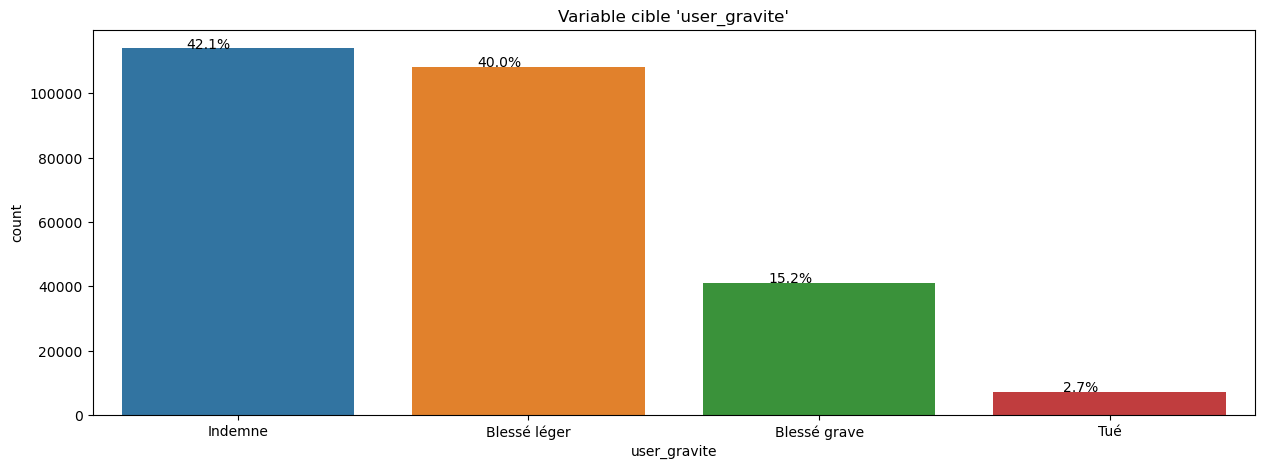

In [16]:
# 1. Analyse variable cible
display(train['user_gravite'].value_counts().sort_index())

# Countplot
code_to_xlabel = {'0' : 'Indemne', '1' : 'Blessé léger', '2' : 'Blessé grave', '3' : 'Tué', '-1' : 'Non définie'}
moncountplot (df=train,
              x='user_gravite', 
              title="Variable cible 'user_gravite'", 
              code_to_xlabel=code_to_xlabel, 
              viewPercent=0.0)


In [17]:
# Variable cible --> Pour la suite de l'exploration des données ==>  Suppression des missings values
train = train[(train.user_gravite != -1)]


<u>CONCLUSION <span style="color:red">__'USER_GRAVITE'__</span> :</u>
- Quelques missing values (215 enregistrements) qu'ils faudra supprimer --> pipeline_target()
- Les 2 premières classes (les moins intéressantes) représentent à elles seules 82%
- Les 2 autres représentent moins de 18% dont 2,7% pour la classe la plus intéressante à prédire

__==> Nous sommes face à un problème de catégorisation supervisé déséquilibrée__

&#8195;

## ETAPE 4 - EXPLORATION DES DONNEES - <span style="color:red">DIAGRAMME DE PAIRES</span>
___/!\ TEMPS DE TRAITEMENT TRES LONG /!\\___
- Temps d'exécution très long et devant être découpé en plusieurs lancement (trop de variables)
- Lecture difficile des résultats obtenus ==> Comment exploiter ce genre de graphe ?


### &#8195;
<u> <span style="color:blue">ETAPE 4.1 - DIAGRAMME DE PAIRES - <span style="color:red">FICHIER 'USER'</span></span></u>



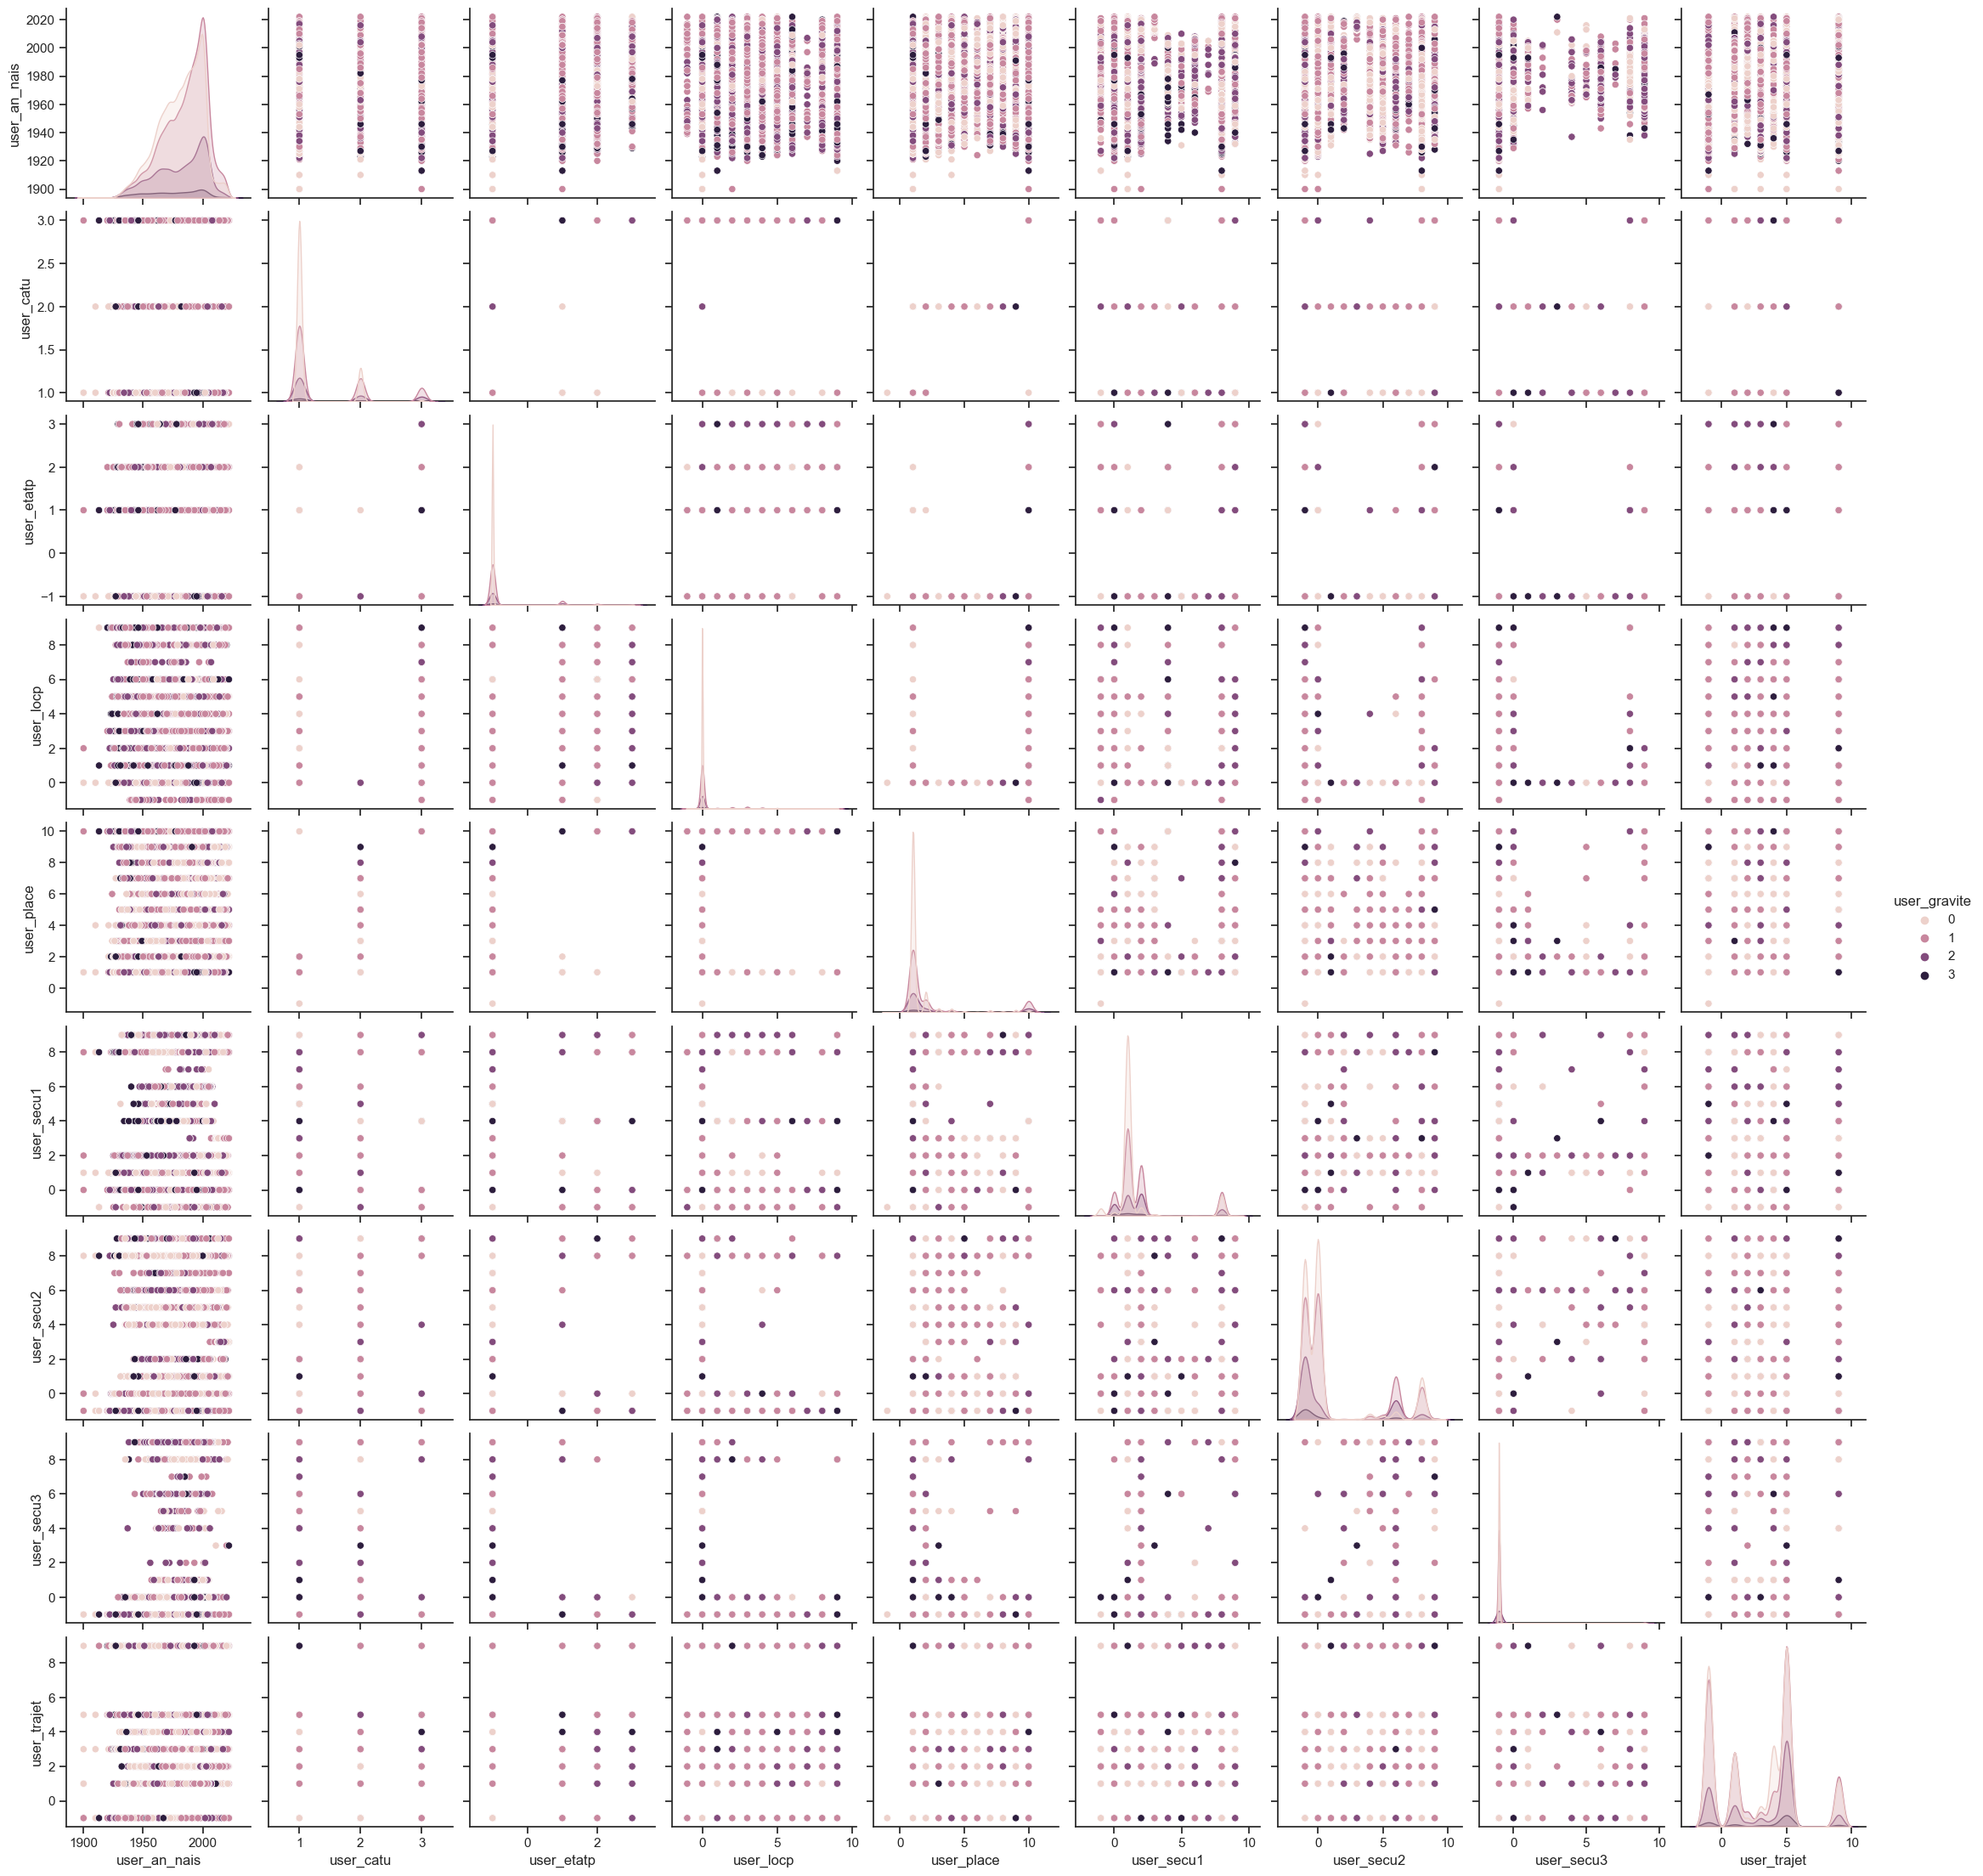

In [227]:
sns.set(style='ticks', color_codes=True)
colonnes = ['user_an_nais', 'user_catu', 'user_actp', 'user_etatp', 'user_locp', 'user_place', 'user_secu1', 'user_secu2', 'user_secu3', 'user_trajet', 'user_gravite']
sns.pairplot(train[colonnes], hue="user_gravite")

In [ ]:
sns.set(style='ticks', color_codes=True)
#sns.pairplot(train, hue="user_gravite")

### &#8195;
<u> <span style="color:blue">ETAPE 4.2 - DIAGRAMME DE PAIRES - <span style="color:red">FICHIER 'VEHI'</span></span></u>



In [ ]:
# à faire

### &#8195;
<u> <span style="color:blue">ETAPE 4.3 - DIAGRAMME DE PAIRES - <span style="color:red">FICHIER 'LIEU'</span></span></u>



In [3]:
# à faire

### &#8195;
<u> <span style="color:blue">ETAPE 4.4 - DIAGRAMME DE PAIRES - <span style="color:red">FICHIER 'CARAC'</span></span></u>



In [4]:
# à faire

<u>CONCLUSION :</u>

  __==> Cette représentation nous permet de faire ressortir des tendances que nous allons analyser plus en détail maintenant__
  

## ETAPE 5 - FEATURE ENGINEERING SUR DONNEES <span style="color:red">'DATES'</span>
- Reconstitution d'une variable au format date à partir des jour mois et année disponible
- Cette variable semble avoir une corrélation plus importante avec la variable cible que chacune des 3 utilisées pour la contruire
- l'information heure semble également intéressant à conserver (Cramer=0.194)


### &#8195;
<u> <span style="color:blue">ETAPE 5.1 - FEATURE ENGINEERING SUR <span style="color:red">'DATE_ACCIDENT'</span></span></u>


In [19]:
# Doit tourner sur le df non rééquilibré
train = save_train.copy()

In [118]:
# Transformation de la date an + mois + jour --> date + jour de semaine + we O/N
def composer_date(row):
    jour_str = str(int(row['carac_jour'])).zfill(2)
    mois_str = str(int(row['carac_mois'])).zfill(2)
    année_str = str(int(row['carac_an']))
    
    return pd.to_datetime(f"{jour_str}/{mois_str}/{année_str}", format="%d/%m/%Y")

def composer_date_int(row):
    jour_str = str(int(row['carac_jour'])).zfill(2)
    mois_str = str(int(row['carac_mois'])).zfill(2)
    année_str = str(int(row['carac_an']))
    
    return int(f"{jour_str}{mois_str}{année_str}")
    
# Variable '_date_accident' format datetime()
train['_date_accident'] = train.apply(composer_date, axis=1)

# Variable 'date_accident' format numérique
train['_date_accident_int'] = train.apply(composer_date_int, axis=1)

# Variable '_jour_semaine' (no du jour dans la semaine 0=lundi, ..., 6=dimanche
train['_jour_semaine'] = train._date_accident.apply(lambda date : date.weekday())

# Variable '_is_we' : indicateur WE 0/1
train['_is_we'] = train._jour_semaine.apply (lambda jour : 1 if jour>=5 else 0)

# Contrôle
train.head()


,id_accident,id_vehicule,num_veh,carac_an,carac_mois,carac_jour,carac_hrmn,carac_agg,carac_atm,carac_col,carac_com,carac_dept,carac_gps_lat,carac_gps_long,carac_int,carac_lum,lieu_catr,lieu_circ,lieu_infra,lieu_larrout,lieu_lartpc,lieu_nbv,lieu_plan,lieu_prof,lieu_situ,lieu_surf,lieu_vma,lieu_vosp,vehi_catv,vehi_choc,vehi_manv,vehi_motor,vehi_obs,vehi_obsm,vehi_occutc,vehi_senc,user_an_nais,user_catu,user_actp,user_etatp,user_locp,user_place,user_secu1,user_secu2,user_secu3,user_sexe,user_trajet,user_gravite,agg_catv_perso,agg_is_conducteur_vehicule,agg_is_conductrice_vehicule,agg_nb_pieton_vehicule,agg_nb_passager_vehicule,agg_nb_indemne_vehicule,agg_nb_blesse_leger_vehicule,agg_nb_blesse_grave_vehicule,agg_nb_tue_vehicule,agg_nb_total_vehicule,agg_nb_total_velo,agg_nb_total_vsp,agg_nb_total_moto,agg_nb_total_vl,agg_nb_total_pl,agg_nb_total_va,agg_nb_total_conducteur,agg_nb_total_conductrice,agg_nb_total_pieton,agg_nb_total_passager,_date_accident,_date_accident_int,_jour_semaine,_is_we,user_sexeMV
0,202000000002,154742273,A01,2020,3,7,835,2,7,6,657.0,91,48.69000,2.41000,9,2,4,2,0,-1.0,0.0,2,3,1,1,1,50.0,0,7,2,26,1.0,0,1,0,3.0,1997.0,1,0,0,0,1,8,0,-1,1,1,0,4,1,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0,2020-03-07,7032020,5,1,1
1,202000000002,154742273,A01,2020,3,7,835,2,7,6,657.0,91,48.69000,2.41000,9,2,4,2,0,-1.0,0.0,2,3,1,1,1,50.0,0,7,2,26,1.0,0,1,0,3.0,1967.0,3,3,1,3,10,0,-1,-1,1,5,1,4,1,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0,2020-03-07,7032020,5,1,1
2,202000000003,154742271,B01,2020,3,7,1330,2,1,3,174.0,91,48.61067,2.47582,2,1,4,-1,0,-1.0,0.0,2,1,1,1,1,50.0,0,7,1,1,1.0,0,2,0,1.0,1985.0,1,0,0,0,1,1,0,-1,1,-1,0,4,1,0,0,1,1,0,1,0,2,0,0,0,2,0,0,2,0,0,1,2020-03-07,7032020,5,1,1
3,202000000003,154742271,B01,2020,3,7,1330,2,1,3,174.0,91,48.61067,2.47582,2,1,4,-1,0,-1.0,0.0,2,1,1,1,1,50.0,0,7,1,1,1.0,0,2,0,1.0,2014.0,2,0,0,0,4,8,0,-1,1,-1,2,4,1,0,0,1,1,0,1,0,2,0,0,0,2,0,0,2,0,0,1,2020-03-07,7032020,5,1,1
4,202000000003,154742272,A01,2020,3,7,1330,2,1,3,174.0,91,48.61067,2.47582,2,1,4,-1,0,-1.0,0.0,2,1,1,1,1,50.0,0,7,8,1,0.0,0,2,0,1.0,1963.0,1,0,0,0,1,1,0,-1,1,-1,0,4,1,0,0,0,1,0,0,0,2,0,0,0,2,0,0,2,0,0,1,2020-03-07,7032020,5,1,1


In [128]:
# Test Statistique sur chacune de ces variables dates/Time
dates = ['carac_an', 'carac_mois', 'carac_jour', 'carac_hrmn', '_date_accident', '_date_accident_int', '_jour_semaine', '_is_we']

for variable in dates :
    stat,p = chi2_contingency(pd.crosstab(train['user_gravite'], train[variable]))[:2]
    V_Cramer = np.sqrt(stat/pd.crosstab(train["user_gravite"], train[variable]).values.sum())

    print()
    print(variable, ":\n V de Cramer=%.5f" %V_Cramer, " ; P-value= %.3f" %p)

    # Conserve le résultat dans test_stat
    add_test_stat(test_stat, variable=variable, categorielle=True, pvalue=p, coef=V_Cramer)
    


carac_an :
 V de Cramer=0.01861  ; P-value= 0.000

carac_mois :
 V de Cramer=0.03595  ; P-value= 0.000

carac_jour :
 V de Cramer=0.02155  ; P-value= 0.008

carac_hrmn :
 V de Cramer=0.16822  ; P-value= 0.000

_date_accident :
 V de Cramer=0.13522  ; P-value= 0.000

_date_accident_int :
 V de Cramer=0.13522  ; P-value= 0.000

_jour_semaine :
 V de Cramer=0.05026  ; P-value= 0.000

_is_we :
 V de Cramer=0.04688  ; P-value= 0.000


In [129]:
test_stat

,variable,categorielle,pvalue,coef
0,carac_an,True,4.992114e-18,0.018611
1,carac_mois,True,1.307331e-54,0.035950
2,carac_jour,True,7.660670e-03,0.021553
3,carac_hrmn,True,7.451895e-195,0.168218
4,_date_accident,True,1.757866e-71,0.135216
5,_date_accident_int,True,1.757866e-71,0.135216
6,_jour_semaine,True,1.575871e-133,0.050257
7,_is_we,True,1.277684e-128,0.046878


<u>CONCLUSION <span style="color:red">__'DATE_ACCIDENT'__</span> :</u>
1. Le test de Chi2 confirme la corrélation de toutes ces variables avec la variable cible.
2. Le test de Cramer semble montrer une corrélation plus forte de la variable _date_accident (Cramer=0.15211)
3. La variable carac_hrmn semble également avoir un intérêt particulier (Cramer=0.19404)

&#8195;

<u>TRANSFORMATIONS A PREVOIR <span style="color:red">__'DATE_ACCIDENT'__</span> :</u>

  __==> RECONSTITUER 'DATE_ACCIDENT' = F('CARAC_AN', 'CARAC_MOIS', 'CARAC_JOUR') au format int et non datetime__

  __==> SUPPRIMER LES COLONNES 'CARAC_AN', 'CARAC_MOIS', 'CARAC_JOUR'__

&#8195;

### &#8195;
<u> <span style="color:blue">ETAPE 5.2 - FEATURE ENGINEERING SUR <span style="color:red">'HOLIDAYS'</span></span></u>


In [2]:
# A ajouter...

## ETAPE 6 - ANALYSE DES <span style="color:red">VARIABLES CATEGORIELLES</span>
- Analyse légèrement différente entre catégorielle binaire et non binaire : pour les non binaires, recherche si un regroupement de modalités apporterait une meilleure adhérence avec la variable cible.
- Utilisation de l'indice de Cramer pour mesurer cette adhérence : pas sûr que cette méthode ait du sens.
- Aucun regroupement identifié.

- Pour identifier la méthode de remplacement des missing values : idem, utilisation de l'indice de Cramer. Pertinent ?
  
- Très faible corrélation constatée sur l'ensemble des variables avec la variable cible.
- Relance de l'analyse sur un dataset rééquilibré ==> Les tests statistiques évoluent.
- ...mais comment interpréter cette évolution (surtout si l'indice diminue aprés rééquilibrage)

- Comment définir post analyse de chacune des variables celles à privilégier ?

- Comment identifier s'il y a un intérêt à One Hot Encoder ces variables : faut-il réserver cette transformation pour les variables avec beaucoup de modalité
    


### &#8195;
<u> <span style="color:blue">ETAPE 6.0 - Initialisation (BINAIRES / NON BINAIRES)</span></u>

In [1148]:
# Nombre de modalités pour les variables catégorielles non binaires
train[['carac_agg', 'carac_atm', 'carac_col',  'carac_com', 'carac_dept', 'carac_int', 'carac_lum', 'lieu_catr', 'lieu_circ', 
       'lieu_infra', 'lieu_nbv', 'lieu_plan', 'lieu_prof', 'lieu_situ', 'lieu_surf', 'lieu_vosp', 'vehi_catv', 'vehi_choc', 
       'vehi_manv', 'vehi_motor', 'vehi_obs', 'vehi_obsm', 'vehi_occutc', 'vehi_senc', 'user_catu', 'user_actp', 'user_etatp', 
       'user_locp', 'user_place', 'user_secu1', 'user_secu2', 'user_secu3', 'user_trajet', 'agg_catv_perso']].nunique()



In [33]:
# Exploration de données Choix du dataset : initial ou rééquilibré
train = save_train.copy()                # initial
#train = x_train_smote.copy()              # Rééquilibré SMOTE
#train = x_train_ro.copy()                # Rééquilibré OverRandom

train = train[(train.user_gravite != -1)]
train.user_gravite.value_counts()


user_gravite
0    114001
1    108339
2     41182
3      7195
Name: count, dtype: int64

### &#8195;
<u> <span style="color:blue">ETAPE 6.1 - ANALYSE DES VARIABLES CATEGORIELLES BINAIRES</span></u>
- <span style="color:red">__'CARAC_AGG'__</span> :</u> : Agglomaration O/N - Donnée catégorielle binaire
- <span style="color:red">__'USER_SEXE'__</span> :</u> : Genre de l'usager
- <span style="color:red">__'AGG_IS_CONDUCTEUR_VEHICULE'__</span> :</u> : l'usager est conducteur du véhicule
- <span style="color:red">__'AGG_IS_CONDUCTRICE_VEHICULE'__</span> :</u> : l'usager est conductrice du véhicule



Il y a 0.0% de données manquantes ou assimilées (0).

Répartition de la variable :

agg_is_conductrice_vehicule
0    0.746728
1    0.253272
Name: proportion, dtype: float64

Test Statistique du chi2 : p-value=0.000  ; V de Cramer= 0.06906759350648167

Tableau de contingence entre la variable et la variable cible (pour chi2): 


user_gravite                     0      1      2     3
agg_is_conductrice_vehicule                           
0                            85321  77981  32804  6046
1                            28680  30358   8378  1149

Tableau de contingence normalisé entre la variable et la variable cible : 


user_gravite                        0         1         2         3
agg_is_conductrice_vehicule                                        
0                            0.422064  0.385754  0.162274  0.029908
1                            0.418289  0.442762  0.122191  0.016758

Matrice de corrélation


,agg_is_conductrice_vehicule,user_sexe,user_gravite
agg_is_conductrice_vehicule,1.000000,0.63763,-0.034224
user_sexe,0.637630,1.00000,0.072460
user_gravite,-0.034224,0.07246,1.000000


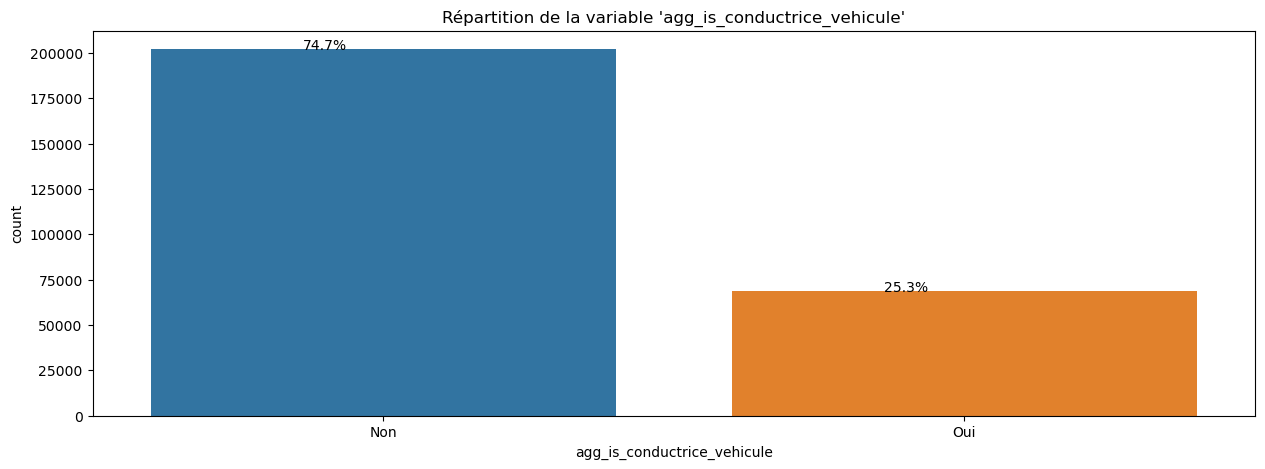

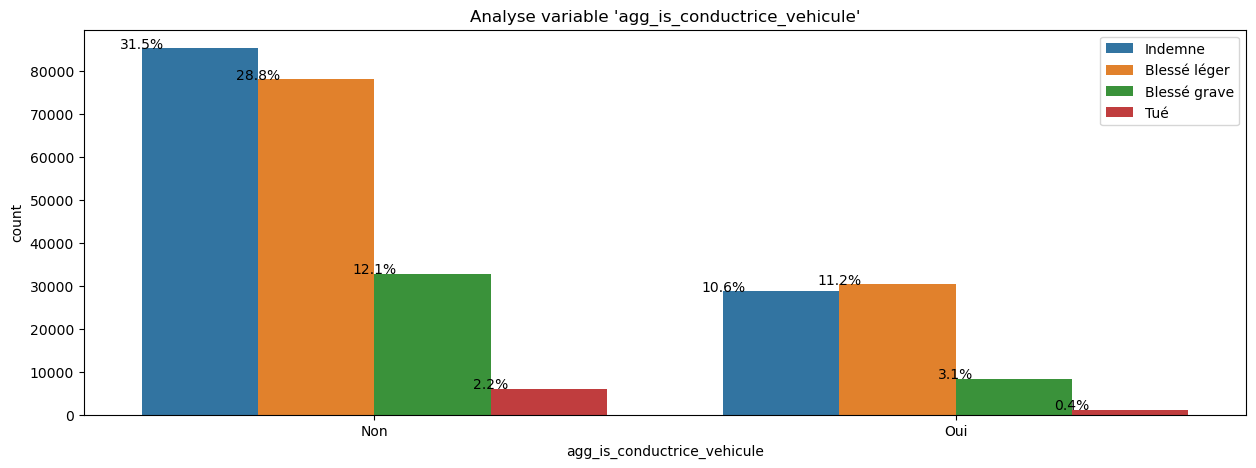

In [133]:
# ---------
# CARAC_AGG
# ---------
#analyse_variable_binaire(train, 'carac_agg', 'user_gravite', valna=-1, code_to_xlabel={'1': 'En agglo', '2': 'Hors agglo', '-1': 'NAN'})

# ---------
# USER_SEXE
# ---------
"""
analyse_variable_binaire(train, 'user_sexe', 'user_gravite', valna=-1, code_to_xlabel={'1': 'Homme', '2': 'Femme', '-1' : 'NAN'})

# USER_SEXE - Analyse des missing values (inutile car p_value Chi2 > 99%)
analyse_valeurs_manquantes(train, 
                           'user_sexe', 
                           variables_continues=['user_an_nais'], 
                           variables_categorielles=['user_gravite', 'user_catu', 'user_actp', 'user_etatp', 'user_locp', 'user_place', 'user_secu1', 'user_secu2', 'user_secu3', 'user_trajet'])
# ==> Aucune tendance ne ressort ==> on testera le remplacement des missing values par la modalité la plus fréquente

# Remplacement des missing values avec la modalité la plus fréquente
train['user_sexeMV'] = train.user_sexe.fillna(train.user_sexe.mode()[0])                       # valeur NaN si existante
train['user_sexeMV'] = train.user_sexe.replace(-1, train.user_sexe.mode()[0]).astype(int)  
analyse_variable_binaire(train, 'user_sexeMV', 'user_gravite', valna=-1, code_to_xlabel={'1': 'Homme', '2': 'Femme', '-1' : 'NAN'})
"""

# --------------------------
# AGG_IS_CONDUCTEUR_VEHICULE
# --------------------------
# Variable catégorielle binaire
#analyse_variable_binaire(train, 'agg_is_conducteur_vehicule', 'user_gravite', valna=-1, code_to_xlabel={'0': 'Non', '1': 'Oui', '-1' : 'NAN'})

# ---------------------------
# AGG_IS_CONDUCTRICE_VEHICULE
# ---------------------------
# Variable catégorielle binaire
#analyse_variable_binaire(train, 'agg_is_conductrice_vehicule', 'user_gravite', valna=-1, code_to_xlabel={'0': 'Non', '1': 'Oui', '-1' : 'NAN'})

print("Matrice de corrélation")
train[['agg_is_conductrice_vehicule', 'user_sexe', 'user_gravite']].corr()


<u>CONCLUSION 
- <span style="color:red">__'CARAC_AGG'__</span> :</u>
1. Aucune missing value
2. Aucune transformation à prévoir (pas de missing value et variable binaire)
3. Le test statistique du chi2 donne une p-value de 0% ==> hypothèse nulle est rejetée (les variables sont statistiquement dépendantes)
4. Le test de Cramer:
   - sur variable cible déséquilibrée=0.16824 (faible adhérence avec cible)
   - sur variable cible rééquilibré=0.3812

  __==> LA VARIABLE POURRA ETRE UTILISEE EN L'ETAT SANS TRANSFORMATION__
  

- <span style="color:red">__'USER_SEXE'__</span> :</u>
1. Quelques missiong values (1,5%) : aucune tendance identifiée sur ces enregistrements qui permettrait de remplacer les
   valeurs manquantes : à priori, cela ne concerne que les petits accidents sans aucune conséquence.
   Lorsque la variable sexe n'est pas renseignée, de nombreux autres champs (liés à user) semblent manquants également
   - Lorsque l'on privilégie la modalité la plus fréquente, le test de Cramer diminue
   - On privilégiera le maintien de la catégorisation '-1'
2. Le test Statistique de chi2 donne une p-value=0 : h0 est écartée
3. Le test de Cramer évalue l'adhérence avec la variable cible :
   - dataset initial : Cramer=0.27739
   - après remplacement des missing values avec la modalité la plus fréquente : Cramer=0.09933
   - sur variable cible rééquilibrée : Cramer=0.3143

  __==> LA VARIABLE POURRA ETRE CONSERVEE EN L'ETAT SANS TRANSFORMATION__

  <span style="color:red">__==> UN RETRAIT DE CETTE VARIABLE DU SCOPE DES VARIABLES EXPLICATIVES AURAIT DU SENS (MULTI COLINEARITE)__</span> 


- <span style="color:red">__'AGG_IS_CONDUCTEUR_VEHICULE'__</span> :</u>
1. Aucune missing value
2. Aucune transformation à prévoir (pas de missing value et variable binaire)
3. Le test statistique du chi2 donne une p-value proche de 0%
4. Le test de Cramer :
   - dataset initial : Cramer=0.07173
   - variable cible rééquilibrée : Cramer=0.043

  <span style="color:red">__==> UN RETRAIT DE CETTE VARIABLE DU SCOPE DES VARIABLES EXPLICATIVES AURAIT DU SENS__</span> 


- <span style="color:red">__'AGG_IS_CONDUCTRICE_VEHICULE'__</span> :</u>
1. Aucune missing value
2. Aucune transformation à prévoir (pas de missing value et variable binaire)
3. Le test statistique du chi2 donne une p-value proche de 0% 
4. Le test de Cramer :
   - dataset initial : indice=0.07097
   - variable cible rééquilibrée : indice=0.2568
5. Matrice de corrélation entre AGG_IS_CONDUCTRICE_VEHICULE et USER_SEXE : 0.6375
   - Il serait peut-être intéressant de ne conserver qu'une seule des deux variables : à privilégier AGG_IS_CONDUCTRICE_VEHICULE

  __==> LA VARIABLE POURRA ETRE CONSERVEE EN L'ETAT SANS TRANSFORMATION MALGRE UN FAIBLE INDICE SUR DATASET INITIAL__


&#8195;

### &#8195;
<u> <span style="color:blue">ETAPE 6.2 - ANALYSE DES VARIABLES CATEGORIELLES NON BINAIRE</span></u>

#### &#8195;
<u> <span style="color:green">ETAPE 6.2.1 - Initialisation</span></u>

PERMET de définir les plages de taux ainsi que le dataset (initial, rééquilibré (SMOTE) ou rééquilibré (OverRandomSampling) à privilégier

In [136]:
# ANALYSE SUR DATASET INITIAL
train = save_train.copy()
liste_taux = np.arange(0, 5.0, 0.1)

# ANALYSE SUR DATASET REEQUILIBRE VIA SMOTE
#train = x_train_smote.copy()
#liste_taux = np.arange(5, 35, 0.1)

# ANALYSE SUR DATASET REEQUILIBRE VIA SMOTE
#train = x_train_ro.copy()
#liste_taux = np.arange(5, 35, 0.1)

# Variable cible --> Suppression des missings values (normalement fait précédemment à l'étape d'analyse de la variable cible)
train = train[(train.user_gravite != -1)]



#### &#8195;
<u> <span style="color:green">ETAPE 6.2.2 - FICHIER __'CARAC'__</span></u>
- <span style="color:red">__'CARAC_ATM'__</span> : : Conditions Atmosphériques
- <span style="color:red">__'CARAC_COL'__ : </span> : Type de Collision
- <span style="color:red">__'CARAC_COM'__ : </span> : Commune de l'accident
- <span style="color:red">__'CARAC_DEPT'__ : </span> : Département de l'accident
- <span style="color:red">__'CARAC_INT'__ : </span> : Type d'intersection
- <span style="color:red">__'CARAC_LUM'__ : </span></u> : Luminosité au moment de l'accident


Il y a 0.0% (6) de données manquantes (ou assimilées).
Il y a 6 modalités.

carac_lum
 1    0.678155
 5    0.150929
 3    0.097456
 2    0.064606
 4    0.008832
-1    0.000022
Name: proportion, dtype: float64

Test Statistique du chi2 (sans regroupement) : p-value=0.000 ; V de Cramer=0.11898

Tableau de contingence entre la variable et la variable cible (pour chi2): 


user_gravite      0      1      2     3
carac_lum                              
-1                2      3      0     1
 1            79906  72630  26931  4121
 2             7189   6799   2986   516
 3             8963   9777   5897  1746
 4              928    975    386   102
 5            17013  18155   4982   709



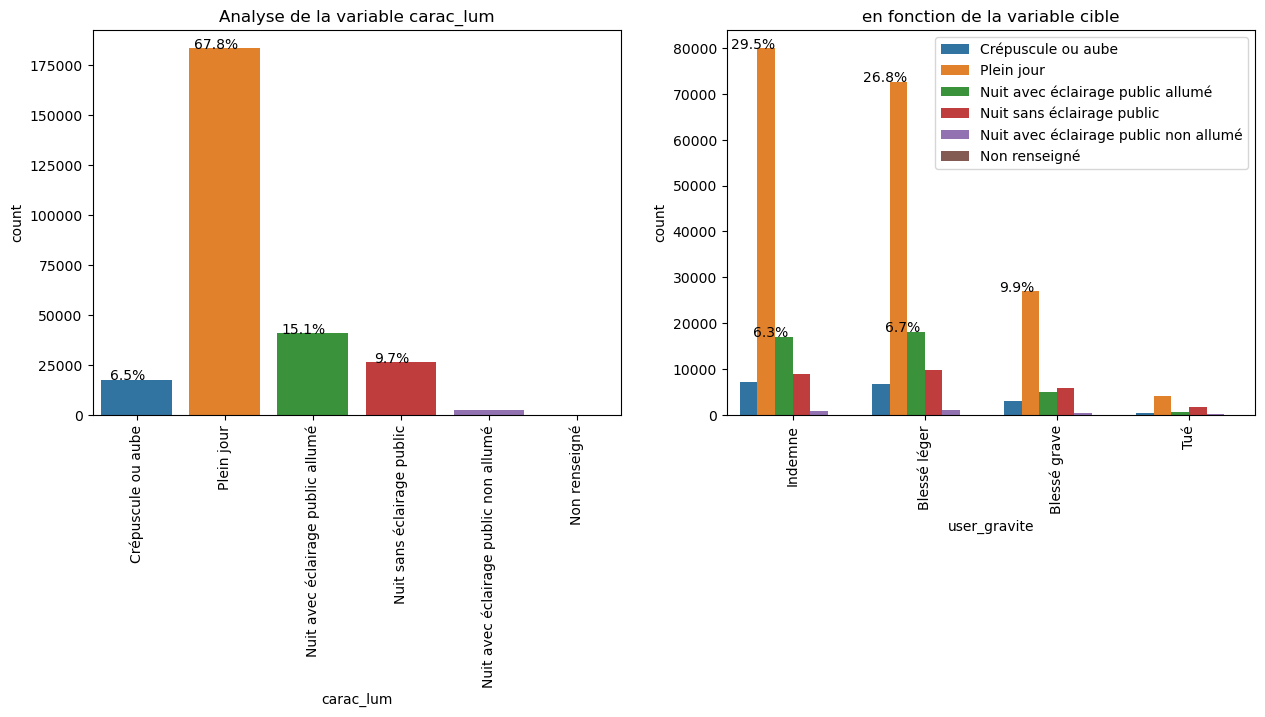

Outliers=
Outliers=
-> Q1= 1.0 - Q3= 3.0 - IQR= 2.0 - Borne inf= -2.0 - Borne sup= 6.0
-> Outlier(s) inférieur(s) - min= nan - max= nan - nb= 0
[]
-> Outlier(s) supérieur(s) - min= nan - max= nan Outliers nb= 0
[]


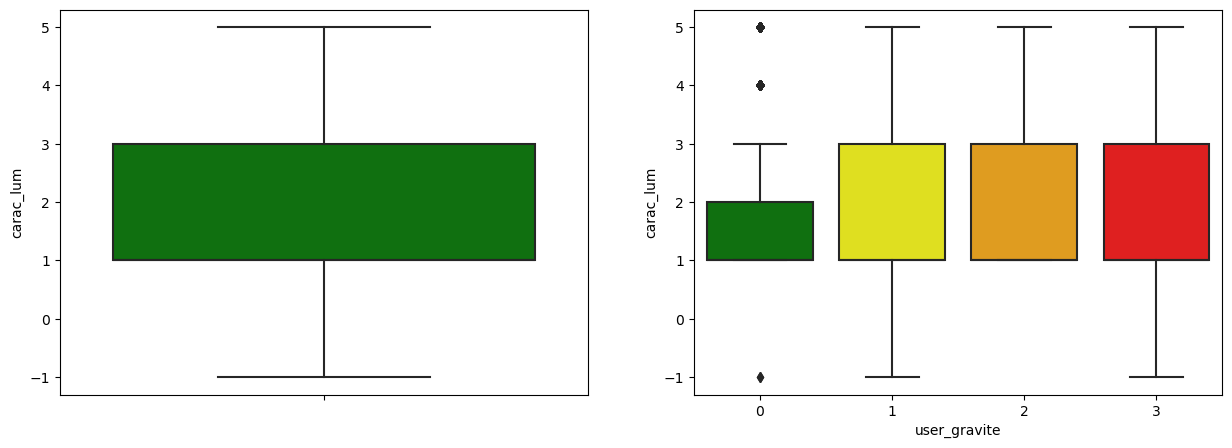

TENTATIVE OPTIMISATION PAR REGROUPEMENT BINAIRE
Tableau de contingence normalisé entre la variable et la variable cible : 


user_gravite         0         1         2         3
carac_lum                                           
-1            0.333333  0.500000  0.000000  0.166667
 1            0.435246  0.395614  0.146693  0.022447
 2            0.411035  0.388736  0.170726  0.029503
 3            0.339726  0.370580  0.223515  0.066179
 4            0.388122  0.407779  0.161439  0.042660
 5            0.416383  0.444333  0.121932  0.017352


Meilleurs résultats obtenu avec taux= 4.3
Liste des modalités retenues en modalité de regroupement 1 : [-1, 3]
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.10922



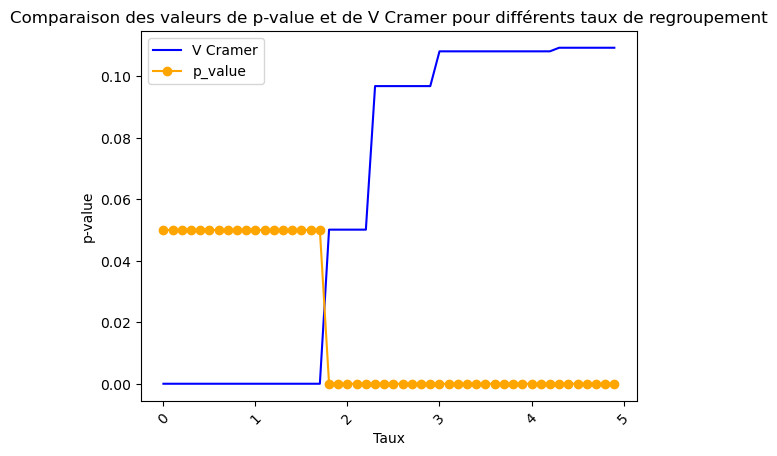

TENTATIVE OPTIMISATION PAR REGROUPEMENT NON BINAIRE

REGROUPEMENT NON BINAIRE : new_modalite= 6
Meilleurs résultats obtenu avec taux= 2.2
Liste des modalités regroupées dans la nouvelle catégorie 6 : [5]
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.11898



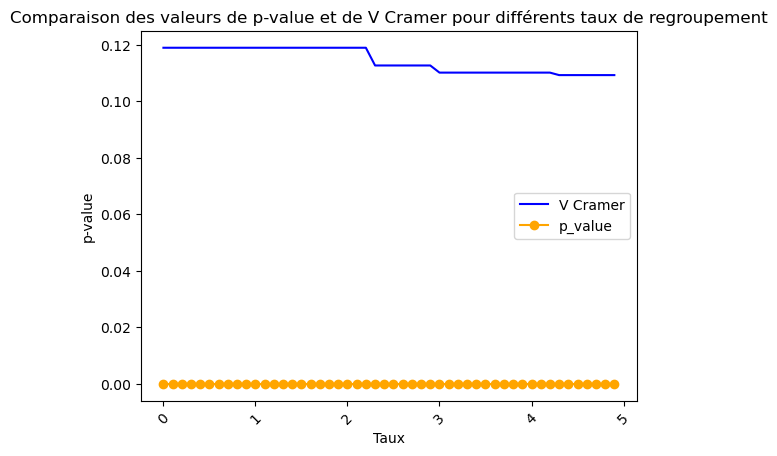


Optimisation Corrélation variable 'carac_lum':
 ==>> AUCUNE OPTIMISATION IDENTIFIEE PAR TRANSFORMATION DU REGROUPEMENT DE LA VARIBLE.

Il y a 0.0% (0) de données manquantes (ou assimilées).
Il y a 5 modalités.

carac_lumMV
1    0.678177
5    0.150929
3    0.097456
2    0.064606
4    0.008832
Name: proportion, dtype: float64

Test Statistique du chi2 (sans regroupement) : p-value=0.000 ; V de Cramer=0.11889

Tableau de contingence entre la variable et la variable cible (pour chi2): 


user_gravite      0      1      2     3
carac_lumMV                            
1             79908  72633  26931  4122
2              7189   6799   2986   516
3              8963   9777   5897  1746
4               928    975    386   102
5             17013  18155   4982   709



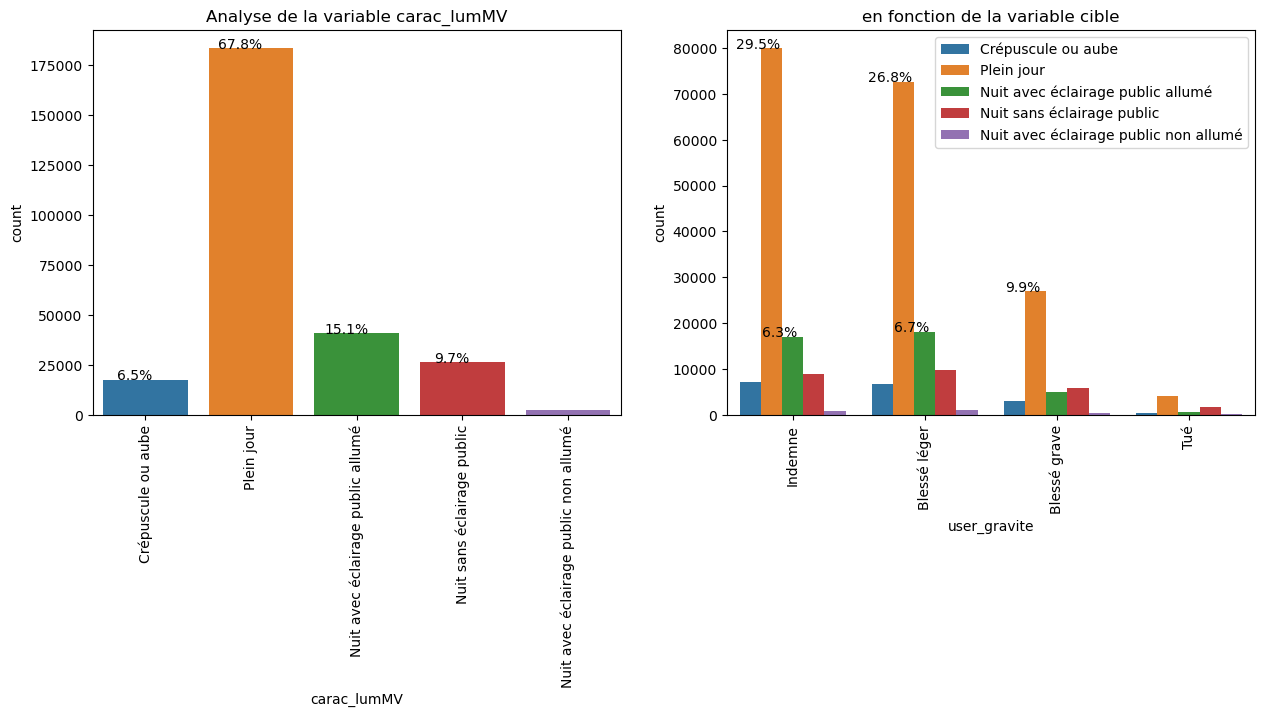

Outliers=
Outliers=
-> Q1= 1.0 - Q3= 3.0 - IQR= 2.0 - Borne inf= -2.0 - Borne sup= 6.0
-> Outlier(s) inférieur(s) - min= nan - max= nan - nb= 0
[]
-> Outlier(s) supérieur(s) - min= nan - max= nan Outliers nb= 0
[]


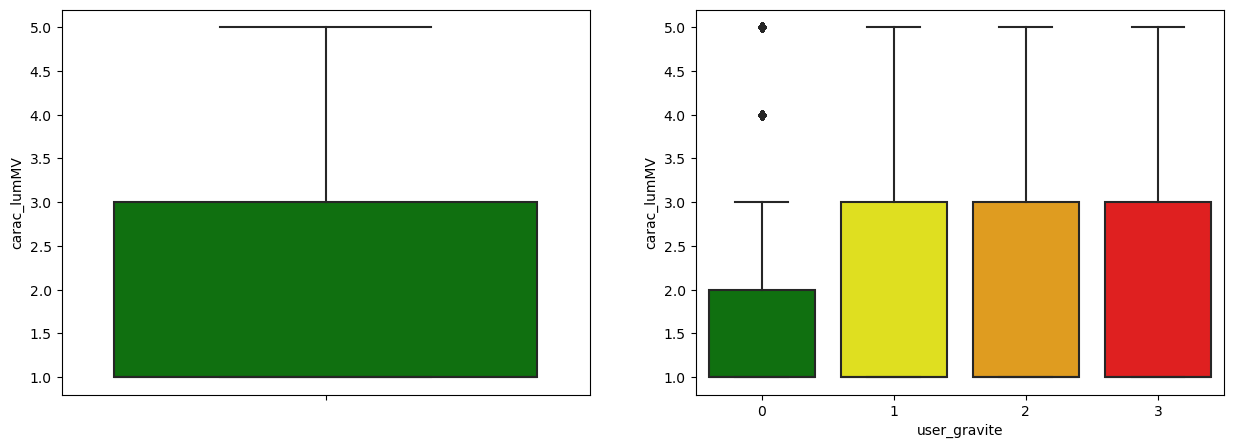

TENTATIVE OPTIMISATION PAR REGROUPEMENT BINAIRE
Tableau de contingence normalisé entre la variable et la variable cible : 


user_gravite         0         1         2         3
carac_lumMV                                         
1             0.435243  0.395618  0.146688  0.022452
2             0.411035  0.388736  0.170726  0.029503
3             0.339726  0.370580  0.223515  0.066179
4             0.388122  0.407779  0.161439  0.042660
5             0.416383  0.444333  0.121932  0.017352


Meilleurs résultats obtenu avec taux= 4.3
Liste des modalités retenues en modalité de regroupement 1 : [3]
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.10920



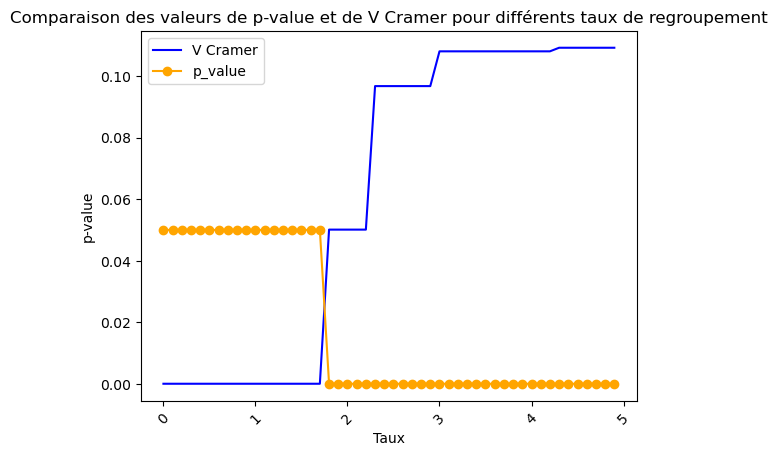

TENTATIVE OPTIMISATION PAR REGROUPEMENT NON BINAIRE

REGROUPEMENT NON BINAIRE : new_modalite= 6
Meilleurs résultats obtenu avec taux= 2.2
Liste des modalités regroupées dans la nouvelle catégorie 6 : [5]
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.11889



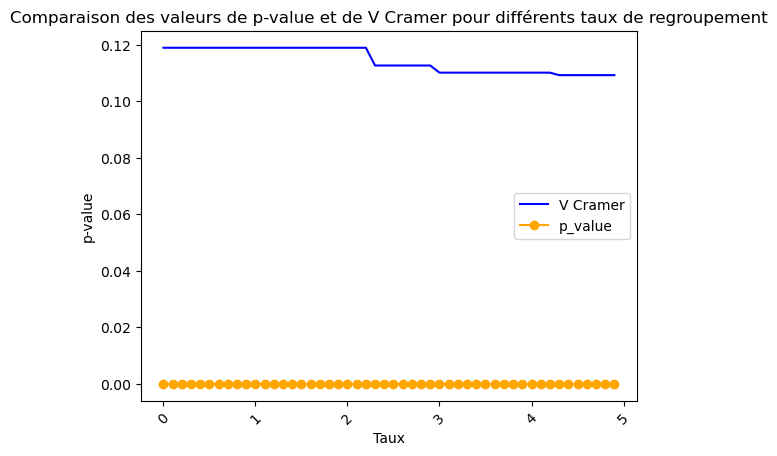


Optimisation Corrélation variable 'carac_lumMV':
 ==>> AUCUNE OPTIMISATION IDENTIFIEE PAR TRANSFORMATION DU REGROUPEMENT DE LA VARIBLE.


In [144]:
# -----------
# 'CARAC_ATM' - Conditions atmosphériques
# -----------
"""
code_to_huelabel = {
    '-1': 'Non renseigné',
    '1' : 'Normale', 
    '2' : 'Pluie légère', 
    '3' : 'Pluie forte', 
    '4' : 'Neige/grêle', 
    '5' : 'Brouillard/fumée', 
    '6' : 'Vent fort', 
    '7' : 'Temps éblouissant', 
    '8' : 'Temps couvert',
    '9' : 'Autre'
}

new_rgmt = analyse_variable_categorielle(train, 'carac_atm', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=25.0, rotation_xlabel=90)

# 'CARAC_ATM' - Remplacement des missing values
train['carac_atmMV'] = train.carac_atm.fillna(train.carac_atm.mode()[0])                      # valeur NaN si existante
train['carac_atmMV'] = train.carac_atm.replace(-1, train.carac_atm.mode()[0]).astype(int)     # valeur -1 si existante

new_rgmt = analyse_variable_categorielle(train, 'carac_atmMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=25.0, rotation_xlabel=90)
"""

# -----------
# 'CARAC_COL' - Type de collision
# -----------
"""
code_to_huelabel = {
    '1' : '2v frontale', 
    '2' : '2v arrière', 
    '3' : '2v coté', 
    '4' : '3v+ en chaîne', 
    '5' : '3v+ collisions multiples', 
    '6' : 'Autre collision', 
    '7' : 'Sans collision'
}

new_rgmt = analyse_variable_categorielle(train, 'carac_col', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=25.0, rotation_xlabel=90)

# 'CARAC_COL' - analyse de la meilleure stratégie de remplacement des missing values
liste_variables_categorielles = []

analyse_valeurs_manquantes(train, 'carac_col', 
                           variables_continues=['carac_gps_lat', 'carac_gps_long', 'lieu_larrout', 'lieu_lartpc', 'lieu_vma'], 
                           variables_categorielles=['carac_atm', 'carac_com', 'carac_dept', 'carac_int', 'carac_lum', 'lieu_catr', 'lieu_circ', 
                                                    'user_secu2', 'user_secu3', 'user_trajet', 'lieu_infra', 'lieu_nbv', 'lieu_plan', 'lieu_prof', 
                                                    'lieu_situ', 'lieu_surf', 'lieu_vosp'])

# ==> aucune tendance ne ressort ==> on privilégiera le mode[0]

# Remplacement des missing values
train['carac_colMV'] = train.carac_col.fillna(train.carac_col.mode()[0])                      # valeur NaN si existante
train['carac_colMV'] = train.carac_col.replace(-1, train.carac_col.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'carac_colMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=25.0, rotation_xlabel=90)

# ==> Aucune incidence constaté sur l'indice de Cramer ==> le remplacement par la modalité fait sens.
"""

# -----------
# 'CARAC_COM' - Commune de l'accident
# -----------
#new_rgmt = analyse_variable_categorielle(train, 'carac_com', valna=-1, liste_taux=liste_taux, limiteModalite=20)  # pas d'affichage de graphe de dist.

# -----------
# 'CARAC_DEPT' - Département de l'accident
# -----------
#new_rgmt = analyse_variable_categorielle(train, 'carac_dept', valna=-1, liste_taux=liste_taux, limiteModalite=20)  # pas d'affichage de graphe de dist.

# -----------
# 'CARAC_INT' - Type d'intersection
# -----------
"""
code_to_huelabel = {
    '-1' : 'Non renseigné',
    '1' : 'Hors intersection', 
    '2' : 'Intersection en X', 
    '3' : 'Intersection en T', 
    '4' : 'Intersection en Y', 
    '5' : 'Intersection à plus de 4 branches', 
    '6' : 'Giratoire', 
    '7' : 'Place', 
    '8' : 'Passage à niveau', 
    '9' : 'Autre intersection'
}
new_rgmt = analyse_variable_categorielle(train, 'carac_int', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'carac_int' - Remplacement des missing values
train['carac_intMV'] = train.carac_int.fillna(train.carac_int.mode()[0])                      # valeur NaN si existante
train['carac_intMV'] = train.carac_int.replace(-1, train.carac_int.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'carac_intMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'CARAC_LUM' - Luminosité au moment de l'accident
# -----------
"""
code_to_huelabel = {
    '-1' : 'Non renseigné',
    '1' : 'Plein jour', 
    '2' : 'Crépuscule ou aube', 
    '3' : 'Nuit sans éclairage public', 
    '4' : 'Nuit avec éclairage public non allumé', 
    '5' : 'Nuit avec éclairage public allumé'
}
new_rgmt = analyse_variable_categorielle(train, 'carac_lum', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'carac_lum' - Remplacement des missing values
train['carac_lumMV'] = train.carac_lum.fillna(train.carac_lum.mode()[0])                      # valeur NaN si existante
train['carac_lumMV'] = train.carac_lum.replace(-1, train.carac_lum.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'carac_lumMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""




<u>CONCLUSION :
- <span style="color:red">__'CARAC_ATM'__</span> :</u>
1. Très peu de missing value (23 au total) : Le remplacement par la modalité n'a pas d'incidence sur le Test de Cramer 
2. 9 modalités :
   - les deux premières représentent plus de 90%
   - modalités non ordonnées --> un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) : 
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0,057)
   - après missing Values via classe : V Cramer =0.057

  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__

  <span style="color:red">__==> UN RETRAIT DE CETTE VARIABLE DU SCOPE DES VARIABLES EXPLICATIVES AURAIT DU SENS__</span>

  
- <span style="color:red">__'CARAC_COL'__</span> :</u>
1. Quelques missing value (1% soit 2910 au total) : l'analyse détaillée n'a pas permis de faire ressortir de tendance.
2. Remplacement des missing Values par la modalité la plus fréquente n'impacte pas le test de Cramer
3. 7 modalités :
   - les deux premières représentent plus de 55%, 3 premières=70% et 4 premières=80%
   - Modalités non ordonnées, un encodage sera nécessaire si maintien de la variable
4. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
5. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.264)
   - après missing Values via classe : V Cramer =0.264

  __==> MAINTIEN DES MISSING VALUES DANS LA CATEGORISATION '-1' OU REMPLACEMENT PAR LA MODALITE LA PLUS FREQUENTE__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__
  

- <span style="color:red">__'CARAC_COM'__</span> :</u>
1. Aucune missing value
2. plus de 850 modalités :
   - avec une distribution relativement homogène
   - Modalités non ordonnées mais vu le nombre, l'utilisation d'un scaler plutôt qu'un en,coder semble préférable
4. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
5. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.260)
   - après missing Values via classe :

  __==> AUCUNE, LA VARIABLE POURRA ETRE UTILISEE EN L'ETAT__

  __==> UNE NORMALISATION SERA PRIVILEGIEE A L'ENCODAGE DE PAR LE NOMBRE DE MODALITES__
  

- <span style="color:red">__'CARAC_DEPT'__</span> :</u>
1. Aucune missing value
2. 107 modalités avec une distribution relativement homogène
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.286)
   - après missing Values via classe :
   - après Rééquilibrage des classes via SMOTE : V Cramer=0.45390

  __==> AUCUNE, LA VARIABLE POURRA ETRE UTILISEE EN L'ETAT__

  __==> UNE NORMALISATION SERA PRIVILEGIEE A L'ENCODAGE DE PAR LE NOMBRE DE MODALITES__


- <span style="color:red">__'CARAC_INT'__</span> :</u>
1. 8 missing values : Le remplacement par la modalité la plus fréquente n'impacte pas le test de Cramer
2. 9 modalités :
   - 2 modalités représentent 80%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
4. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
5. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.096)
   - après missing Values via classe :

  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__

  <span style="color:red">__==> UN RETRAIT DE CETTE VARIABLE DU SCOPE DES VARIABLES EXPLICATIVES AURAIT DU SENS__</span>


- <span style="color:red">__'CARAC_LUM'__</span> :</u>
1. 6 missing value : remplacement par la modalité n'a pas d'incidence sur le test de Cramer.
2. 6 modalités :
   - 2 modalités représentent 82%
   - Modalités non ordonnées --> encodage nécessaire si maintien de la variable
4. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
5. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.119)
   - après missing Values via classe : Cramer=0.119
   - après Rééquilibrage des classes via SMOTE : V Cramer=0.25265


  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> ONE HOT ENCODAGE NECESSAIRE SI MAINTIEN DE LA VARIABLE__ 
  

&#8195;

#### &#8195;
<u> <span style="color:green">ETAPE 6.2.3 - FICHIER __'LIEU'__</span></u>
- <span style="color:red">__'LIEU_CATR'__</span> : Catégorie de route
- <span style="color:red">__'LIEU_CIRC'__ : </span></u> : Régime de circulation
- <span style="color:red">__'LIEU_INFRA'__ : </span></u> : Aménagement Infrastructure du lieu de l'accident
- <span style="color:red">__'LIEU_PLAN'__ : </span></u> : Tracé en plan
- <span style="color:red">__'LIEU_PROF'__ : </span></u> : Déclivité de la route à l'endroit de l'accident
- <span style="color:red">__'LIEU_SITU'__ : </span></u> : Localisation de l'accident (situation exacte)
- <span style="color:red">__'LIEU_SURF'__ : </span></u> : Etat de la surface de la route
- <span style="color:red">__'LIEU_VOSP'__ : </span></u> : Voie réservée
  


Il y a 0.0% (1038) de données manquantes (ou assimilées).
Il y a 5 modalités.

lieu_vosp
 0    0.885489
 1    0.048863
 3    0.036632
 2    0.025181
-1    0.003834
Name: proportion, dtype: float64

Test Statistique du chi2 (sans regroupement) : p-value=0.000 ; V de Cramer=0.06455

Tableau de contingence entre la variable et la variable cible (pour chi2): 


user_gravite       0      1      2     3
lieu_vosp                               
-1               446    404    149    39
 0            100154  94678  38139  6746
 1              5844   6033   1190   161
 2              3116   2924    686    91
 3              4441   4300   1018   158



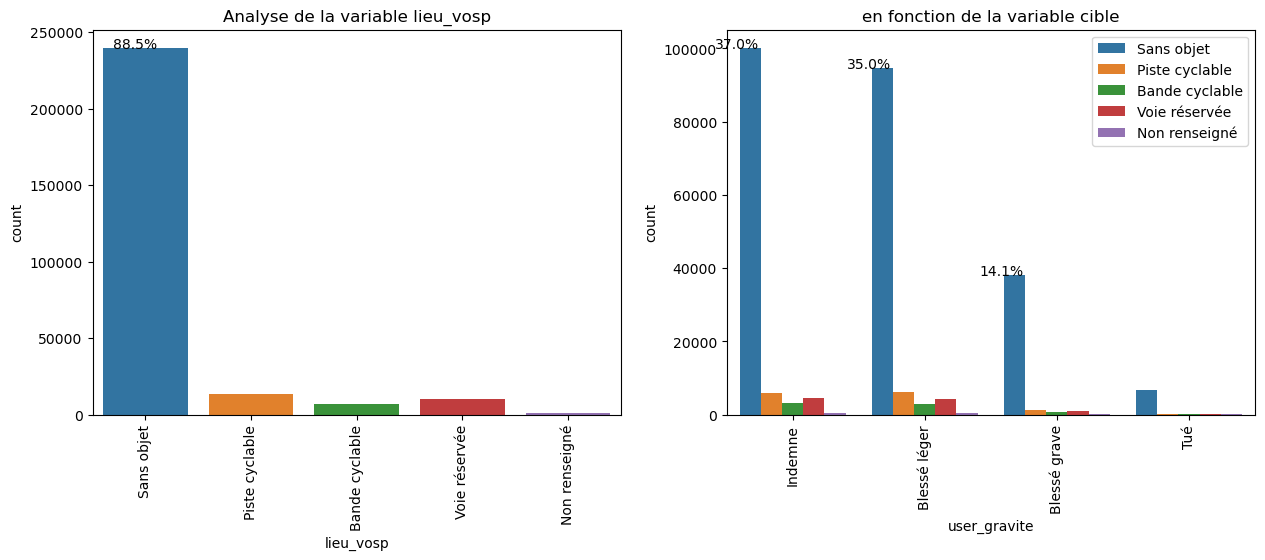

Outliers=
Outliers=
-> Q1= 0.0 - Q3= 0.0 - IQR= 0.0 - Borne inf= 0.0 - Borne sup= 0.0
-> Outlier(s) inférieur(s) - min= nan - max= nan - nb= 0
[]
-> Outlier(s) supérieur(s) - min= 1 - max= 3 Outliers nb= 29962
[1 1 1 ... 3 3 3]


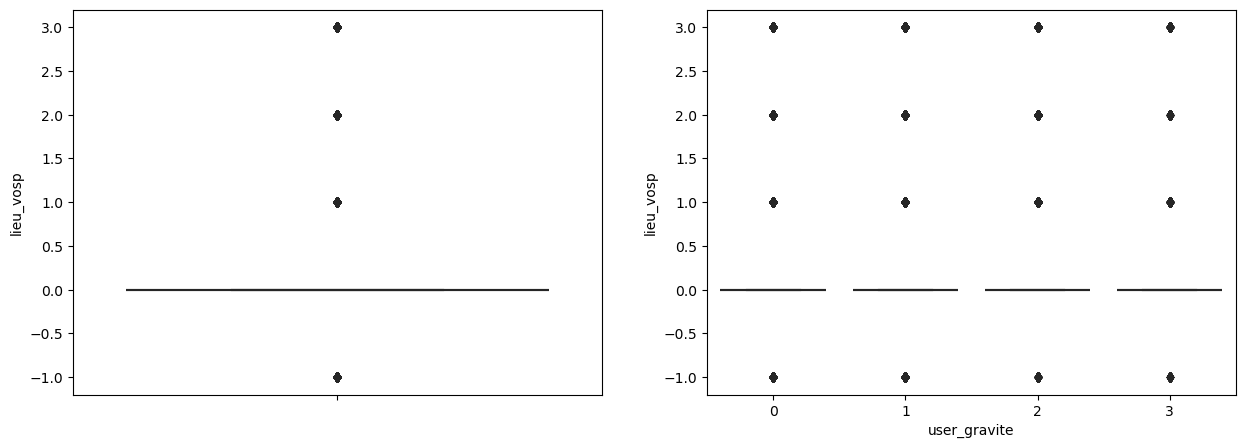

TENTATIVE OPTIMISATION PAR REGROUPEMENT BINAIRE
Tableau de contingence normalisé entre la variable et la variable cible : 


user_gravite         0         1         2         3
lieu_vosp                                           
-1            0.429672  0.389210  0.143545  0.037572
 0            0.417801  0.394957  0.159100  0.028142
 1            0.441790  0.456078  0.089961  0.012171
 2            0.457093  0.428928  0.100631  0.013349
 3            0.447817  0.433599  0.102652  0.015932


Meilleurs résultats obtenu avec taux= 1.6
Liste des modalités retenues en modalité de regroupement 1 : [-1, 0]
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.06371



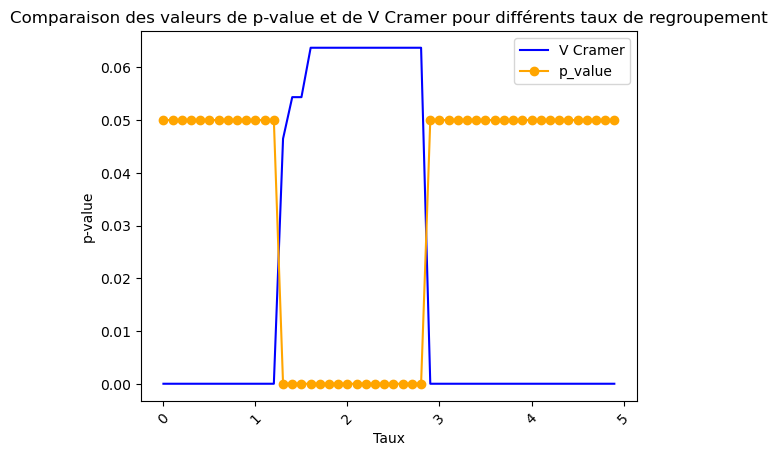

TENTATIVE OPTIMISATION PAR REGROUPEMENT NON BINAIRE

REGROUPEMENT NON BINAIRE : new_modalite= 4
Meilleurs résultats obtenu avec taux= 1.3
Liste des modalités regroupées dans la nouvelle catégorie 4 : [1]
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.06455



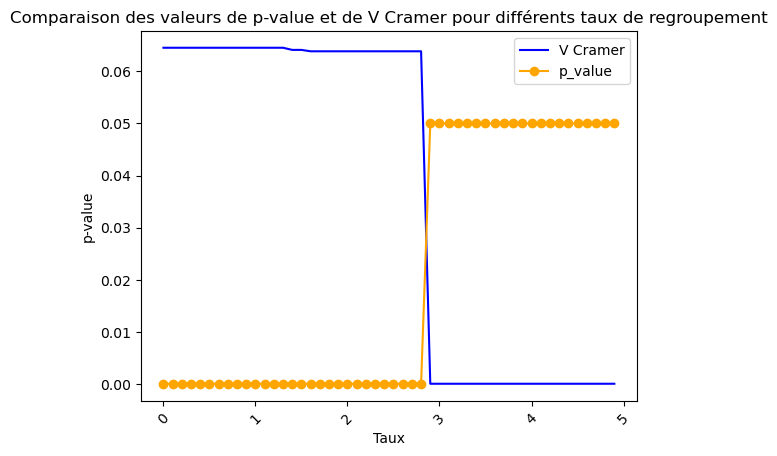


Optimisation Corrélation variable 'lieu_vosp':
 ==>> AUCUNE OPTIMISATION IDENTIFIEE PAR TRANSFORMATION DU REGROUPEMENT DE LA VARIBLE.

Il y a 0.0% (0) de données manquantes (ou assimilées).
Il y a 4 modalités.

lieu_vospMV
0    0.889324
1    0.048863
3    0.036632
2    0.025181
Name: proportion, dtype: float64

Test Statistique du chi2 (sans regroupement) : p-value=0.000 ; V de Cramer=0.06440

Tableau de contingence entre la variable et la variable cible (pour chi2): 


user_gravite       0      1      2     3
lieu_vospMV                             
0             100600  95082  38288  6785
1               5844   6033   1190   161
2               3116   2924    686    91
3               4441   4300   1018   158



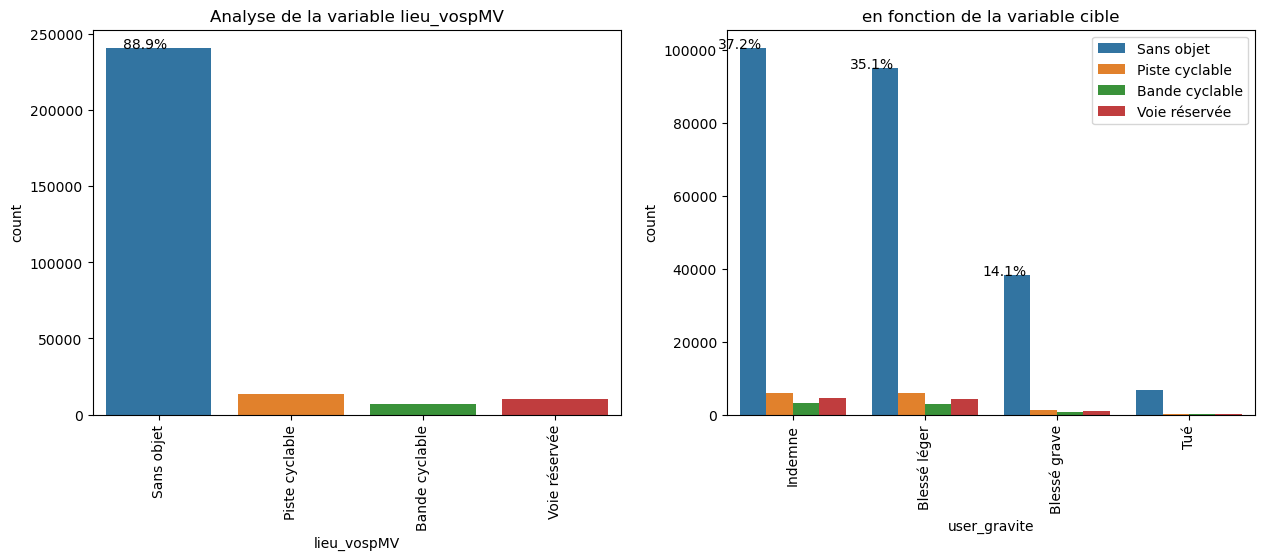

Outliers=
Outliers=
-> Q1= 0.0 - Q3= 0.0 - IQR= 0.0 - Borne inf= 0.0 - Borne sup= 0.0
-> Outlier(s) inférieur(s) - min= nan - max= nan - nb= 0
[]
-> Outlier(s) supérieur(s) - min= 1 - max= 3 Outliers nb= 29962
[1 1 1 ... 3 3 3]


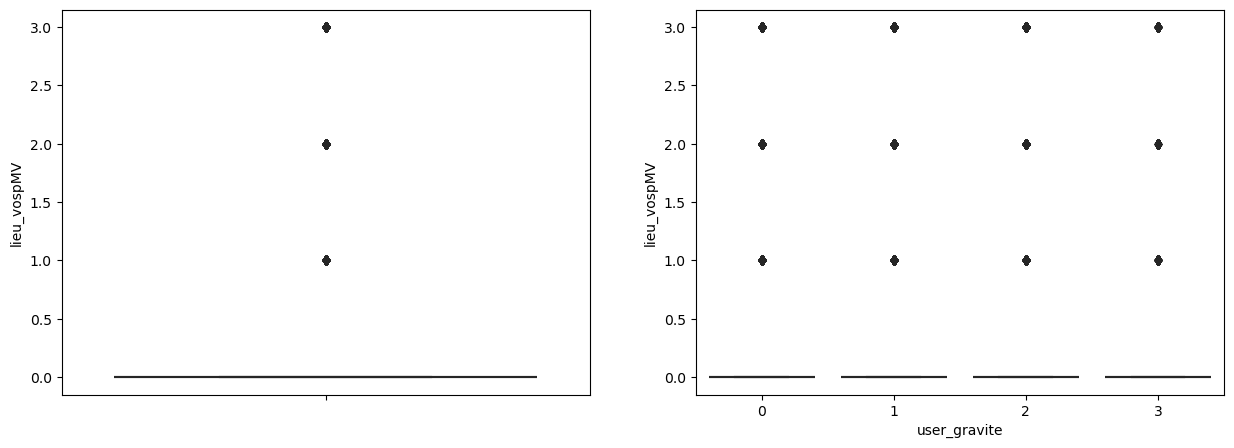

TENTATIVE OPTIMISATION PAR REGROUPEMENT BINAIRE
Tableau de contingence normalisé entre la variable et la variable cible : 


user_gravite         0         1         2         3
lieu_vospMV                                         
0             0.417852  0.394933  0.159033  0.028182
1             0.441790  0.456078  0.089961  0.012171
2             0.457093  0.428928  0.100631  0.013349
3             0.447817  0.433599  0.102652  0.015932


Meilleurs résultats obtenu avec taux= 1.6
Liste des modalités retenues en modalité de regroupement 1 : [0]
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.06371



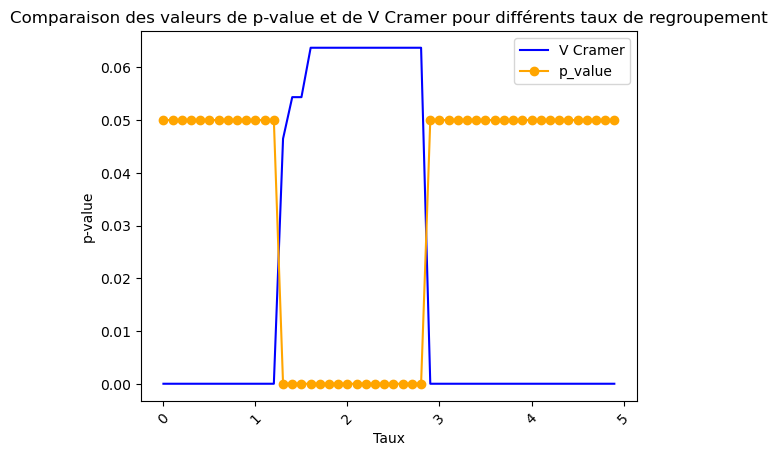

TENTATIVE OPTIMISATION PAR REGROUPEMENT NON BINAIRE

REGROUPEMENT NON BINAIRE : new_modalite= 4
Meilleurs résultats obtenu avec taux= 1.3
Liste des modalités regroupées dans la nouvelle catégorie 4 : [1]
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.06440



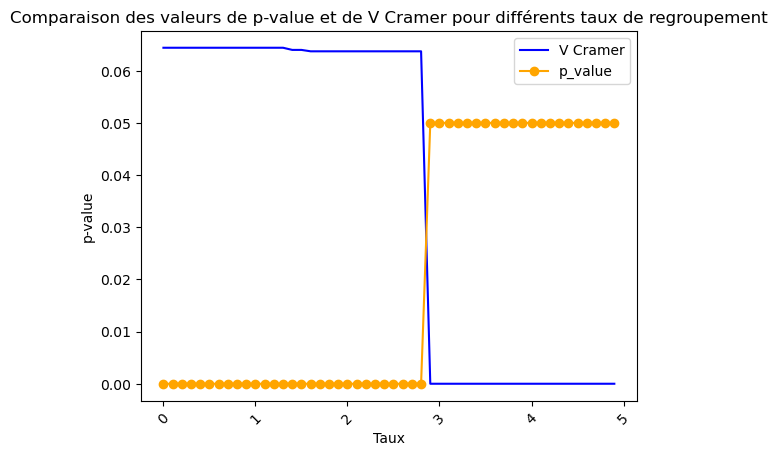


Optimisation Corrélation variable 'lieu_vospMV':
 ==>> AUCUNE OPTIMISATION IDENTIFIEE PAR TRANSFORMATION DU REGROUPEMENT DE LA VARIBLE.


In [153]:
### -----------
# 'LIEU_CATR' - Catégorie de route
# -----------
"""
code_to_huelabel = {
    '1' : 'Autoroute',
    '2' : 'Route nationale',
    '3' : 'Route Départementale',
    '4' : 'Voie Communales',
    '5' : 'Hors réseau public',
    '6' : 'Parc de stationnement ouvert à la circulation publique',
    '7' : 'Routes de métropole urbaine',
    '9' : 'autre' 
}
new_rgmt = analyse_variable_categorielle(train, 'lieu_catr', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'LIEU_CIRC' - Régime de circulation
# -----------
"""
# 'lieu_circ'
code_to_huelabel = {
    '-1': 'Non renseigné',
    '1' : 'A sens unique',
    '2' : 'Bidirectionnelle',
    '3' : 'A chaussées séparées',
    '4' : 'Avec voies d’affectation variable'
}
new_rgmt = analyse_variable_categorielle(train, 'lieu_circ', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'LIEU_CIRC' - Remplacement des missing values
train['lieu_circMV'] = train.lieu_circ.fillna(train.lieu_circ.mode()[0])                      # valeur NaN si existante
train['lieu_circMV'] = train.lieu_circ.replace(-1, train.lieu_circ.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'lieu_circMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'LIEU_INFRA' - Infrastructure sur lieu de l'accident
# -----------
"""
# 'lieu_infra'
code_to_huelabel = {
    '-1': 'Non renseigné',
    '0' : 'Aucun',
    '1' : 'Souterrain - tunnel',
    '2' : 'Pont - autopont',
    '3' : 'Bretelle d’échangeur ou de raccordement',
    '4' : 'Voie ferrée',
    '5' : 'Carrefour aménagé',
    '6' : 'Zone piétonne',
    '7' : 'Zone de péage',
    '8' : 'Chantier',
    '9' : 'Autres'
}
new_rgmt = analyse_variable_categorielle(train, 'lieu_infra', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'LIEU_INFRA' - Remplacement des missing values
train['lieu_infraMV'] = train.lieu_infra.fillna(train.lieu_infra.mode()[0])                      # valeur NaN si existante
train['lieu_infraMV'] = train.lieu_infra.replace(-1, train.lieu_infra.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'lieu_infraMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'LIEU_PLAN' - Tracé en plan
# -----------
"""
# 'lieu_plan'
code_to_huelabel = {
    '-1': 'Non renseigné',
    '1' : 'Partie rectiligne',
    '2' : 'En courbe à gauche',
    '3' : 'En courbe à droite',
    '4' : 'En S'
}
new_rgmt = analyse_variable_categorielle(train, 'lieu_plan', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'LIEU_PLAN' - Remplacement des missing values
train['lieu_planMV'] = train.lieu_plan.fillna(train.lieu_plan.mode()[0])                      # valeur NaN si existante
train['lieu_planMV'] = train.lieu_plan.replace(-1, train.lieu_plan.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'lieu_planMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'LIEU_PROF' - Déclivité de la route (profil)
# -----------
"""
code_to_huelabel = {
    '-1': 'Non renseigné',
    '1' : 'Plat',
    '2' : 'Pente',
    '3' : 'Sommet de côte',
    '4' : 'Bas de côte'
}
new_rgmt = analyse_variable_categorielle(train, 'lieu_prof', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'LIEU_PROF' - Remplacement des missing values
train['lieu_profMV'] = train.lieu_prof.fillna(train.lieu_prof.mode()[0])                      # valeur NaN si existante
train['lieu_profMV'] = train.lieu_prof.replace(-1, train.lieu_prof.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'lieu_profMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'LIEU_SITU' - Localisation de l'accident
# -----------
"""
# 'lieu_situ'
code_to_huelabel = {
    '-1': 'Non renseigné',
    '0' : 'Aucun',
    '1' : 'Sur chaussée',
    '2' : 'Sur bande d’arrêt d’urgence', 
    '3' : 'Sur accotement',
    '4' : 'Sur trottoir',
    '5' : 'Sur piste cyclable',
    '6' : 'Sur Autre voie spéciale',
    '7' : '???',
    '8' : 'Autre'
}
new_rgmt = analyse_variable_categorielle(train, 'lieu_situ', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'LIEU_SITU' - Remplacement des missing values
train['lieu_situMV'] = train.lieu_situ.fillna(train.lieu_situ.mode()[0])                      # valeur NaN si existante
train['lieu_situMV'] = train.lieu_situ.replace(-1, train.lieu_situ.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'lieu_situMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'LIEU_SURF' - Etat de la surface de la route
# -----------
"""
# 'lieu_surf'
code_to_huelabel = {
    '-1': 'Non renseigné',
    '1' : 'Normale',
    '2' : 'Mouillée',
    '3' : 'Flaques',
    '4' : 'Inondée',
    '5' : 'Enneigée',
    '6' : 'Boue',
    '7' : 'Verglacée',
    '8' : 'Corps gras'
}
new_rgmt = analyse_variable_categorielle(train, 'lieu_surf', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'LIEU_SURF' - Remplacement des missing values
train['lieu_surfMV'] = train.lieu_surf.fillna(train.lieu_surf.mode()[0])                      # valeur NaN si existante
train['lieu_surfMV'] = train.lieu_surf.replace(-1, train.lieu_surf.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'lieu_surfMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'LIEU_VOSP' - Voie réservée
# -----------
"""
# 'lieu_vosp'
code_to_huelabel = {
    '-1': 'Non renseigné',
    '0' : 'Sans objet',
    '1' : 'Piste cyclable',
    '2' : 'Bande cyclable',
    '3' : 'Voie réservée' 
}

new_rgmt = analyse_variable_categorielle(train, 'lieu_vosp', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'LIEU_VOSP' - Remplacement des missing values
train['lieu_vospMV'] = train.lieu_vosp.fillna(train.lieu_vosp.mode()[0])                      # valeur NaN si existante
train['lieu_vospMV'] = train.lieu_vosp.replace(-1, train.lieu_vosp.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'lieu_vospMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""




<u>CONCLUSION :
- <span style="color:red">__'LIEU_CATR'__</span> :</u>
1. Aucune missing value
2. 8 modalités :
   - 3 modalités représentent 87%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
4. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
5. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.185)
   - après missing Values via classe :

  __==> LA VARIABLE POURRA ETRE CONSERVEE EN L'ETAT__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__

  
- <span style="color:red">__'LIEU_CIRC'__</span> :</u>
1. 5% de missing value (14757 enregistrements) : Remplacement par la modalité la plus fréquente impacte légèrement le test de Cramer (0.140)
2. 4 modalités :
   - 2 modalités représentent 78%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
4. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
5. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.148)
   - après missing Values via classe : Cramer=0.140

  __==> LA VARIABLE POURRA ETRE UTILISEE EN L'ETAT__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__


- <span style="color:red">__'LIEU_INFRA'__</span> :</u>
1. 1% de missing value (3249) : Le remplacement par la modalité la plus fréquente dégrade légèrement le test de Cramer (0.050)
2. 10 modalités : 1 modalités représentent plus de 83% 
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.063)
   - après missing Values via classe : Cramer=0.050
   - après Rééquilibrage des classes via SMOTE : V Cramer=0.20587

  __==> MAINTIEN DES MISSING VALUES DANS LA CATEGORISATION '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__
 
  <span style="color:red">__==> UN RETRAIT DE CETTE VARIABLE DU SCOPE DES VARIABLES EXPLICATIVES AURAIT DU SENS__</span>


- <span style="color:red">__'LIEU_PLAN'__</span> :</u>
1. Quelques missing value (38). Le remplacement par la modalité la plus fréquente n'impacte pas le test de Cramer (0.125)
2. 4 modalités : 1 modalités représentent + de 81% 
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.125)
   - après missing Values via classe : Cramer=0.125

  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__


- <span style="color:red">__'LIEU_PROF'__</span> :</u>
1. Quelques missing values (37). Le remplacement n'a pas d'impact sur le test de Cramer (0.072)
2. 4 modalités : 1 modalités représentent + de 81% 
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.072)
   - après missing Values via classe : Cramer=0.072

  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__

  <span style="color:red">__==> UN RETRAIT DE CETTE VARIABLE DU SCOPE DES VARIABLES EXPLICATIVES AURAIT DU SENS__</span>
  
  
- <span style="color:red">__'LIEU_SITU'__</span> :</u>
1. Quelques missing values (38)
2. 7 modalités :
   - 1 modalité représente 86%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
4. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
5. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.232)
   - après missing Values via modalité la plus fréquente : Cramer=0.232


  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__


- <span style="color:red">__'LIEU_SURF'__</span> :</u>
1. Quelques missing values (56)
2. 9 modalités : 1 modalité représente 81% 
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.049)
   - après missing Values via modalité la plus fréquente : Cramer=0.049

  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__

  <span style="color:red">__==> UN RETRAIT DE CETTE VARIABLE DU SCOPE DES VARIABLES EXPLICATIVES AURAIT DU SENS__</span>


- <span style="color:red">__'LIEU_VOSP'__</span> :</u>
1. Quelques missing values (1038)
2. 4 modalités :
   - 1 modalité représente + de 88%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.065)
   - après missing Values via modalité la plus fréquente : Cramer=0.064

  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__
  
  <span style="color:red">__==> UN RETRAIT DE CETTE VARIABLE DU SCOPE DES VARIABLES EXPLICATIVES AURAIT DU SENS__</span>
  

&#8195;


#### &#8195;
<u> <span style="color:green">ETAPE 6.2.4 - FICHIER __'VEHI'__</span></u>
- <span style="color:red">__'VEHI_CATV'__</span> : Catégorie détaillée des véhicules
- <span style="color:red">__'AGG_CATV_PERSO'__</span></u> : Catégorisation simplifiée des véhicules (par regroupement) 
- <span style="color:red">__'VEHI_CHOC'__</span></u> : Point de choc initial
- <span style="color:red">__'VEHI_MANV'__</span></u> : Manoeuvre au moment de l'accident
- <span style="color:red">__'VEHI_MOTOR'__</span></u> : Type de motorisation du véhicule
- <span style="color:red">__'VEHI_OBS'__</span></u> : Obstacle fixe heurté
- <span style="color:red">__'VEHI_OBSM'__</span></u> : Obstacle mobile heurté
- <span style="color:red">__'VEHI_SENC'__</span></u> : Sens de circulation
  


Il y a 0.0% (0) de données manquantes (ou assimilées).
Il y a 4 modalités.

vehi_senc
1.0    0.449938
2.0    0.341519
3.0    0.142980
0.0    0.065563
Name: proportion, dtype: float64

Test Statistique du chi2 (sans regroupement) : p-value=0.000 ; V de Cramer=0.02185

Tableau de contingence entre la variable et la variable cible (pour chi2): 


user_gravite      0      1      2     3
vehi_senc                              
0.0            7287   7301   2809   352
1.0           51596  48905  18045  3260
2.0           38655  36772  14306  2722
3.0           16463  15361   6022   861



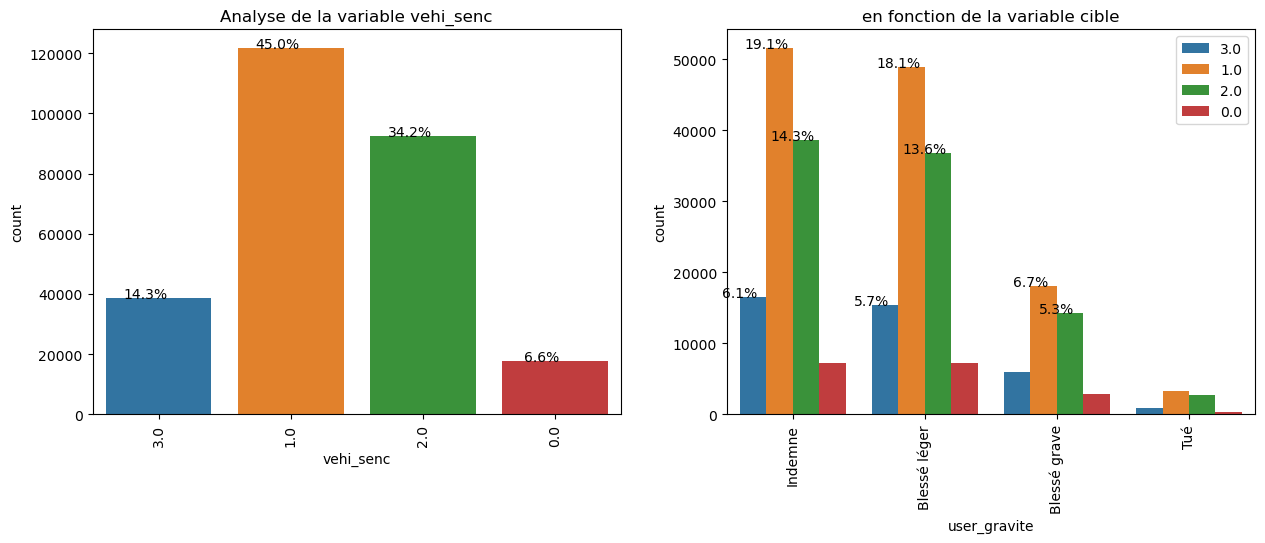

Outliers=
Outliers=
-> Q1= 1.0 - Q3= 2.0 - IQR= 1.0 - Borne inf= -0.5 - Borne sup= 3.5
-> Outlier(s) inférieur(s) - min= nan - max= nan - nb= 0
[]
-> Outlier(s) supérieur(s) - min= nan - max= nan Outliers nb= 0
[]


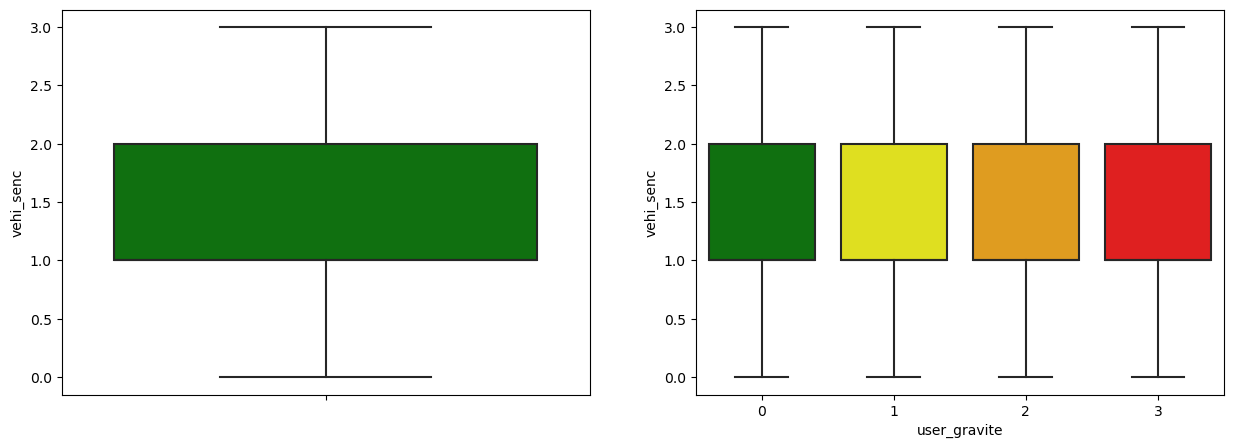

TENTATIVE OPTIMISATION PAR REGROUPEMENT BINAIRE
Tableau de contingence normalisé entre la variable et la variable cible : 


user_gravite         0         1         2         3
vehi_senc                                           
0.0           0.410558  0.411347  0.158262  0.019832
1.0           0.423592  0.401499  0.148145  0.026764
2.0           0.418095  0.397729  0.154735  0.029441
3.0           0.425324  0.396853  0.155579  0.022244


Meilleurs résultats obtenu avec taux= 2.3000000000000003
Liste des modalités retenues en modalité de regroupement 1 : [1.0, 2.0]
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.01703



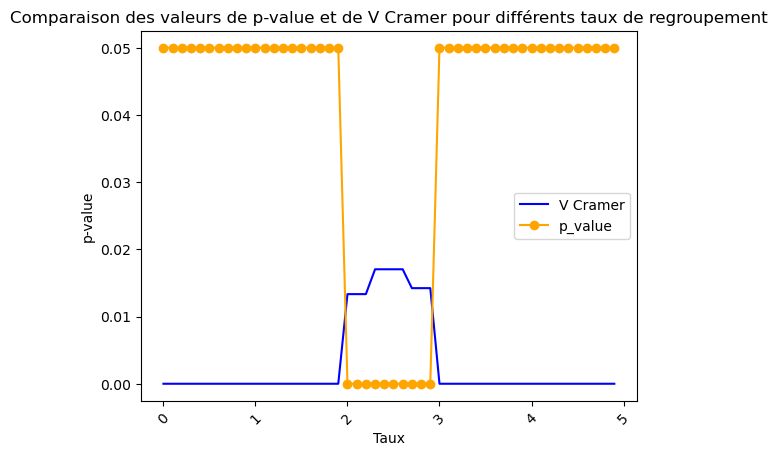

TENTATIVE OPTIMISATION PAR REGROUPEMENT NON BINAIRE

REGROUPEMENT NON BINAIRE : new_modalite= 4
Meilleurs résultats obtenu avec taux= 2.2
Liste des modalités regroupées dans la nouvelle catégorie 4 : [0.0]
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.02185



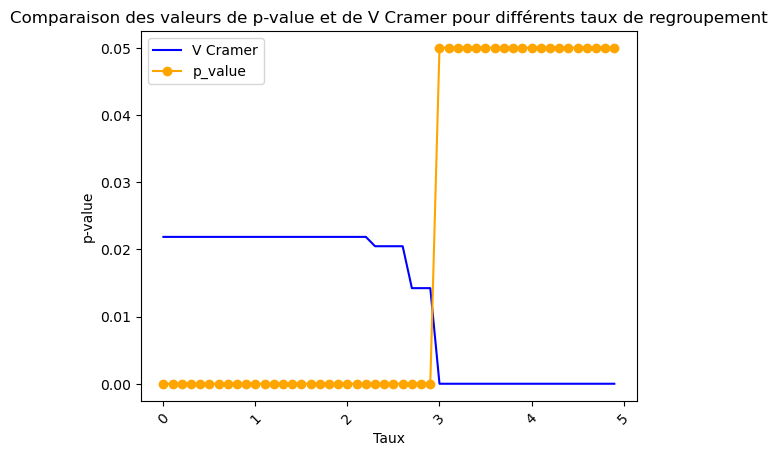


Optimisation Corrélation variable 'vehi_senc':
 ==>> AUCUNE OPTIMISATION IDENTIFIEE PAR TRANSFORMATION DU REGROUPEMENT DE LA VARIBLE.


In [164]:
# -----------
# 'VEHI_CATV' - Catégorisation des types de véhicules
# -----------
#new_rgmt = analyse_variable_categorielle(train, 'vehi_catv', valna=-1, liste_taux=liste_taux, viewPercent=5.0, rotation_xlabel=90)  

# ----------------
# 'AGG_CATV_PERSO' - Catégorisation perso des types de véhicules
# ----------------
"""
code_to_huelabel = {
    '1' : 'vélo',
    '2' : 'véhicule sans permis',
    '3' : 'moto > 125cm3',
    '4' : 'véhicule léger',
    '5' : 'poids lourds',
    '6' : 'Autres'
}

new_rgmt = analyse_variable_categorielle(train, 'agg_catv_perso', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'VEHI_CHOC' - Emplacement du choc
# -----------
"""
# 'vehi_choc'
code_to_huelabel = {
    '-1': 'non renseigné',
    '0' : 'Aucun',
    '1' : 'Avant',
    '2' : 'Avant droit',
    '3' : 'Avant gauche',
    '4' : 'Arrière',
    '5' : 'Arrière droit',
    '6' : 'Arrière gauche',
    '7' : 'Côté droit',
    '8' : 'Côté gauche',
    '9' : 'Chocs multiples (tonneaux)'
}

new_rgmt = analyse_variable_categorielle(train, 'vehi_choc', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'VEHI_CHOC' - Remplacement des missing values
train['vehi_chocMV'] = train.vehi_choc.fillna(train.vehi_choc.mode()[0])                      # valeur NaN si existante
train['vehi_chocMV'] = train.vehi_choc.replace(-1, train.vehi_choc.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'vehi_chocMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'VEHI_MANV' - Manoeuvre au moment de l'accident
# -----------
"""
new_rgmt = analyse_variable_categorielle(train, 'vehi_manv', valna=-1, liste_taux=liste_taux, viewPercent=5.0, rotation_xlabel=90)  

# 'VEHI_MANV' - Remplacement des missing values
train['vehi_manvMV'] = train.vehi_manv.fillna(train.vehi_manv.mode()[0])                      # valeur NaN si existante
train['vehi_manvMV'] = train.vehi_manv.replace(-1, train.vehi_manv.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'vehi_manvMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# ------------
# 'VEHI_MOTOR' - Type de motorisation
# ------------
"""
# 'vehi_motor'
code_to_huelabel = {
    '-1': 'non renseigné',
    '0' : 'Inconnue',
    '1' : 'Hydrocarbures',
    '2' : 'Hybride électrique',
    '3' : 'Electrique',
    '4' : 'Hydrogène',
    '5' : 'Humaine',
    '6' : 'Autre'
}

new_rgmt = analyse_variable_categorielle(train, 'vehi_motor', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'VEHI_MOTOR' - Remplacement des missing values
train['vehi_motorMV'] = train.vehi_motor.fillna(train.vehi_motor.mode()[0])                      # valeur NaN si existante
train['vehi_motorMV'] = train.vehi_motor.replace(-1, train.vehi_motor.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'vehi_motorMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# ----------
# 'VEHI_OBS' - Obstacle fixe heurté en premier
# ----------
"""
# 'vehi_obs'
new_rgmt = analyse_variable_categorielle(train, 'vehi_obs', valna=-1, liste_taux=liste_taux, viewPercent=5.0, rotation_xlabel=90)  

# 'VEHI_OBS' - Remplacement des missing values
train['vehi_obsMV'] = train.vehi_obs.fillna(train.vehi_obs.mode()[0])                      # valeur NaN si existante
train['vehi_obsMV'] = train.vehi_obs.replace(-1, train.vehi_obs.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'vehi_obsMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""


# ----------
# 'VEHI_OBSM' - Obstacle mobile heurté en premier
# ----------
"""
code_to_huelabel = {
     '-1': 'non renseigné',
     '0' : 'Aucun',
     '1' : 'Piéton',
     '2' : 'Véhicule',
     '4' : 'Véhicule sur rail',
     '5' : 'Animal domestique',
     '6' : 'Animal sauvage',
     '9' : 'Autre'
}

new_rgmt = analyse_variable_categorielle(train, 'vehi_obsm', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'VEHI_OBSM' - Remplacement des missing values
train['vehi_obsmMV'] = train.vehi_obsm.fillna(train.vehi_obsm.mode()[0])                      # valeur NaN si existante
train['vehi_obsmMV'] = train.vehi_obsm.replace(-1, train.vehi_obsm.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'vehi_obsmMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# ----------
# 'VEHI_SENC' - Sens de circulation
# ----------
"""
# 'vehi_senc'
code_to_huelabel = {
     '-1': 'non renseigné',
     '0' : 'Inconnu',
     '1' : 'sens croissant',
     '2' : 'sens décroissant',
     '4' : 'Absence de repère'
}
new_rgmt = analyse_variable_categorielle(train, 'vehi_senc', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""


<u>CONCLUSIONS :
- <span style="color:red">__'VEHI_CATV'__</span> :</u>
1. Aucune missing value
2. 31 modalités :
   - 4 modalités représentent 80%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
4. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
5. Le test de Cramer (+ Chi2) :
   - df initial : (Cramer=0.428) : A priori, une des variables les plus liée à la variable cible
   - après missing Values via modalité la plus fréquente : Cramer=

  __==> UTILISATION EN L'ETAT DE LA VARIABLE COMME VARIABLE EXPLICATIVE__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__


- <span style="color:red">__'AGG_CATV_PERSO'__</span> :</u>
1. Aucune missing value
2. 6 modalités :
   - 2 modalités représentent 80%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable 
4. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
5. Le test de Cramer (+ Chi2) :
   - df initial : Cramer=0.395 --> moins importante que la catégorisation initiale
   - après missing Values via modalité la plus fréquente : Cramer=

   __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__
   
   __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (RISQUE DE MULTI COLINEARITE)__</span>


- <span style="color:red">__'VEHI_CHOC'__</span> :</u>
1. Quelques missing values (120). 
2. 10 modalités :
   - 5 modalités représentent + de 80%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.240)
   - après missing Values via modalité la plus fréquente : Cramer=0.21076 (dégradation de l'indice)

  __==> MAINTIEN DES MISSING VALUES DANS LA CATEGORISATION '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__
  

- <span style="color:red">__'VEHI_MANV'__</span> :</u>
1. Quelques missing values (75). 
2. 27 modalités :
   - 9 modalités représentent + de 80%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.277)
   - après missing Values via modalité la plus fréquente : Cramer=0.277

  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__

  
- <span style="color:red">__'VEHI_MOTOR'__</span> :</u>
1. Quelques missing value (460). 
2. 7 modalités :
   - 1 modalité représent + de 83%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.22418)
   - après missing Values via modalité la plus fréquente : Cramer=0.18459 (légère dégradation) ==> Maintien de la classe '-1' recommandé

  __==> MAINTIEN DES MISSING VALUES DANS LA CATEGORISATION -1__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__


- <span style="color:red">__'VEHI_OBS'__</span> :</u>
1. Quelques missing values (87). 
2. 18 modalités :
   - 1 modalité représente + de 83%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.275)
   - après missing Values via modalité la plus fréquente : Cramer=0.275

  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__


- <span style="color:red">__'VEHI_OBSM'__</span> :</u>
1. Quelques missing values (104). 
2. 7 modalités :
   - 2 modalités représentent + de 85%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.253)
   - après missing Values via modalité la plus fréquente : Cramer=0.253

  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__


- <span style="color:red">__'VEHI_SENC'__</span> :</u>
1. Aucune missing value
2. 8 modalités :
   - 3 modalités représentent 87%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.022)
   - après missing Values via modalité la plus fréquente : Cramer=

  __==> UN MAITIEN EN L'ETAT DE LA VARIABLE MALGRE UNE CORRELATION FAIBLE SUR LE DATASET NON REEQUILIBRE__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__
  
  <span style="color:red">__==> UN RETRAIT DE CETTE VARIABLE DU SCOPE DES VARIABLES EXPLICATIVES AURAIT DU SENS__</span>
  
&#8195;



#### &#8195;
<u> <span style="color:green">ETAPE 6.2.5 - FICHIER __'USER'__</span></u>
- <span style="color:red">__'USER_CATU'__</span> : Catégorie d'usager
- <span style="color:red">__'USER_ACTP'__</span></u> : Action du piéton
- <span style="color:red">__'USER_ETATP'__</span></u> : Permet d'identifier si le piéton accidenté était seul ou non
- <span style="color:red">__'USER_LOCP'__</span></u> : Localisaiton du piéton
- <span style="color:red">__'USER_PLACE'__</span></u> : Emplacement de la personne dans le véhicule
- <span style="color:red">__'USER_SECU1'__</span></u> : Le renseignement indique la présence et l'utilisation de l'équipement
- <span style="color:red">__'USER_SECU2'__</span></u> : Le renseignement indique la présence et l'utilisation de l'équipement
- <span style="color:red">__'USER_SECU3'__</span></u> : Le renseignement indique la présence et l'utilisation de l'équipement
- <span style="color:red">__'USER_TRAJET'__</span></u> : Type de trajet
  



Il y a 99.0% (267797) de données manquantes (ou assimilées).
Il y a 11 modalités.

user_secu3
-1    0.989214
 9    0.007292
 0    0.001998
 6    0.000513
 8    0.000443
 1    0.000229
 4    0.000137
 5    0.000100
 2    0.000033
 7    0.000030
 3    0.000011
Name: proportion, dtype: float64

Test Statistique du chi2 (sans regroupement) : p-value=0.000 ; V de Cramer=0.12037

Tableau de contingence entre la variable et la variable cible (pour chi2): 


user_gravite       0       1      2     3
user_secu3                               
-1            113574  107482  39771  6970
 0               202     196    102    41
 1                25      27      7     3
 2                 1       3      5     0
 3                 1       1      0     1
 4                 5       9     20     3
 5                 7      14      6     0
 6                 7      42     76    14
 7                 0       5      2     1
 8                81      16     17     6
 9                98     544   1176   15

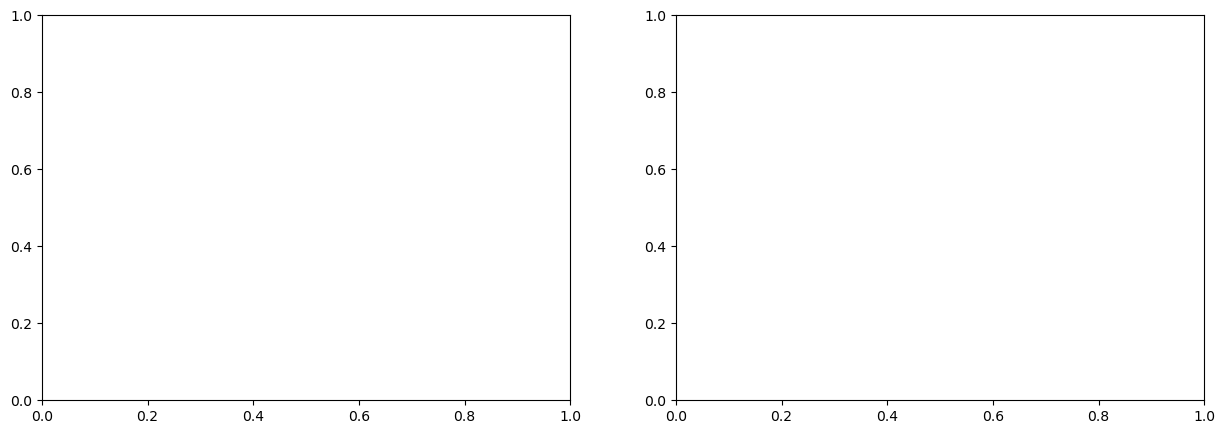

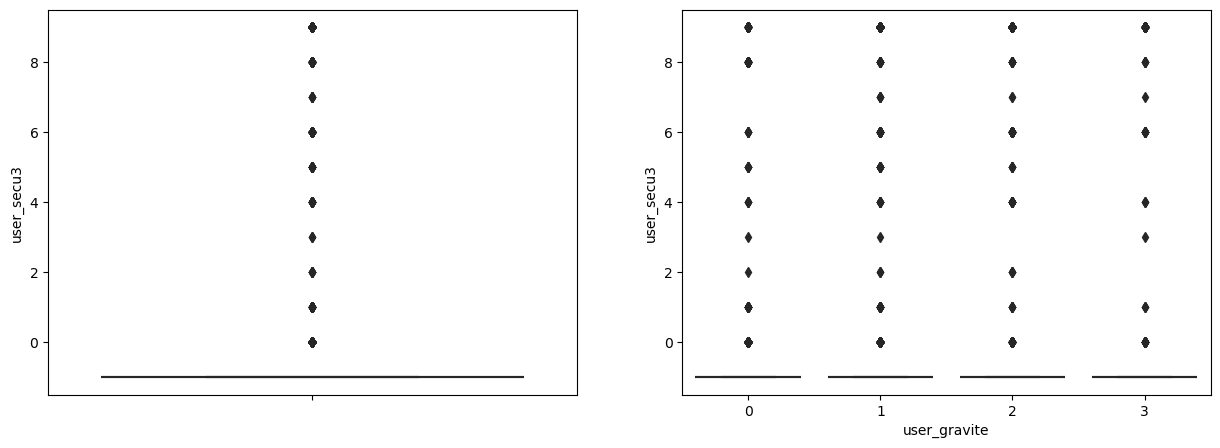

TENTATIVE OPTIMISATION PAR REGROUPEMENT BINAIRE
Tableau de contingence normalisé entre la variable et la variable cible : 


user_gravite         0         1         2         3
user_secu3                                          
-1            0.424105  0.401356  0.148512  0.026027
 0            0.373383  0.362292  0.188540  0.075786
 1            0.403226  0.435484  0.112903  0.048387
 2            0.111111  0.333333  0.555556  0.000000
 3            0.333333  0.333333  0.000000  0.333333
 4            0.135135  0.243243  0.540541  0.081081
 5            0.259259  0.518519  0.222222  0.000000
 6            0.050360  0.302158  0.546763  0.100719
 7            0.000000  0.625000  0.250000  0.125000
 8            0.675000  0.133333  0.141667  0.050000
 9            0.049645  0.275583  0.595745  0.079027


Meilleurs résultats obtenu avec taux= 4.9
Liste des modalités retenues en modalité de regroupement 1 : [0, 3, 4, 6, 7, 8, 9]
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.1

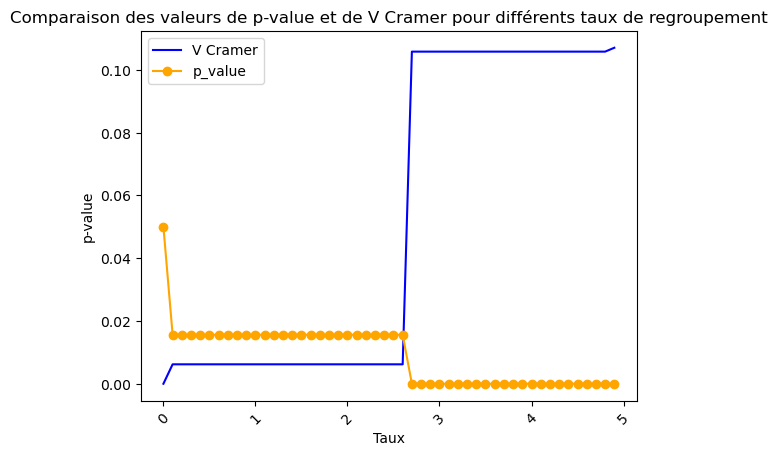

TENTATIVE OPTIMISATION PAR REGROUPEMENT NON BINAIRE

REGROUPEMENT NON BINAIRE : new_modalite= 10
Meilleurs résultats obtenu avec taux= 0.0
Liste des modalités regroupées dans la nouvelle catégorie 10 : []
Test Statistique du chi2 : p-value=0.000  ; V de Cramer=0.12037



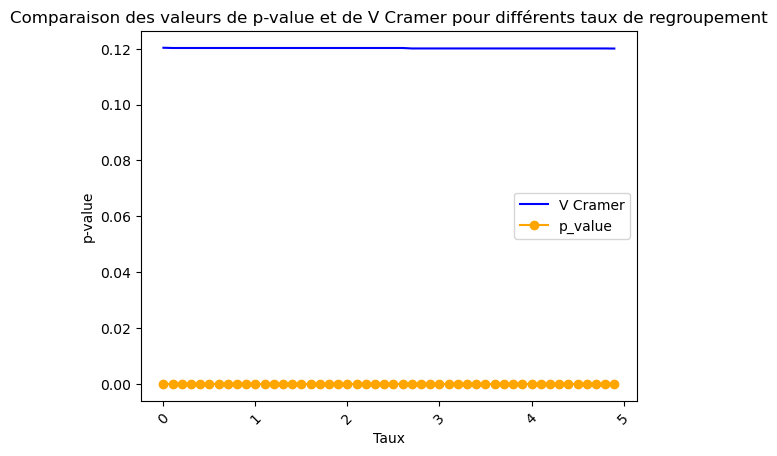


Optimisation Corrélation variable 'user_secu3':
 ==>> AUCUNE OPTIMISATION IDENTIFIEE PAR TRANSFORMATION DU REGROUPEMENT DE LA VARIBLE.



KeyError: 'user_secu3MV'

In [174]:
# -----------
# 'USER_CATU' - Catégorie d'usager
# -----------
"""
code_to_huelabel = {
    '1' : 'Conducteur',
    '2' : 'Passager',
    '3' : 'Piéton'
}

new_rgmt = analyse_variable_categorielle(train, 'user_catu', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'USER_ACTP' - Action du piéton
# -----------
"""
# 'user_actp'
code_to_huelabel = {
    '-1': 'Non renseigné',
    '0' : 'Non renseigné ou sans objet',
    '1' : 'Déplac. Sens véhi. heurtant',
    '2' : 'Déplac. Sens inverse véhi.', 
    '3' : 'Traversant',
    '4' : 'Masqué',
    '5' : 'Jouant – courant',
    '6' : 'Avec animal',
    '9' : 'Autre',
    'A' : 'Monte/descend du véhicule',
    'B' : 'Inconnue'
}

# Remplacement des code Alpha 'A' et 'B' par 10 et 11
train.user_actp  = train.user_actp.astype(str).str.replace('A', '10')
train.user_actp  = train.user_actp.astype(str).str.replace('B', '11')
train.user_actp = train.user_actp.astype(int)

# Missing Values
new_rgmt = analyse_variable_categorielle(train, 'user_actp', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'USER_ACTP' - Remplacement des missing values
train['user_actpMV'] = train.user_actp.fillna(train.user_actp.mode()[0])                      # valeur NaN si existante
train['user_actpMV'] = train.user_actp.replace(-1, train.user_actp.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'user_actpMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'USER_ACTP' - Piéton seul ou accompagné
# -----------
"""
# 'user_etatp'
code_to_huelabel = {
    '-1': 'Non renseigné',
    '0' : 'sans objet',
    '1' : 'Seul',
    '2' : 'Accompagné', 
    '3' : 'En groupe'
}

new_rgmt = analyse_variable_categorielle(train, 'user_etatp', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'USER_ETATP' - Remplacement des missing values
train['user_etatpMV'] = train.user_etatp.fillna(train.user_etatp.mode()[0])                      # valeur NaN si existante
train['user_etatpMV'] = train.user_etatp.replace(-1, train.user_etatp.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'user_etatpMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'USER_LOCP' - Localisation du piéton
# -----------
"""
# 'user_locp'
code_to_huelabel = {
    '-1': 'Non renseigné',
    '0' : 'sans objet',
    '1' : 'Chaussée à +50m PP',
    '2' : 'Chaussée à -50m PP', 
    '3' : 'PP sans signalisation',
    '4' : 'PP avec signalisation',
    '5' : 'Sur trottoir',
    '6' : 'Sur accotement',
    '7' : 'Sur refuge ou BAU',
    '8' : 'Sur contre allée',
    '9' : 'Inconnue'
}

new_rgmt = analyse_variable_categorielle(train, 'user_locp', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# 'USER_LOCP' - Remplacement des missing values
train['user_locpMV'] = train.user_locp.fillna(train.user_locp.mode()[0])                      # valeur NaN si existante
train['user_locpMV'] = train.user_locp.replace(-1, train.user_locp.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'user_locpMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'USER_PLACE' - Emplacement de la personne dans le véhicule
# -----------
"""
new_rgmt = analyse_variable_categorielle(train, 'user_place', valna=-1, liste_taux=liste_taux, viewPercent=5.0, rotation_xlabel=90)  

# 'USER_PLACE' - Remplacement des missing values
train['user_placeMV'] = train.user_place.fillna(train.user_place.mode()[0])                      # valeur NaN si existante
train['user_placeMV'] = train.user_place.replace(-1, train.user_place.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'user_placeMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# -----------
# 'USER_SECU1' - Utilisation ou non équipement de sécurité
# -----------
"""
# 'user_secu1'
new_rgmt = analyse_variable_categorielle(train, 'user_secu1', valna=-1, liste_taux=liste_taux, viewPercent=5.0, rotation_xlabel=90)  

# 'USER_SECU1' - Remplacement des missing values par la modalité la plus représentée
#train['user_secu1MV'] = train.user_secu1.fillna(train.user_secu1.mode()[0])                      # valeur NaN si existante
#train['user_secu1MV'] = train.user_secu1.replace(-1, train.user_secu1.mode()[0]).astype(int)     # valeur -1 si existante
#new_rgmt = analyse_variable_categorielle(train, 'user_secu1MV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# ==> Cramer = 0.47449

# SOLUTION 2 - on privilégie la modalité la plus représentée en tenant compte de la catégorie des véhicules
modalites = train.groupby('agg_catv_perso')['user_secu1'].agg(lambda x: x.mode().iloc[0])
train['user_secu1MV'] = train.apply(lambda row: modalites[row['agg_catv_perso']] if row['user_secu1'] == -1 else row['user_secu1'], axis=1)
new_rgmt = analyse_variable_categorielle(train, 'user_secu1MV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# ==> Cramer = 0.46811
"""

# -----------
# 'USER_SECU2' - Utilisation ou non équipement de sécurité
# -----------
"""
# 'user_secu2'
new_rgmt = analyse_variable_categorielle(train, 'user_secu2', valna=-1, liste_taux=liste_taux, viewPercent=5.0, rotation_xlabel=90)  

# 'USER_SECU2' - Remplacement des missing values par la modalité la plus représentée
#train['user_secu2MV'] = train.user_secu2.replace(-1, train.user_secu2.value_counts().index[1]).astype(int)     # valeur -1 si existante
#new_rgmt = analyse_variable_categorielle(train, 'user_secu2MV', valna=-1, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# ==> Cramer = 0.23851

# SOLUTION 2 - on privilégie la modalité la plus représentée en tenant compte de la catégorie des véhicules
modalites = train.groupby('agg_catv_perso')['user_secu2'].agg(lambda x: x.value_counts().index[1])
train['user_secu2MV'] = train.apply(lambda row: modalites[row['agg_catv_perso']] if row['user_secu2'] == -1 else row['user_secu2'], axis=1)
new_rgmt = analyse_variable_categorielle(train, 'user_secu2MV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# ==> Cramer = 0.28538
"""

# -----------
# 'USER_SECU3' - Utilisation ou non équipement de sécurité
# -----------
"""
# 'user_secu3'
new_rgmt = analyse_variable_categorielle(train, 'user_secu3', valna=-1, liste_taux=liste_taux, viewPercent=5.0, rotation_xlabel=90)  

# 'USER_SECU3' - Remplacement des missing values par la modalité la plus représentée
#train['user_secu3MV'] = train.user_secu3.replace(-1, train.user_secu3.value_counts().index[1]).astype(int)     # valeur -1 si existante
#new_rgmt = analyse_variable_categorielle(train, 'user_secu3MV', valna=-1, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# ==> Cramer = 0.038

# SOLUTION 2 - on privilégie la modalité la plus représentée en tenant compte de la catégorie des véhicules
modalites = train.groupby('agg_catv_perso')['user_secu3'].agg(lambda x: x.value_counts().index[1])
train['user_secu2MV'] = train.apply(lambda row: modalites[row['agg_catv_perso']] if row['user_secu3'] == -1 else row['user_secu3'], axis=1)
new_rgmt = analyse_variable_categorielle(train, 'user_secu3MV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  

# ==> Cramer = 0.038
"""

# -----------
# 'USER_TRAJET' - Type de trajet
# -----------
"""
# 'user_trajet'
new_rgmt = analyse_variable_categorielle(train, 'user_trajet', valna=-1, liste_taux=liste_taux, viewPercent=5.0, rotation_xlabel=90)  

# 'USER_TRAJET' - Remplacement des missing values
train['user_trajetMV'] = train.user_trajet.fillna(train.user_trajet.mode()[0])                      # valeur NaN si existante
train['user_trajetMV'] = train.user_trajet.replace(-1, train.user_trajet.mode()[0]).astype(int)     # valeur -1 si existante
new_rgmt = analyse_variable_categorielle(train, 'user_trajetMV', valna=-1, liste_taux=liste_taux, code_to_huelabel=code_to_huelabel, viewPercent=5.0, rotation_xlabel=90)  
"""

# ------------------------------------------------------------------
# MATRICE DE CORRELATION ENTRE LES VARIABLES SPECIFIQUES AUX PIETONS
# ------------------------------------------------------------------
matrice = train[[ 'user_catu', 'user_place', 'user_locp', 'user_actp', 'user_etatp']].corr()
print ("Matrice de corrélation :")
display(matrice)

plt.figure(figsize=(16,16))
sns.heatmap(matrice, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.title("Matrice de corrélation des variables 'piétons'");
plt.show();



<u>CONCLUSIONS :
- <span style="color:red">__'USER_CATU'__</span> :</u>
1. Aucune missing value
2. 3 modalités :
   - 2 modalités représentent 92%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial :  (Cramer=0.243)
   - après missing Values via modalité la plus fréquente : Cramer=

  __==> LA VARIABLE POURRA ETRE CONSERVEE EN L'ETAT__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__
  
  
- <span style="color:red">__'USER_ACTP'__</span> :</u>
1. Quelques missing values (57). 
2. 12 modalités :
   - 1 modalité représente + de 92%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable 
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.233)
   - après missing Values via modalité la plus fréquente : Cramer=0.232

  __==> TRANSFORMATION DES CODES A --> 10 et B --> 11 et FORCAGE DE LA VARIABLE EN INT__
  
  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__

  __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (RISQUE MULTI COLINEARITE)__</span>

- <span style="color:red">__'USER_ETATP'__</span> :</u>
1. Quelques missing values (361). 
2. 4 modalités :
   - 1 modalité représente 92%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.229)
   - après missing Values via modalité la plus fréquente : Cramer=0.227
  
  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__

  __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (RISQUE MULTI COLINEARITE)__</span>


- <span style="color:red">__'USER_LOCP'__</span> :
1. Quelques missing values (61). 
2. 10 modalités :
   - 1 modalité représentent + de 92%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.241)
   - après missing Values via modalité la plus fréquente : Cramer=0.240

  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__

  __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (RISQUE MULTI COLINEARITE)__</span>


- <span style="color:red">__'USER_PLACE'__</span> :
1. Quelques missing values (3). 
2. 10 modalités :
   - 2 modalités représentent + de 85%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable 
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.24850)
   - après missing Values via modalité la plus fréquente : Cramer=0.24847
 
  __==> REMPLACEMENT DES MISSING VALUES PAR LA MODALITE LA PLUS REPRESENTEE OU MAINTIEN DE LA CATEGORIE '-1'__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__
  

-  <span style="color:red">__'USER_SECU1'__</span> :
1. 1% de missing values (3946).
   - Le remplacement via la modalité la plus fréquente impacte légèrement le test de Cramer (0.47449)
   - Le remplacement via la modalité la plus f. en tenant compte de la catégorie de véhicule impacte encore plus le test de Cramer (0.46811)
     
2. 10 modalités : :
   - 3 modalités représentent + de 87%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.48324)
   - après missing Values via modalité la plus fréquente : Cramer=0.47449
  
  __==> LA VARIABLE POURRA ETRE CONSERVEE EN L'ETAT__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__
  

- <span style="color:red">__'USER_SECU2'__</span> :
1. 42% de missing values (114704)
   - Le remplacement par la modalité la plus fréquente impacte le test de Cramer (0.23851)
   - idem si l'on réalise le remplacement en tenant compte des catégories de véhicules (0.28538)
2. 10 modalités :
   - 2 modalités représentent + de 84%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.329)
   - après missing Values via modalité la plus fréquente : Cramer=0.23851 - cette méthode impacte le test de Cramer 


  __==> LA VARIABLE POURRA ETRE CONSERVEE EN L'ETAT__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__
  

-  <span style="color:red">__'USER_SECU3'__</span> :
1. 99% de missing values (267797) : même constat pour les remplacements des missing value ==> maintien de la catégorie '-1'
2. 10 modalités :
   - 1 modalité représente 99%
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : (Cramer=0.120)
   - après missing Values via modalité la plus fréquente : Cramer=
  
  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__

  __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (si l'on retient le test SMOTE)__</span>


-  <span style="color:red">__'USER_TRAJET'__</span> :
1. 27% de missing values (73665)
2. 6 modalités :
   - 4 modalités représentent + de 80% (dont missing values)
   - Modalités non ordonnées : un encodage sera nécessaire si maintien de la variable
3. Le test statistique du chi2 donne une p-value proche de 0%  ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le test de Cramer (+ Chi2) :
   - df initial : Il semble indiquer que cette corrélation semble assez faible malgré tout (Cramer=0.19506)
   - après missing Values via modalité la plus fréquente : Cramer=0.16563 - Cette méthode impacte légèrement le test de Cramer

  __==> MAINTIEN DE LA VARIABLE SUR CATEGORISATION -1__

  __==> UN ONE HOT ENCODAGE SERA NECESSAIRE SI MAINTIEN DE LA VARIABLE__


&#8195;


## ETAPE 7 - ANALYSE DES <span style="color:red">VARIABLES QUANTITATIVES</span>
- Test de Anova réalisée pour chaque variable avec la variable cible
- Calcul du coef de corrélation (via matrice de corrélation) : très faible corrélation quasi systématiquement constaté

- 2 variables sont légèrement plus corrélées (coéf de corrélation dépasse légèrement 0.15)

- Relance de l'analyse sur dataset équilibré --> les résultats évoluent : faut-il faire ce genre d'analyse directement sur dataset équilibré ?


### &#8195;
<u> <span style="color:blue">ETAPE 7.1 - Initialisation</span></u>

PERMET de définir les plages de taux ainsi que le dataset (initial, rééquilibré (SMOTE) ou rééquilibré (OverRandomSampling) à privilégier

In [1145]:
# ANALYSE SUR DATASET INITIAL
train = save_train.copy()

# ANALYSE SUR DATASET REEQUILIBRE VIA SMOTE
#train = x_train_smote.copy()

# ANALYSE SUR DATASET REEQUILIBRE VIA SMOTE
#train = x_train_ro.copy()

# Variable cible --> Suppression des missings values (normalement fait précédemment à l'étape d'analyse de la variable cible)
train = train[(train.user_gravite != -1)]



### &#8195;
<u> <span style="color:blue">ETAPE 7.2 - Fichier 'CARAC'</span></u> - Analyse détaillée de :

   - <span style="color:red">__'CARAC_GPS_LAT'__</span></u> : Coordonnées gps - Latitude
   - <span style="color:red">__'CARAC_GPS_LONG'__</span></u> : Coordonnées gps - Longitude




Il y a 0.0% (0) de données manquantes (ou assimilées).

Statistiques de la variable : 

count    270717.000000
mean         44.237578
std          12.432952
min         -23.868998
25%          44.629000
50%          47.805409
75%          48.860800
max          51.077465
Name: carac_gps_lat, dtype: float64



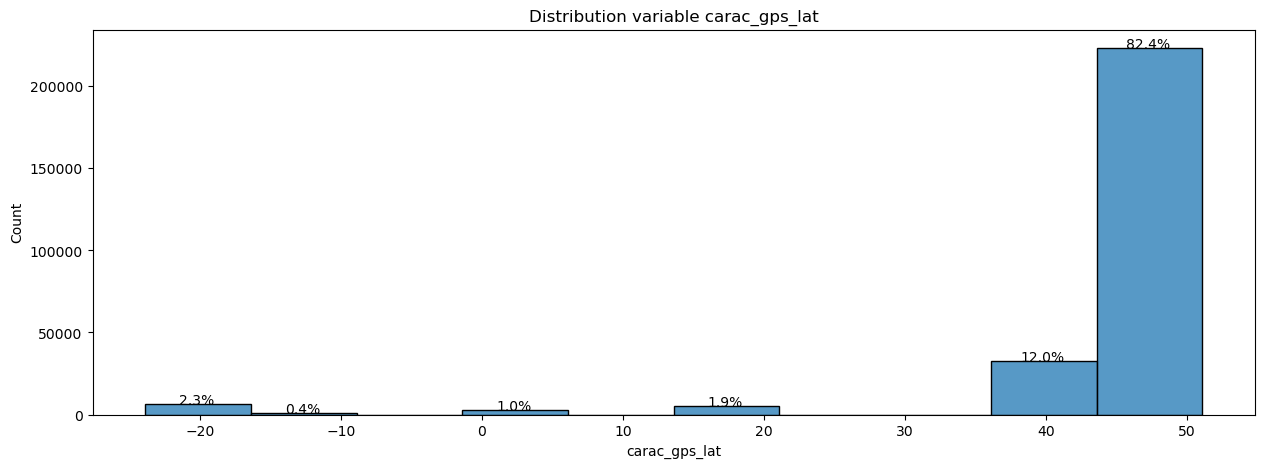


Test statistique ANOVA - PR(>F)=0.00000



,df,sum_sq,mean_sq,F,PR(>F)
carac_gps_lat,1.0,122.677927,122.677927,193.954567,4.512479e-44
Residual,270715.0,171229.558653,0.632509,NaN,NaN


Matrice de corrélation :  (coef=-0.027)


,carac_gps_lat,user_gravite
carac_gps_lat,1.000000,-0.026757
user_gravite,-0.026757,1.000000


Outliers=
-> Q1= 44.629 - Q3= 48.8608 - IQR= 4.2318 - Borne inf= 38.2813 - Borne sup= 55.2085
-> Outlier(s) inférieur(s) - min= -23.868998 - max= 18.099722 - nb= 15129
[-23.868998 -23.868998 -23.39509  ...  18.09958   18.099722  18.099722]
-> Outlier(s) supérieur(s) - min= nan - max= nan Outliers nb= 0
[]


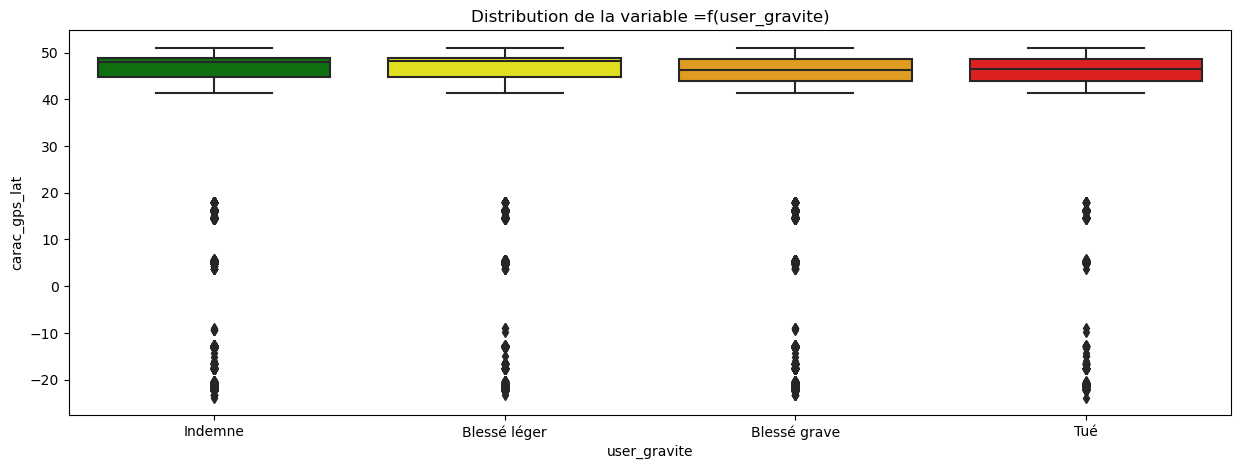


Il y a 0.0% (1) de données manquantes (ou assimilées).

Statistiques de la variable (hors valeur nan): 

count    270716.000000
mean          2.499851
std          19.807460
min        -178.158090
25%           1.374493
50%           2.399958
75%           4.828750
max         168.106549
Name: carac_gps_long, dtype: float64



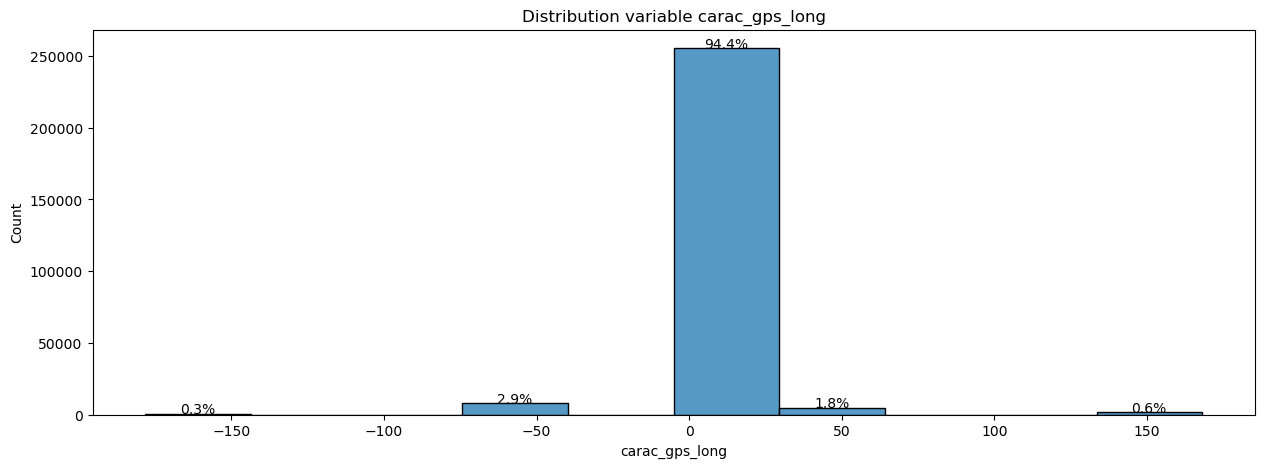

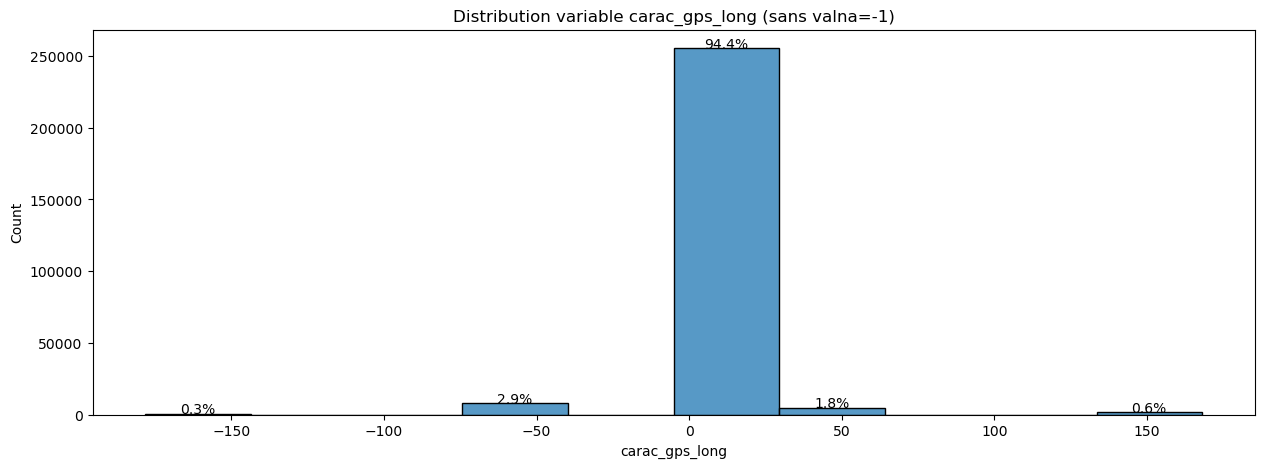


Test statistique ANOVA (avec valna)- PR(>F)=0.00012


Test statistique ANOVA (sans valna)- PR(>F)=0.00012



,df,sum_sq,mean_sq,F,PR(>F)
carac_gps_long,1.0,9.330920,9.330920,14.742433,0.000123
Residual,270714.0,171342.859076,0.632929,NaN,NaN


Matrice de corrélation :  (coef=-0.007)


,carac_gps_long,user_gravite
carac_gps_long,1.00000,-0.00738
user_gravite,-0.00738,1.00000


Outliers=
-> Q1= 1.374493 - Q3= 4.82875 - IQR= 3.454257 - Borne inf= -3.8068925 - Borne sup= 10.0101355
-> Outlier(s) inférieur(s) - min= -178.15809 - max= -3.807331 - nb= 11696
[-178.15809  -178.15809  -178.085795 ...   -3.809831   -3.807331
   -3.807331]
-> Outlier(s) supérieur(s) - min= 45.051177 - max= 168.106549 Outliers nb= 6627
[ 45.051177  45.051177  45.051177 ... 168.106549 168.106549 168.106549]


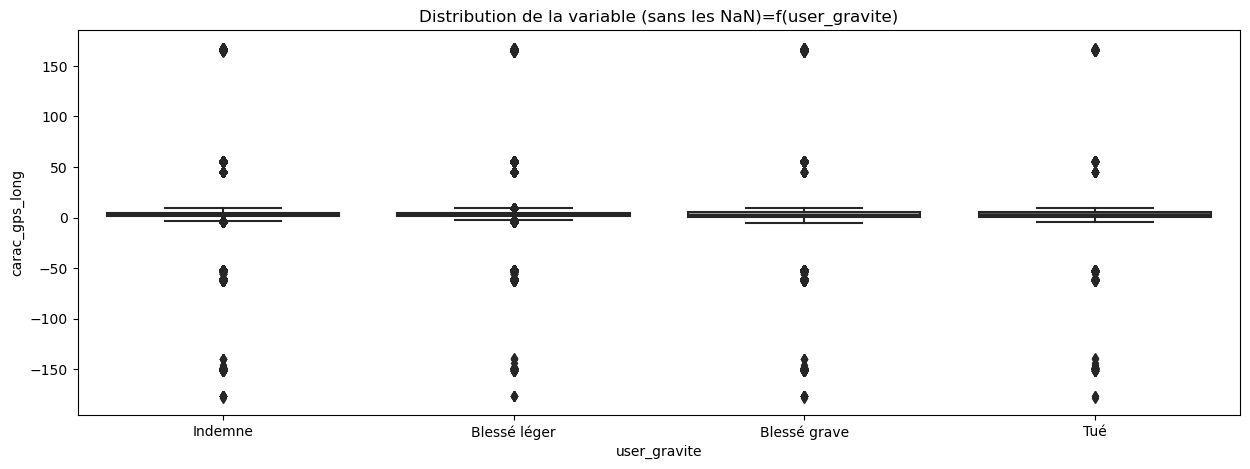

In [263]:
# ---------------
# 'CARAC_GPS_LAT'
# ---------------
analyse_variable_quantitative(train, x='carac_gps_lat', cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# ----------------
# 'CARAC_GPS_LONG'
# ----------------
analyse_variable_quantitative(train, x='carac_gps_long', cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)



<u>CONCLUSION 
- <span style="color:red">__'CARAC_GPS_LAT'__</span> :</u>
1. Aucune valeurs manquantes
2. Beaucoup d'outliers < Q1 : il s'agit des des accidents sur les dom : il s'agit d'une situation normale qu'il faut conserver.
3. Le test statistique de ANOVA donne une p-value proche de 0% ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le coéf de corrélation :
   - avec la variable cible non rééquilibrée=0.026

  __==> SI MAINTIEN DE LA VARIABLE, ELLE POURRA L'ETRE EN L'ETAT (SANS TRANSFORMATION)__

  __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (TROP FAIBLE CORRELATION)__</span>

- <span style="color:red">__'CARAC_GPS_LONG'__</span> :</u>
1. Aucune valeurs manquantes
2. Beaucoup d'outliers < Q1 et > Q3 : il s'agit des des accidents sur les dom : il s'agit de valeurs normale qu'il faut conserver.
3. Le test statistique de ANOVA donne une p-value proche de 0% ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le coéf de corrélation
   - avec la variable cible avant rééquilibrage=0.007

  __==> SI MAINTIEN DE LA VARIABLE, ELLE POURRA L'ETRE EN L'ETAT (SANS TRANSFORMATION)__

  __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (TROP FAIBLE CORRELATION)__</span>


&#8195;

### &#8195;
<u> <span style="color:blue">ETAPE 7.3 - Fichier 'LIEU'</span></u> - Analyse détaillée de :
   - <span style="color:red">__'LIEU_LARROUT'__</span> : Largeur de la chaussée affectée à la circulation
   - <span style="color:red">__'LIEU_LARTPC'__</span> : Largeur du terre-plein central
   - <span style="color:red">__'LIEU_NBV'__</span></u> : Nombre de voies
   - <span style="color:red">__'LIEU_VMA'__</span></u> : Vitesse maximale autorisée

Nomenclature :
   - carac_agg : 1=Hors agglo, 2=en agglo
   - lieu_catr : 1=autoroute, 2=Nationale, 3, Départementale, 4=voie communale, ...



Il y a 1.5% (3949) de données manquantes (ou assimilées).

Statistiques de la variable (hors valeur nan): 

count    266768.000000
mean         61.391617
std          24.891525
min           1.000000
25%          50.000000
50%          50.000000
75%          80.000000
max         900.000000
Name: lieu_vma, dtype: float64



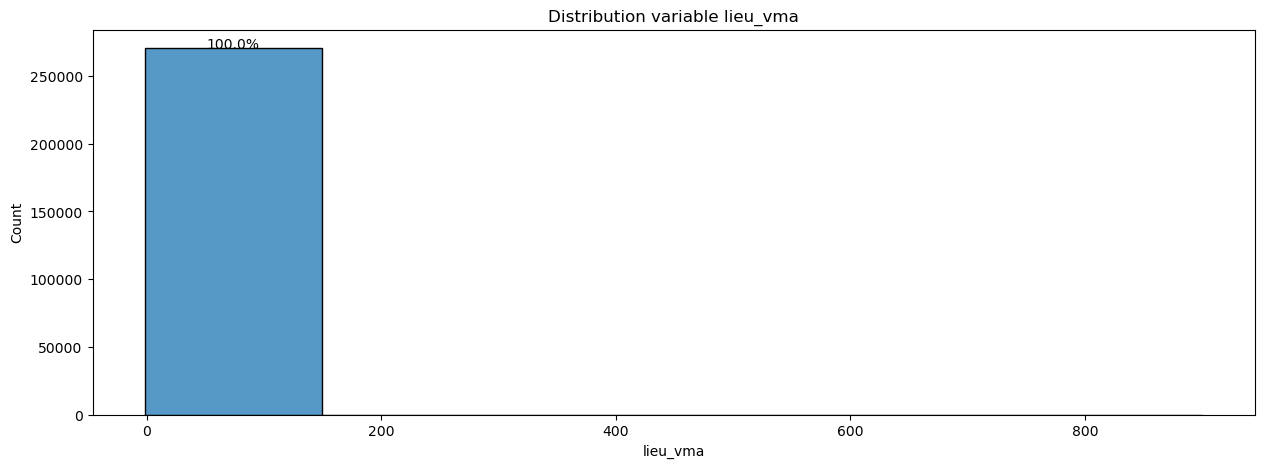

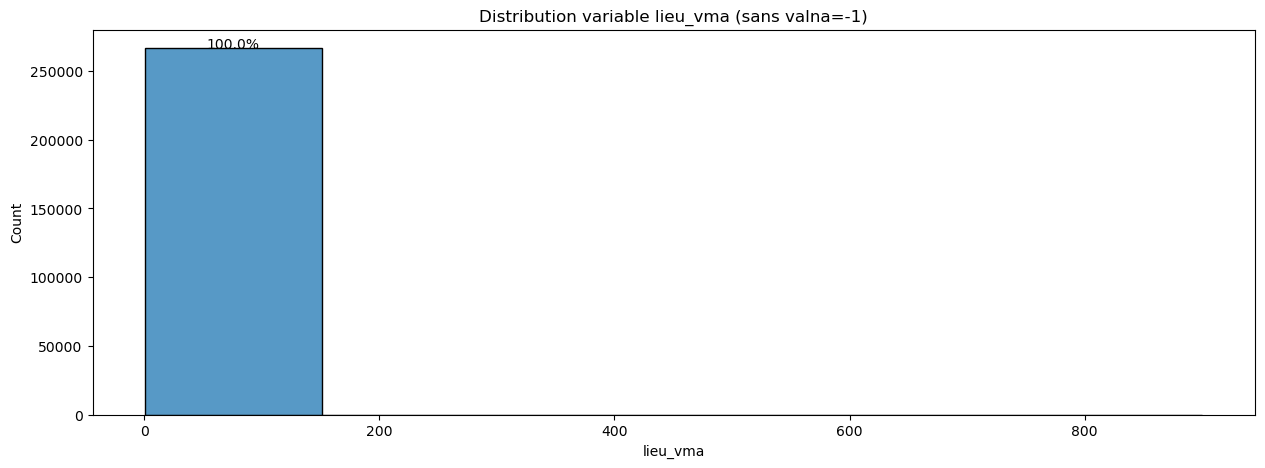


Test statistique ANOVA (avec valna)- PR(>F)=0.00000


Test statistique ANOVA (sans valna)- PR(>F)=0.00000



,df,sum_sq,mean_sq,F,PR(>F)
lieu_vma,1.0,1029.476056,1029.476056,1647.156066,0.0
Residual,266766.0,166729.319298,0.625002,NaN,NaN


Matrice de corrélation :  (coef=0.064)


,lieu_vma,user_gravite
lieu_vma,1.000000,0.064398
user_gravite,0.064398,1.000000


Outliers=
-> Q1= 50.0 - Q3= 80.0 - IQR= 30.0 - Borne inf= 5.0 - Borne sup= 125.0
-> Outlier(s) inférieur(s) - min= 1.0 - max= 4.0 - nb= 121
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4.
 4.]
-> Outlier(s) supérieur(s) - min= 130.0 - max= 900.0 Outliers nb= 7168
[130. 130. 130. ... 900. 900. 900.]


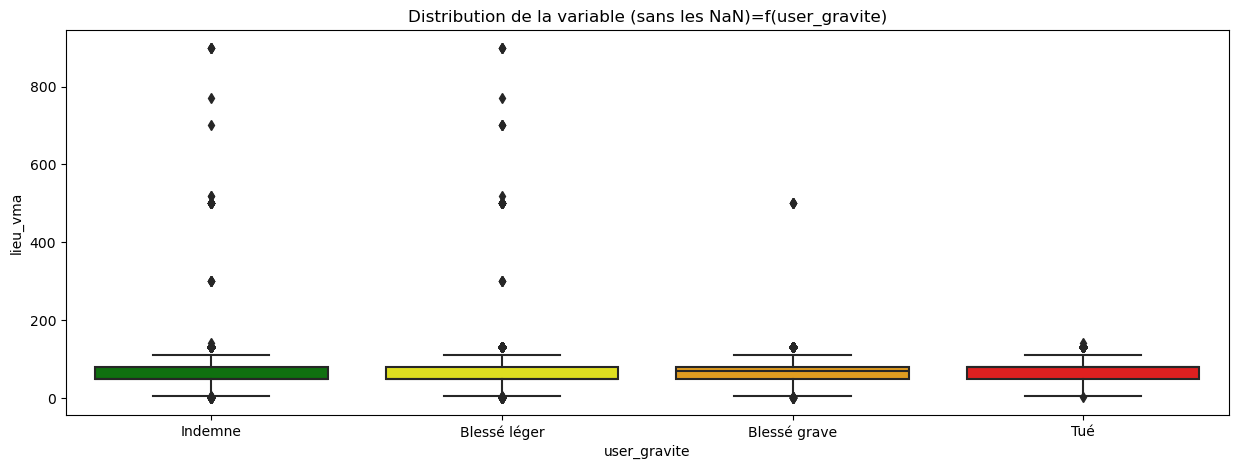

lieu_catr
1    7070
2       6
3       5
Name: count, dtype: int64

carac_agg  user_gravite
1          0               3
           1               2
           2               2
2          1               2
           0               1
           3               1
Name: count, dtype: int64

,id_accident,id_vehicule,num_veh,carac_an,carac_mois,carac_jour,carac_hrmn,carac_agg,carac_atm,carac_col,carac_com,carac_dept,carac_gps_lat,carac_gps_long,carac_int,carac_lum,lieu_catr,lieu_circ,lieu_infra,lieu_larrout,lieu_lartpc,lieu_nbv,lieu_plan,lieu_prof,lieu_situ,lieu_surf,lieu_vma,lieu_vosp,vehi_catv,vehi_choc,vehi_manv,vehi_motor,vehi_obs,vehi_obsm,vehi_occutc,vehi_senc,user_an_nais,user_catu,user_actp,user_etatp,user_locp,user_place,user_secu1,user_secu2,user_secu3,user_sexe,user_trajet,user_gravite,agg_catv_perso,agg_is_conducteur_vehicule,agg_is_conductrice_vehicule,agg_nb_pieton_vehicule,agg_nb_passager_vehicule,agg_nb_indemne_vehicule,agg_nb_blesse_leger_vehicule,agg_nb_blesse_grave_vehicule,agg_nb_tue_vehicule,agg_nb_total_vehicule,agg_nb_total_velo,agg_nb_total_vsp,agg_nb_total_moto,agg_nb_total_vl,agg_nb_total_pl,agg_nb_total_va,agg_nb_total_conducteur,agg_nb_total_conductrice,agg_nb_total_pieton,agg_nb_total_passager,carac_atmMV,carac_colMV,carac_intMV,carac_lumMV,lieu_circMV,lieu_infraMV,lieu_planMV,lieu_profMV,lieu_situMV,lieu_surfMV,lieu_vospMV,vehi_chocMV,vehi_manvMV,vehi_motorMV,vehi_obsMV,vehi_obsmMV,user_actpMV,user_etatpMV,user_locpMV,user_placeMV,user_secu1MV,user_secu2MV,lieu_vma2,lieu_vmaMV,user_an_naisMV
159606,202100046618,118438,A01,2021,3,24,850,2,1,6,101.0,14,49.166810,-0.428920,1,1,2,3,0,-1.0,0.0,4,1,1,1,1,130.0,0,7,7,1,1.0,3,0,0,1.0,2019.0,2,0,0,0,3,3,0,-1,2,5,1,4,0,1,0,1,0,2,0,0,1,0,0,0,1,0,0,0,1,0,1,1,6,1,1,3,0,1,1,1,1,0,7,1,1,3,0,0,0,0,3,3,0,130.0,50.0,2019.0
159607,202100046618,118438,A01,2021,3,24,850,2,1,6,101.0,14,49.166810,-0.428920,1,1,2,3,0,-1.0,0.0,4,1,1,1,1,130.0,0,7,7,1,1.0,3,0,0,1.0,1996.0,1,0,0,0,1,1,0,-1,2,5,1,4,0,1,0,1,0,2,0,0,1,0,0,0,1,0,0,0,1,0,1,1,6,1,1,3,0,1,1,1,1,0,7,1,1,3,0,0,0,0,1,1,0,130.0,50.0,1996.0
181747,202200003073,808525,B01,2022,8,7,1040,2,1,3,155.0,45,47.686312,2.654207,8,1,3,2,4,4.0,0.0,2,1,1,6,1,130.0,0,39,3,1,3.0,0,4,0,0.0,1973.0,1,0,0,0,1,8,-1,-1,1,4,0,6,1,0,0,0,1,0,0,0,2,0,0,0,1,0,1,1,1,0,0,1,3,8,1,2,4,1,1,6,1,0,3,1,3,0,4,0,0,0,1,8,0,130.0,50.0,1973.0
181748,202200003073,808526,A01,2022,8,7,1040,2,1,3,155.0,45,47.686312,2.654207,8,1,3,2,4,4.0,0.0,2,1,1,6,1,130.0,0,7,6,15,1.0,5,4,0,1.0,2003.0,1,0,0,0,1,1,-1,-1,2,5,3,4,0,1,0,0,0,0,0,1,2,0,0,0,1,0,1,1,1,0,0,1,3,8,1,2,4,1,1,6,1,0,6,15,1,5,4,0,0,0,1,1,0,130.0,50.0,2003.0


carac_agg  lieu_catr
1          3            1351
2          3             807
           4             399
1          4             312
           2             271
           1             255
2          6             163
           2              99
1          9              65
2          7              54
           9              51
1          7              45
2          1              32
1          5              25
           6              13
2          5               7
Name: count, dtype: int64


Il y a 0.0% (0) de données manquantes (ou assimilées).

Statistiques de la variable : 

count    270717.000000
mean         61.319015
std          23.116146
min          10.000000
25%          50.000000
50%          50.000000
75%          80.000000
max         130.000000
Name: lieu_vmaMV, dtype: float64



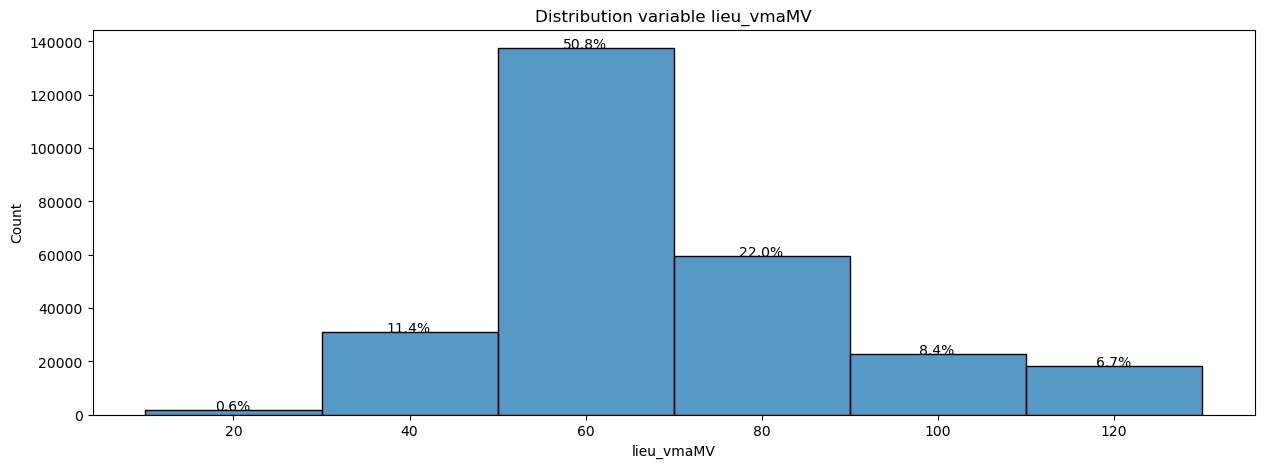


Test statistique ANOVA - PR(>F)=0.00000



,df,sum_sq,mean_sq,F,PR(>F)
lieu_vmaMV,1.0,1238.410404,1238.410404,1970.776156,0.0
Residual,270715.0,170113.826176,0.628387,NaN,NaN


Matrice de corrélation :  (coef=0.085)


,lieu_vmaMV,user_gravite
lieu_vmaMV,1.000000,0.085013
user_gravite,0.085013,1.000000


Outliers=
-> Q1= 50.0 - Q3= 80.0 - IQR= 30.0 - Borne inf= 5.0 - Borne sup= 125.0
-> Outlier(s) inférieur(s) - min= nan - max= nan - nb= 0
[]
-> Outlier(s) supérieur(s) - min= 130.0 - max= 130.0 Outliers nb= 7077
[130. 130. 130. ... 130. 130. 130.]


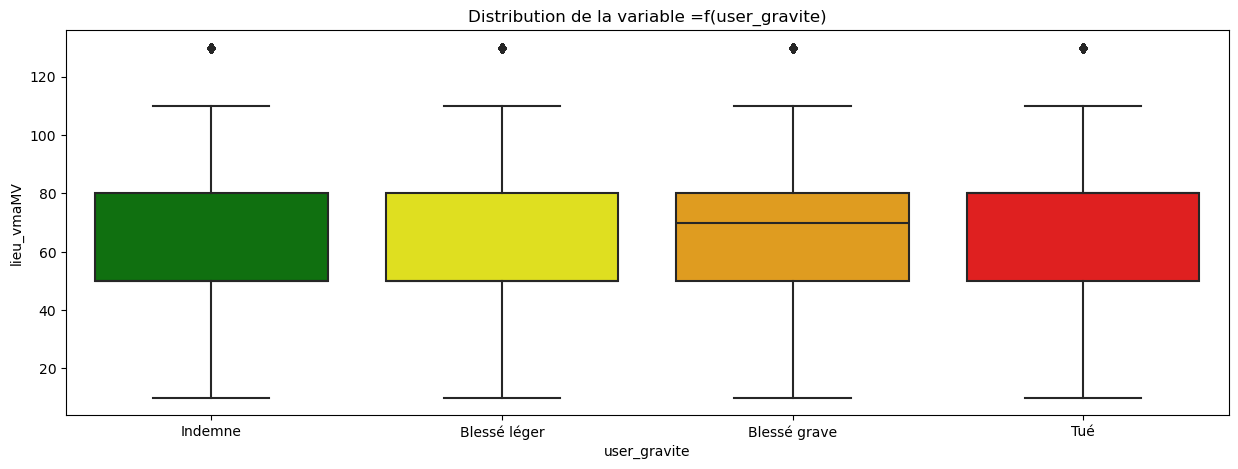

In [288]:
## -------------
## 'LIEU_LARROUT'
## -------------

#analyse_variable_quantitative(train, x='lieu_larrout', cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

## Répartition des valeurs
#display(train.lieu_larrout.value_counts())        # 255000 valeurs considérées comme manquante

## Analyse des outliers > 10 = f(catégorie de la route)
#display(train[train.lieu_larrout>10]['lieu_catr'].value_counts(normalize=True))

## ==> Beaucoup d'autoroutes ce qui semble cohérent

## Analyse des outliers > 10 = f(nb de voies)
#display(train[train.lieu_larrout>10]['lieu_nbv'].value_counts())
## ==> Hormis 4 cas avec un nombre de voie de 1 ==> la situation semble normale

## -------------
## 'LIEU_LARTPC'
## -------------
"""
analyse_variable_quantitative(train, x='lieu_lartpc', bins=10, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

## Répartition des valeurs
#display(train.lieu_lartpc.value_counts())    

## Analyse des outliers (135 au total) > 2.5 = f (catégorie de la route)
#display(train[train.lieu_lartpc>2.5]['lieu_catr'].value_counts(normalize=True)) ## ==> Beaucoup de départementale (42%) 
#display(train[train.lieu_lartpc>2.5]['lieu_nbv'].value_counts())                ## ==> Emplacement avec majoritairement 3 voies et +
"""
## ----------
## 'LIEU_NBV'
## ----------
"""
analyse_variable_quantitative(train, x='lieu_nbv', bins=6, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

## Répartition des valeurs
display(train.lieu_nbv.value_counts())    

## Analyse des outliers > 5 = f (catégorie de la route)
#train[train.lieu_nbv>6]['lieu_catr'].value_counts(normalize=True)

## ==> 70% correspond à des autoroutes ce qui semble cohérent (le reste ne représente que 1200 enregistrements)
"""
## ----------
## 'LIEU_VMA'
## ----------

analyse_variable_quantitative(train, x='lieu_vma', bins=6, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

## Répartition des valeurs
#display(train.lieu_vma.value_counts())   

## Analyse des Outliers : il semble y avoir des erreurs de saisie
##   - Les valeurs < 10 seront multipliées par 10
##   - Les valeurs > 130 seront divisées par 10
train['lieu_vma2'] = train.lieu_vma.apply(lambda valeur : valeur*10 if (valeur > 0) and (valeur < 10) else valeur/10 if valeur > 130 else valeur)

## C'est le cas pour plus de 99% des outliers (11 enregs non associés à une autoroute
## ==> décision de basculer les 1% restant sur 110 si carac_agg=1 (Hors agglo)
## ==> Pour les 4 enregistrements identifiés en agglo, dans la mesure où il y a un décès associé à l'un d'entre eu ==> focus sur le car 
## pour retrouver la valeur exacte de la limitation

display(train[train.lieu_vma2>=130]['lieu_catr'].value_counts())
display(train[(train.lieu_vma2>=130) & (train.lieu_catr != 1)][['carac_agg', 'user_gravite']].value_counts())
## Accident mortel identifié en agglo à 130 km/h
display(train[(train.lieu_vma2==130) & (train.lieu_catr != 1) & (train.carac_agg != 1)].head(15))

## carac_agg = 1 (hors agglo) ==> 7 enregistrements forcés à 110 (suposition erreur de saisie d'un caractère 130 --> 110
## carac_agg = 2 (agglo) ==> 4 : il s'agit de 2 accidents distincts : analyse par géolocalisation : pour l'un, la limite de 50km/h est évidente
## pour l'autre c'est plus subtil --> décision de forcer malgré tout les deux vitesses à 50km/h
train['lieu_vma2'] = train.apply(lambda row : 50 if (row['lieu_vma2']==130) and (row['lieu_catr'] != 1) and (row['carac_agg'] == 2) else row['lieu_vma2'], axis=1)
#analyse_variable_quantitative(train, x='lieu_vma2', bins=6, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)
## ==> Résultats probants --> à automatiser via une transformation 

## Analyse des missing values
display(train[(train.lieu_vma2==-1)][['carac_agg','lieu_catr']].value_counts())

## Remplacement des missing values à partir des modalités les plus fréquentes via clé carac_agg et lieu_catr
mode_lieu_vma = train[train['lieu_vma2'] != -1].groupby(['carac_agg', 'lieu_catr'])['lieu_vma2'].agg(lambda x: x.value_counts().idxmax())

## Fonction pour remplacer lieu_vma == -1 par la modalité la plus fréquente
def replace_lieu_vma(row, mode_lieu_vma):
    if row['lieu_vma'] == -1:
        return mode_lieu_vma.get((row['carac_agg'], row['lieu_catr']), row['lieu_vma2'])
    return row['lieu_vma2']

## Appliquer la fonction de remplacement
train['lieu_vmaMV'] = train.apply(lambda row: replace_lieu_vma(row, mode_lieu_vma), axis=1)

## Controle post reprise des missing values
analyse_variable_quantitative(train, x='lieu_vmaMV', bins=6, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)


<u>CONCLUSION 

- <span style="color:red">__'LIEU_LARROUT'__</span> :</u>
1. Plus de 93.9% de valeurs manquantes (254156)
2. Aucune transformation à prévoir (pas de missing value et variable binaire)
3. Le test statistique du chi2 donne une p-value proche de 0% ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le coéf de corrélation :
   - avec la variable cible non rééquilibrée=0.034 (très faible)
   - avec variable cible rééquilibrée=0.056

  __==> LA VARIABLE POURRA ETRE CONSERVEE EN L'ETAT COMME VARIABLES EXPLICATIVES__
  
  __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (TROP FAIBLE CORRELATION)__</span>


- <span style="color:red">__'LIEU_LARTPC'__</span> :</u>
1. Aucune valeur manquante
2. Aucune transformation à prévoir (pas de missing value et variable binaire)
3. Le test statistique du chi2 donne une p-value proche de 0% ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le coéf de corrélation :
   - avec la variable cible non rééquilibrée=0.0 (très faible)
   - avec variable cible rééquilibrée=0.005

  __==> LA VARIABLE POURRA ETRE CONSERVEE EN L'ETAT COMME VARIABLES EXPLICATIVES__
  
  __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (TROP FAIBLE CORRELATION)__</span>

  
- <span style="color:red">__'LIEU_NBV'__</span> :</u>
1. Plus de 0.89% de valeurs manquantes (2518)
2. Aucune transformation à prévoir (pas de missing value et variable binaire)
3. Le test statistique du chi2 donne une p-value proche de 0% ==> hypothèse nulle est rejetée (les variables semblent dépendantes statistiquement)
4. Le coéf de corrélation :
   - avec la variable cible non rééquilibrée=0.068 (très faible)

  __==> LA VARIABLE POURRA ETRE CONSERVEE EN L'ETAT COMME VARIABLES EXPLICATIVES__
  
  __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (TROP FAIBLE CORRELATION)__</span>
  
  
<span style="color:red">__'LIEU_VMA'__</span> :</u>
1. 1.5% de valeurs manquantes (3949)
2. Analyse des outliers : Plusieurs outliers à corriger (erreurs de saisie)
3. Reprise des missing values :
   - à partir de la catégorie de voie et l'indicateur agglo O/N : on privilégiera la modalité la plus fréquente
   - Par souci de cohérence, on va forcer les -1 --> 0 : non renseigné
4. Le test statistique du ANOVA donne une p-value proche de 0%
5. Le coéf de corrélation :
   - avec la variable cible non rééquilibrée=0.064 (très faible)

  __==> APPLICATION REGLES DE CORRECTION DES OUTLIERS__

  __==> APPLICATION REGLE DE MISE A JOUR DES MISSING VALUES__

  __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (TROP FAIBLE CORRELATION)__</span>
  
&#8195;

### &#8195;
<u> <span style="color:blue">ETAPE 7.4 - Fichier 'USER'</span></u> - Analyse détaillée de :
- <span style="color:red">__'USER_AN_NAIS'__</span> : Année de naissance de l'usager



Il y a 1.6% (4245) de données manquantes (ou assimilées).

Statistiques de la variable : 

count    266472.000000
mean       1982.778994
std          18.830455
min        1900.000000
25%        1970.000000
50%        1986.000000
75%        1998.000000
max        2022.000000
Name: user_an_nais, dtype: float64



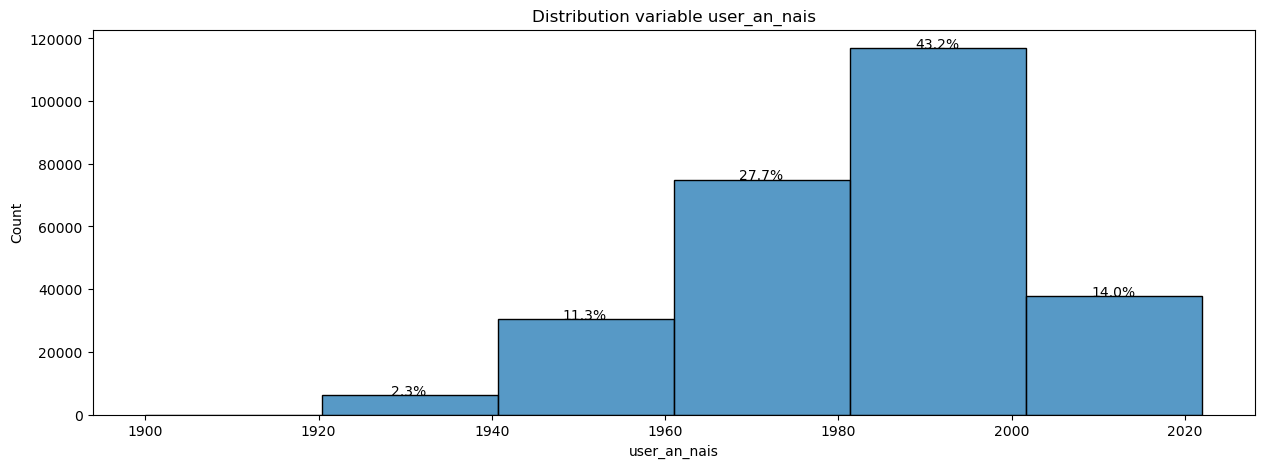


Test statistique ANOVA - PR(>F)=0.00000



,df,sum_sq,mean_sq,F,PR(>F)
user_an_nais,1.0,26.844279,26.844279,42.408538,7.419693e-11
Residual,266470.0,168673.465847,0.632992,NaN,NaN


Matrice de corrélation :  (coef=-0.013)


,user_an_nais,user_gravite
user_an_nais,1.000000,-0.012614
user_gravite,-0.012614,1.000000


Outliers=
-> Q1= 1970.0 - Q3= 1998.0 - IQR= 28.0 - Borne inf= 1928.0 - Borne sup= 2040.0
-> Outlier(s) inférieur(s) - min= 1900.0 - max= 1927.0 - nb= 245
[1900. 1900. 1900. 1900. 1900. 1900. 1900. 1900. 1900. 1900. 1900. 1900.
 1910. 1910. 1910. 1913. 1913. 1913. 1920. 1920. 1920. 1921. 1921. 1921.
 1921. 1922. 1922. 1922. 1922. 1923. 1923. 1923. 1923. 1923. 1923. 1923.
 1923. 1923. 1923. 1923. 1923. 1923. 1923. 1923. 1924. 1924. 1924. 1924.
 1924. 1924. 1924. 1924. 1924. 1924. 1924. 1924. 1924. 1924. 1924. 1924.
 1924. 1924. 1924. 1924. 1924. 1925. 1925. 1925. 1925. 1925. 1925. 1925.
 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925.
 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925.
 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1926. 1926.
 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926.
 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926.
 1926. 1926. 1926. 1926. 1926. 1926. 1926. 

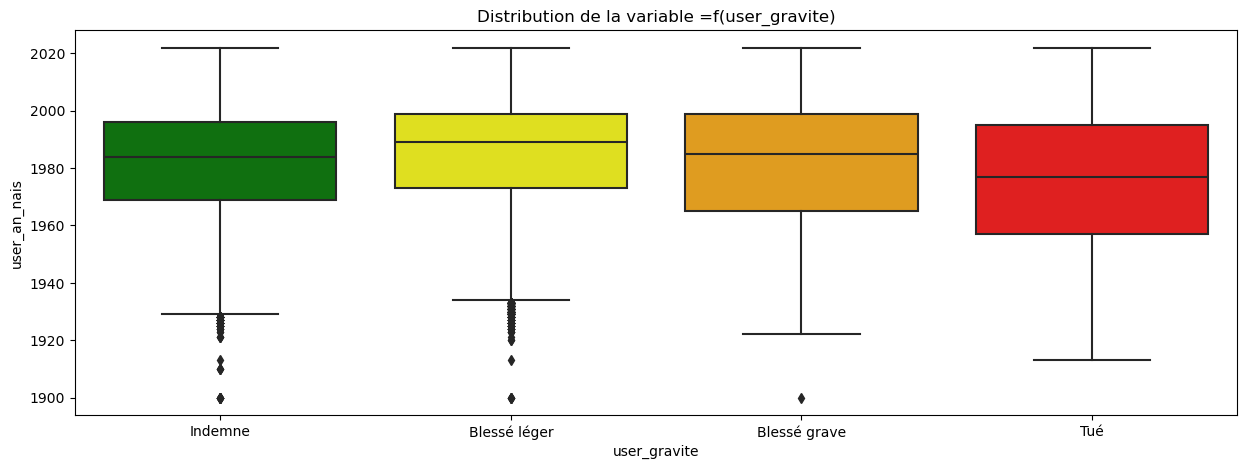

user_an_nais
2000.0    8314
2001.0    8113
1999.0    7767
2002.0    7250
1998.0    7174
1997.0    6751
1996.0    6380
1995.0    6290
1994.0    5953
2003.0    5737
1992.0    5665
1993.0    5651
1990.0    5497
1991.0    5435
1989.0    5227
1988.0    5151
1987.0    4995
1986.0    4829
1985.0    4707
1984.0    4482
1982.0    4307
2004.0    4303
1980.0    4284
1983.0    4255
1981.0    4106
1979.0    4018
1972.0    3888
1973.0    3874
1977.0    3798
1978.0    3731
1971.0    3710
1974.0    3701
1976.0    3643
1970.0    3637
1975.0    3565
1969.0    3546
1968.0    3468
1966.0    3413
2005.0    3402
1967.0    3370
1965.0    3226
1964.0    3218
1963.0    3104
1962.0    2888
1961.0    2767
2006.0    2574
1960.0    2549
1959.0    2310
1958.0    2151
1957.0    1980
1956.0    1822
2007.0    1768
1954.0    1719
1955.0    1688
1952.0    1565
1953.0    1541
1951.0    1481
1950.0    1479
1949.0    1462
2008.0    1420
1947.0    1402
1948.0    1380
1946.0    1323
2009.0    1270
2010.0    1117
1945.0    10

,user_an_nais,user_gravite
user_an_nais,1.000000,-0.012614
user_gravite,-0.012614,1.000000



Il y a 0.0% (0) de données manquantes (ou assimilées).

Statistiques de la variable : 

count    270717.000000
mean       1983.049029
std          18.804342
min        1900.000000
25%        1970.000000
50%        1987.000000
75%        1998.000000
max        2022.000000
Name: user_an_naisMV, dtype: float64



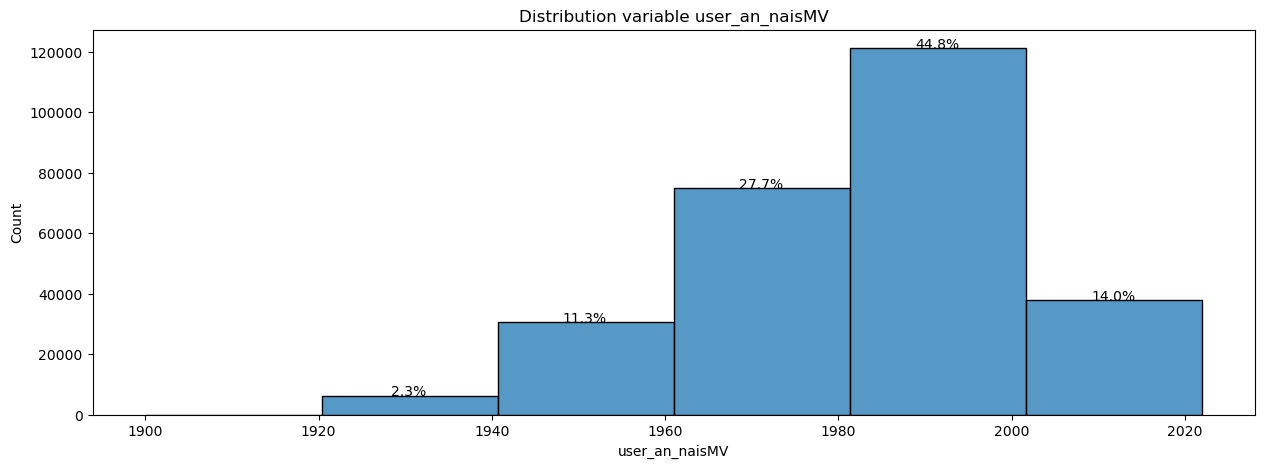


Test statistique ANOVA - PR(>F)=0.00000



,df,sum_sq,mean_sq,F,PR(>F)
user_an_naisMV,1.0,121.145335,121.145335,191.529816,1.525004e-43
Residual,270715.0,171231.091244,0.632514,NaN,NaN


Matrice de corrélation :  (coef=-0.027)


,user_an_naisMV,user_gravite
user_an_naisMV,1.000000,-0.026589
user_gravite,-0.026589,1.000000


Outliers=
-> Q1= 1970.0 - Q3= 1998.0 - IQR= 28.0 - Borne inf= 1928.0 - Borne sup= 2040.0
-> Outlier(s) inférieur(s) - min= 1900.0 - max= 1927.0 - nb= 245
[1900. 1900. 1900. 1900. 1900. 1900. 1900. 1900. 1900. 1900. 1900. 1900.
 1910. 1910. 1910. 1913. 1913. 1913. 1920. 1920. 1920. 1921. 1921. 1921.
 1921. 1922. 1922. 1922. 1922. 1923. 1923. 1923. 1923. 1923. 1923. 1923.
 1923. 1923. 1923. 1923. 1923. 1923. 1923. 1923. 1924. 1924. 1924. 1924.
 1924. 1924. 1924. 1924. 1924. 1924. 1924. 1924. 1924. 1924. 1924. 1924.
 1924. 1924. 1924. 1924. 1924. 1925. 1925. 1925. 1925. 1925. 1925. 1925.
 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925.
 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925.
 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1925. 1926. 1926.
 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926.
 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926. 1926.
 1926. 1926. 1926. 1926. 1926. 1926. 1926. 

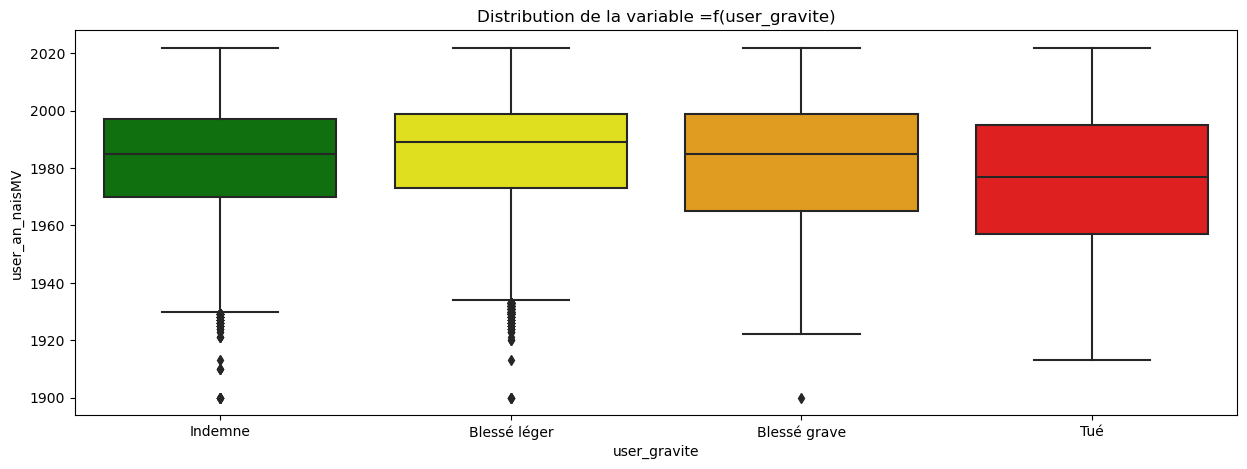

,user_an_nais,user_gravite
user_an_nais,1.000000,-0.012614
user_gravite,-0.012614,1.000000


In [273]:
# ----------------
# 'USER_AN_NAIS'
# ----------------

analyse_variable_quantitative(train, x='user_an_nais', bins=6, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# Répartition des valeurs
display(train.user_an_nais.value_counts())       

# Matrice de corrélation avec la variable cible
display(train[['user_an_nais', 'user_gravite']].corr())

modalite = train.user_an_nais.mode()[0]
train['user_an_naisMV'] = train.user_an_nais.fillna(modalite)
#train['user_an_naisMV'] = train.user_an_nais.replace(-1, train.user_an_nais.mode()[0])
analyse_variable_quantitative(train, x='user_an_naisMV', bins=6, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)
display(train[['user_an_nais', 'user_gravite']].corr())












                                                

<u>CONCLUSION :
- <span style="color:red">__'USER_AN_NAIS'__</span> :</u>
1. 1.6% de valeurs manquantes (4245)
2. Analyse des outliers : Il s'agit d'enregistrement en lien avec des personnes agées qui de fait se retrouvent marginal en nombre.
   Les valeurs ne sont pas anormales.
3. Reprise des missing values :
   - Reprise avec la modalité la plus fréquente améliore le coéf de corrélation
4. Le test statistique du ANOVA donne une p-value proche de 0%
5. Coef de corrélation
   - avec les missing values : -0.0126 : une légère corrélation négative semble exister entre les deux variables.
   - sans missing values : -0.027

  __==> APPLICATION REGLE DE MISE A JOUR DES MISSING VALUES__

  __<span style="color:red">==> LA VARIABLE SERA ECARTEE DU SCOPE DES VARIABLES EXPLICATIVES (TROP FAIBLE CORRELATION)__</span>

&#8195;


### &#8195;
<u> <span style="color:blue">ETAPE 7.5 - Variables Agrégées </span></u>
- <span style="color:red">__VEHI_OCCUTC__</span> : Nb de passager(s) transport en commun
- <span style="color:red">__AGG_NB_TOTAL_CONDUCTEUR__</span> : Nb total de conducteur(s)
- <span style="color:red">__AGG_NB_TOTAL_CONDUCTRICE__</span> : Nb total de conductrice(s)
- <span style="color:red">__AGG_NB_TOTAL_PIETON__</span> : Nb total de piéton(s)
- <span style="color:red">__AGG_NB_TOTAL_PASSAGER__</span> : Nb total de passager(s)
- <span style="color:red">__AGG_NB_PASSAGER_VEHICULE__</span> : Nb passager(s) associé(s) au véhicule
- <span style="color:red">__AGG_NB_PIETON_VEHICULE__</span> : Nb piéton(s) associé(s) au véhicule
- <span style="color:red">__AGG_NB_TOTAL_VA__</span> : Nb total de véhicule(s) autre(s)
- <span style="color:red">__AGG_NB_TOTAL_PL__</span> : Nb total de poids lourds
- <span style="color:red">__AGG_NB_TOTAL_VL__</span> : Nb total de véhicule(s) léger(s)
- <span style="color:red">__AGG_NB_TOTAL_MOTO__</span> : Nb total de motocyclette(s)
- <span style="color:red">__AGG_NB_TOTAL_VSP__</span> : Nb total de véhicule(s) sans permis
- <span style="color:red">__AGG_NB_TOTAL_VELO__</span> : Nb total de vélo(s)
- <span style="color:red">__AGG_NB_TOTAL_VEHICULE__</span> : Nb total de véhicule(s)
  


Il y a 0.0% (0) de données manquantes (ou assimilées).

Statistiques de la variable : 

count    270717.000000
mean          1.896974
std           0.835963
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max          20.000000
Name: agg_nb_total_vehicule, dtype: float64



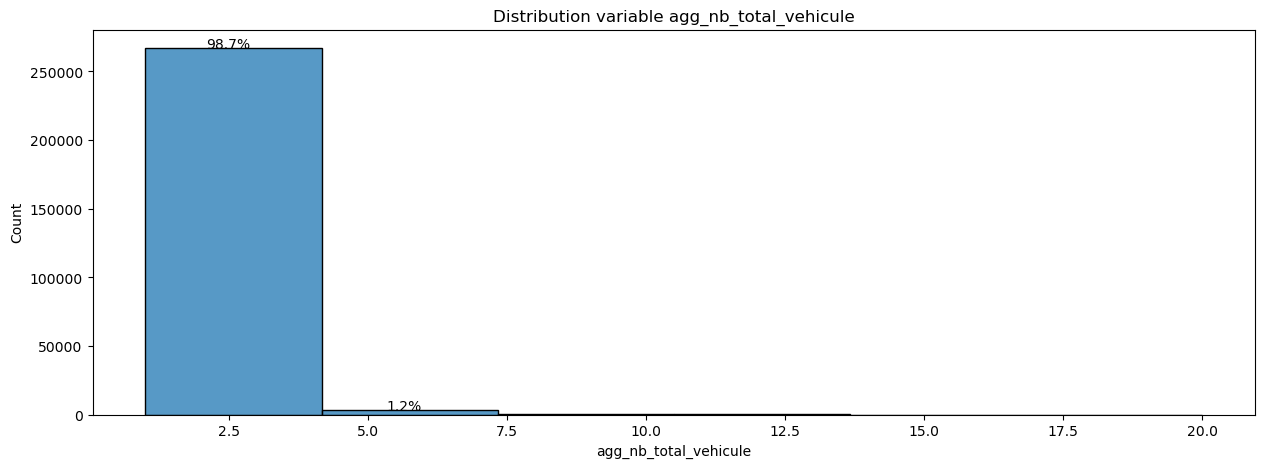


Test statistique ANOVA - PR(>F)=0.00000



,df,sum_sq,mean_sq,F,PR(>F)
agg_nb_total_vehicule,1.0,6134.053704,6134.053704,10050.832903,0.0
Residual,270715.0,165218.182875,0.610303,NaN,NaN


Matrice de corrélation :  (coef=-0.189)


,agg_nb_total_vehicule,user_gravite
agg_nb_total_vehicule,1.000000,-0.189203
user_gravite,-0.189203,1.000000


Outliers=
-> Q1= 1.0 - Q3= 2.0 - IQR= 1.0 - Borne inf= -0.5 - Borne sup= 3.5
-> Outlier(s) inférieur(s) - min= nan - max= nan - nb= 0
[]
-> Outlier(s) supérieur(s) - min= 4 - max= 20 Outliers nb= 9928
[ 4  4  4 ... 20 20 20]


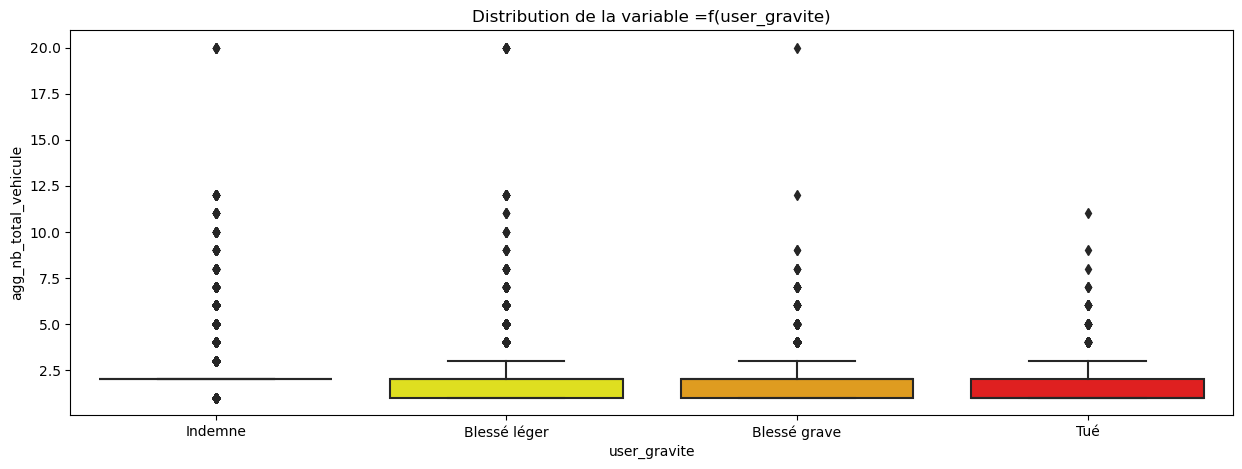

'\ncolonnes_a_inclure = [\'agg_nb_total_vehicule\', \n       \'agg_nb_total_vl\', \n       \'agg_nb_total_conducteur\', \n       \'agg_nb_total_conductrice\',\n       \'user_gravite\']\n\ndf_a_tracer = train[colonnes_a_inclure]\n\nplt.figure(figsize=(5, 5))\ndisplay("Matrice de corrélation:", df_a_tracer.corr())\nsns.heatmap(df_a_tracer.corr(), cmap=\'coolwarm\', annot=True, fmt=".2f", vmin=-1, vmax=1)\nplt.title("Matrice de corrélation des nb passagers");\n'

In [275]:
# -------------
# 'VEHI_OCCUTC'
# -------------
#analyse_variable_quantitative(train, x='vehi_occutc', bins=6, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# -------------------------
# 'AGG_NB_TOTAL_CONDUCTEUR'
# -------------------------
#analyse_variable_quantitative(train, x='agg_nb_total_conducteur', bins=30, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# -------------------------
# 'AGG_NB_TOTAL_CONDUCTRICE'
# -------------------------
#analyse_variable_quantitative(train, x='agg_nb_total_conductrice', bins=30, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# ---------------------
# 'AGG_NB_TOTAL_PIETON'
# ---------------------
#analyse_variable_quantitative(train, x='agg_nb_total_pieton', bins=30, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# -----------------------
# 'AGG_NB_TOTAL_PASSAGER'
# -----------------------
#analyse_variable_quantitative(train, x='agg_nb_total_passager', bins=30, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# --------------------------
# 'AGG_NB_PASSAGER_VEHICULE'
# --------------------------
#analyse_variable_quantitative(train, x='agg_nb_passager_vehicule', bins=30, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# ------------------------
# 'AGG_NB_PIETON_VEHICULE'
# ------------------------

#analyse_variable_quantitative(train, x='agg_nb_pieton_vehicule', bins=6, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# 'agg_nb_pieton_vehicule' - Analyse des Outliers
train[(train.agg_nb_pieton_vehicule > 15)]

# --> il existe bien des accidents avec de nombreux piétons (jusqu'à 17)


# -----------------
# 'AGG_NB_TOTAL_VA'
# -----------------
#analyse_variable_quantitative(train, x='agg_nb_total_va', bins=16, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# -----------------
# 'AGG_NB_TOTAL_PL'
# -----------------
#analyse_variable_quantitative(train, x='agg_nb_total_pl', bins=16, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# -----------------
# 'AGG_NB_TOTAL_VL'
# -----------------
#analyse_variable_quantitative(train, x='agg_nb_total_vl', bins=16, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# -------------------
# 'AGG_NB_TOTAL_MOTO'
# -------------------
#analyse_variable_quantitative(train, x='agg_nb_total_moto', bins=16, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# ------------------
# 'AGG_NB_TOTAL_VSP'
# ------------------
#analyse_variable_quantitative(train, x='agg_nb_total_vsp', bins=16, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# -------------------
# 'AGG_NB_TOTAL_VELO'
# -------------------
#analyse_variable_quantitative(train, x='agg_nb_total_velo', bins=16, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# -----------------------
# 'AGG_NB_TOTAL_VEHICULE'
# -----------------------
"""
analyse_variable_quantitative(train, x='agg_nb_total_vehicule', bins=6, cible='user_gravite', valna=-1, code_to_xlabel=code_to_xlabel)

# Analyse des Outliers : il existe bien des accidents impactant un nb de véhicule > 4
train[(train.agg_nb_total_vehicule > 4)]
"""

# ----------------------
# MATRICE DE CORRELATION
# ----------------------
# 2 Variables pourraient être retenues : à vérifier leur niveau
# de corrélation entre elles 
"""
colonnes_a_inclure = ['agg_nb_total_vehicule', 
       'agg_nb_total_vl', 
       'agg_nb_total_conducteur', 
       'agg_nb_total_conductrice',
       'user_gravite']

df_a_tracer = train[colonnes_a_inclure]

plt.figure(figsize=(5, 5))
display("Matrice de corrélation:", df_a_tracer.corr())
sns.heatmap(df_a_tracer.corr(), cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Matrice de corrélation des nb passagers");
"""
# --> Corrélation importante entre les deux VARIABLES EXPLICATIVES
# ==> On privilégiera celle avec la corrélation la plus forte avec la variable cible 


<u>CONCLUSIONS :
- <span style="color:red">__'VEHI_OCCUTC'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie, un accident a impacté 17 piétons
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation (sans rééquilibrage des données) :
   - sur df initial : indice=0.028

  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (CORRELATION TROP FAIBLE)__</span>
  
     
- <span style="color:red">__'AGG_NB_TOTAL_CONDUCTEUR'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie,
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation (sans rééquilibrage des données) :
   - sur df initial : indice=0.120
  
  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (RISQUE MULTI COLINEARITE)__</span>


- <span style="color:red">__'AGG_NB_TOTAL_CONDUCTRICE'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie,
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation (sans rééquilibrage des données) :
   - sur df initial : indice=0.086

  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (CORRELATION TROP FAIBLE)__</span>

- <span style="color:red">__'AGG_NB_TOTAL_PIETON'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie,
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation (sans rééquilibrage des données) :
   - sur df initial : indice=0.022

  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (CORRELATION TROP FAIBLE)__</span>
  
- <span style="color:red">__'AGG_NB_TOTAL_PASSAGER'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie,
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation (sans rééquilibrage des données) :
   - sur df initial : indice=0.056
  
  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (CORRELATION TROP FAIBLE)__</span>

- <span style="color:red">__'AGG_NB_PASSAGER_VEHICULE'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie,
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation (sans rééquilibrage des données) :
   - sur df initial : indice=0.028

  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (CORRELATION TROP FAIBLE)__</span>
   
- <span style="color:red">__'AGG_NB_PIETON_VEHICULE'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie,
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation (sans rééquilibrage des données) :
   - sur df initial : indice=

  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (CORRELATION TROP FAIBLE)__</span>

- <span style="color:red">__'AGG_NB_TOTAL_VA'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie, (un accident a impacté jusqu'à 20 véhicules)
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation est de :
   - df initial : coéf=0.002

  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (CORRELATION TROP FAIBLE)__</span>

- <span style="color:red">__'AGG_NB_TOTAL_PL'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie, (un accident a impacté jusqu'à 20 véhicules)
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation est de :
   - df initial : coéf=0.014

  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (CORRELATION TROP FAIBLE)__</span>

- <span style="color:red">__'AGG_NB_TOTAL_VL'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie, (un accident a impacté jusqu'à 20 véhicules)
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation est de :
   - df initial : coéf=0.153

  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (RISQUE MULTI COLINEARITE)__</span>

- <span style="color:red">__'AGG_NB_TOTAL_MOTO'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie, (un accident a impacté jusqu'à 20 véhicules)
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation est de :
   - df initial : coéf=0.028

  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (CORRELATION TROP FAIBLE)__</span>

- <span style="color:red">__'AGG_NB_TOTAL_VSP'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie, (un accident a impacté jusqu'à 20 véhicules)
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation est de :
   - df initial : coéf=0.014

  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (CORRELATION TROP FAIBLE)__</span>

- <span style="color:red">__'AGG_NB_TOTAL_VELO'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie, (un accident a impacté jusqu'à 20 véhicules)
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation est de :
   - df initial : coéf=0.018

  <span style="color:red">__==> LA VARIABLE SERA EXCLUE DU SCOPE DES VARIABLES EXPLICATIVES (CORRELATION TROP FAIBLE)__</span>

- <span style="color:red">__'AGG_NB_TOTAL_VEHICULE'__</span> :</u>
1. Aucune valeur manquante
2. Analyse des outliers : Aucune anomalie, (un accident a impacté jusqu'à 20 véhicules)
3. Le test statistique du ANOVA donne une p-value proche de 0%
4. Le coefficient de corrélation est de :
   - df initial : coéf=0.189

  __==> LA VARIABLE POURRA ETRE UTILISEE EN L'ETAT POUR AGG_NB_TOTAL_VEHICULE__


        
     

SYNTHESE - ANALYSE DE TEST_STAT

In [277]:
# Sauvegarde de notre dataframe test_stat
test_stat.to_csv(repDataConsolidees +"test_stat.csv", index=False, encoding='utf-8')


In [278]:
test_stat

,variable,categorielle,MV_class,pvalue,coef
0,carac_an,True,False,4.992114e-18,0.018611
1,carac_mois,True,False,1.307331e-54,0.035950
2,carac_jour,True,False,7.660670e-03,0.021553
3,carac_hrmn,True,False,7.451895e-195,0.168218
4,_date_accident,True,False,1.757866e-71,0.135216
5,_date_accident_int,True,False,1.757866e-71,0.135216
6,_jour_semaine,True,False,1.575871e-133,0.050257
7,_is_we,True,False,1.277684e-128,0.046878
8,carac_agg,True,False,0.000000e+00,0.167990
9,user_sexe,True,False,0.000000e+00,0.171549


In [213]:
# Détail variables catégorielles binaire
test_stat[test_stat.variable.isin (['agg_is_conductrice_vehicule', 'agg_is_conducteur_vehicule', 'carac_agg', 'user_sexe'])].sort_values(by='variable', ascending=True)
#test_stat[['agg_is_conductrice_vehicule', 'agg_is_conducteur_vehicule', 'carac_agg', 'user_sexe']].sort_values(by='variable', ascending=True)

,variable,categorielle,pvalue,coef
11,agg_is_conducteur_vehicule,True,1.010458e-285,0.069806
12,agg_is_conductrice_vehicule,True,1.075645e-279,0.069068
8,carac_agg,True,0.000000e+00,0.167990
9,user_sexe,True,0.000000e+00,0.171549


In [214]:
# Détail variables catégorielles non binaire
test_stat[test_stat.variable.isin (['agg_nb_total_conducteur', 'agg_nb_total_vehicule', 'user_sexe'])].sort_values(by='variable', ascending=True)
#test_stat[['agg_is_conductrice_vehicule', 'agg_is_conducteur_vehicule', 'carac_agg', 'user_sexe']].sort_values(by='variable', ascending=True)

,variable,categorielle,pvalue,coef
74,agg_nb_total_conducteur,False,0.0,-0.119405
73,agg_nb_total_vehicule,False,0.0,-0.189203
9,user_sexe,True,0.0,0.171549


In [280]:
# Suppression des doublons sur le nom de la variable afin de conserver la combinaison avec un coef le plus important
test_stat['coef_val_abs'] = test_stat.coef.apply(lambda valeur : abs(valeur))
test_stat.sort_values(by=['variable', 'coef_val_abs'], ascending=[False, False])
test_stat_agrege = test_stat.drop_duplicates(subset='variable', keep='first')

test_stat_agrege.sort_values (by=['coef_val_abs'], ascending=True)

,variable,categorielle,MV_class,pvalue,coef,coef_val_abs
70,lieu_lartpc,False,False,7.787955e-01,0.000000,0.000000
66,carac_gps_long,False,False,1.232692e-04,-0.007380,0.007380
72,user_an_nais,False,False,7.419693e-11,-0.012614,0.012614
85,agg_nb_total_vsp,False,False,7.639142e-14,-0.014369,0.014369
82,agg_nb_total_pl,False,False,1.094318e-14,-0.014852,0.014852
86,agg_nb_total_velo,False,False,4.329934e-21,-0.018112,0.018112
0,carac_an,True,False,4.992114e-18,0.018611,0.018611
80,agg_nb_pieton_vehicule,False,False,2.500128e-22,-0.018678,0.018678
2,carac_jour,True,False,7.660670e-03,0.021553,0.021553
50,vehi_senc,True,False,1.654542e-23,0.021854,0.021854


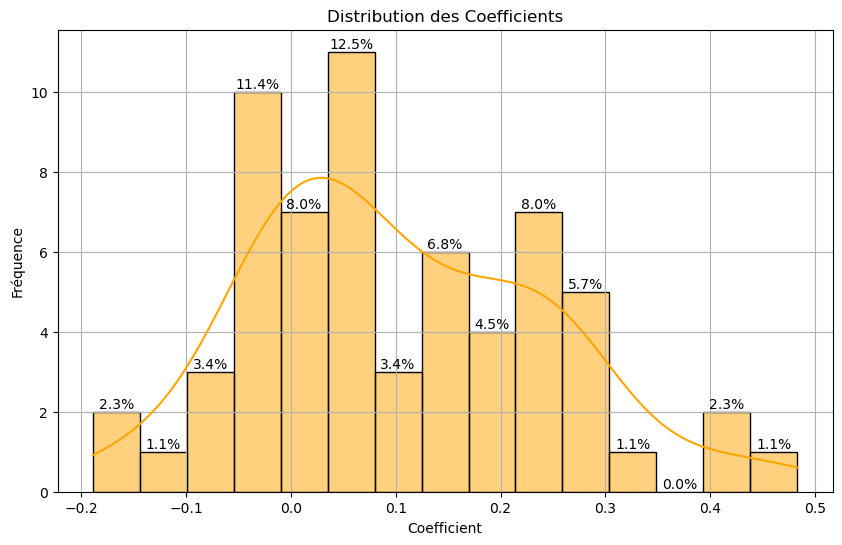

In [287]:
# Distribution de nos résultats de test

plt.figure(figsize=(10, 6))
ax = sns.histplot(test_stat_agrege['coef'], bins=15, kde=True, color='orange')

plt.title('Distribution des Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Fréquence')
plt.grid(True)

total = len(test_stat)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{(height / total * 100):.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()


In [ ]:

plt.title('Distribution des Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

In [290]:
test_stat_agrege

,variable,categorielle,MV_class,pvalue,coef,coef_val_abs
0,carac_an,True,False,4.992114e-18,0.018611,0.018611
1,carac_mois,True,False,1.307331e-54,0.035950,0.035950
2,carac_jour,True,False,7.660670e-03,0.021553,0.021553
3,carac_hrmn,True,False,7.451895e-195,0.168218,0.168218
4,_date_accident,True,False,1.757866e-71,0.135216,0.135216
5,_date_accident_int,True,False,1.757866e-71,0.135216,0.135216
6,_jour_semaine,True,False,1.575871e-133,0.050257,0.050257
7,_is_we,True,False,1.277684e-128,0.046878,0.046878
8,carac_agg,True,False,0.000000e+00,0.167990,0.167990
9,user_sexe,True,False,0.000000e+00,0.171549,0.171549


In [289]:
# Sauvegarde test_stat_agrege : il pourra servir ultérieurement pour identifier le seuil de sélection des variables
test_stat_agrege.to_csv(repDataConsolidees +"test_stat_agrege.csv", index=False, encoding='utf-8')


## ETAPE 8 - MATRICE DE CORRELATION

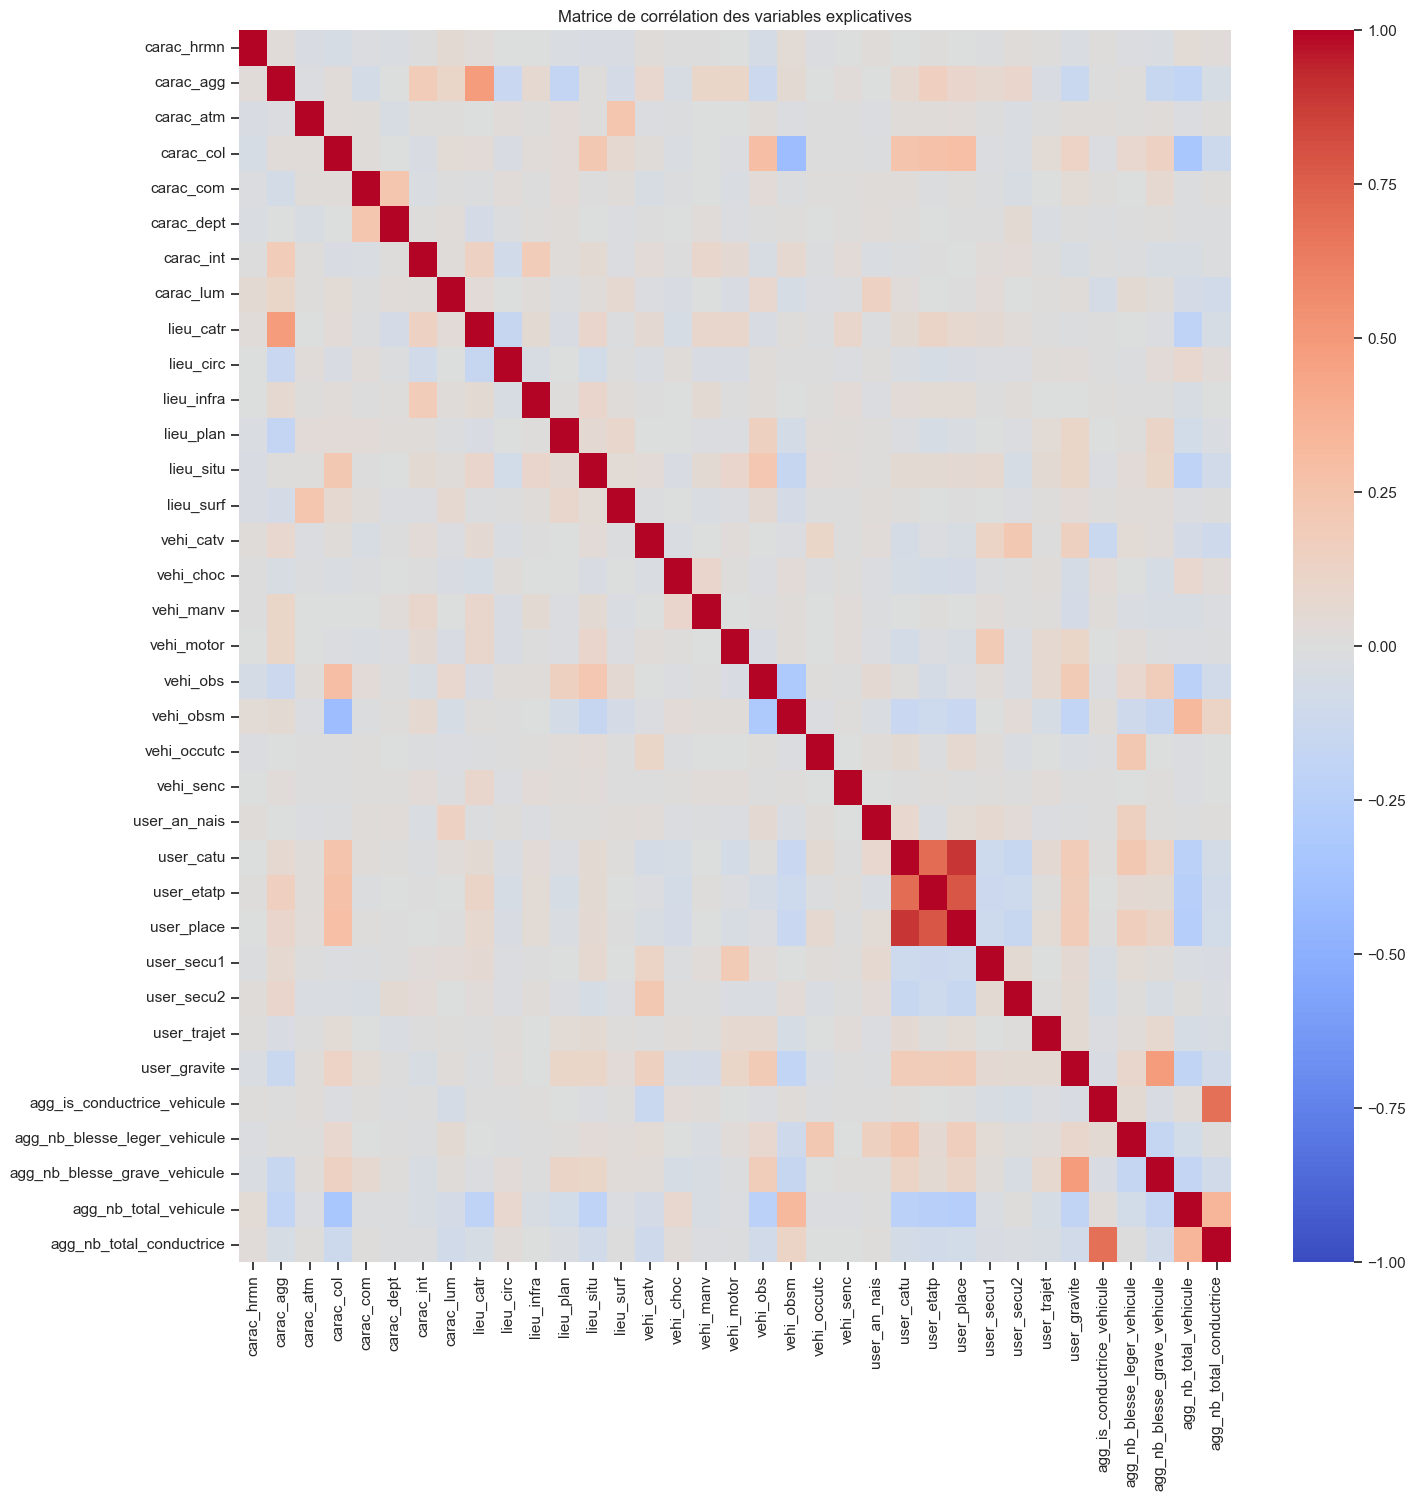

In [1205]:
# Recherche de corrélation entre les VARIABLES EXPLICATIVES : DataFrame=feature
colonnes_a_inclure = [colonne for colonne in train.columns if colonne not in ['id_accident',
                        'id_vehicule', 'num_veh', 'id_usager', 'carac_an', 'carac_mois', 'carac_jour',
                        'carac_adr', 'carac_gps', 'carac_gps_lat', 'carac_gps_long',
                        'lieu_env1', 'lieu_larrout', 'lieu_lartpc', 'lieu_nbv', 'lieu_pr',
                        'lieu_pr1', 'lieu_prof', 'lieu_v1', 'lieu_v2', 'lieu_vma', 'lieu_voie',
                        'lieu_vosp', 'vehi_occultc', 'user_secu3', 'user_sexe', 'agg_catv_perso',
                        'agg_is_velo', 'agg_is_vsp', 'agg_is_moto', 'agg_is_vl', 'agg_is_pl',
                        'agg_is_va', 'agg_is_conducteur_vehicule', 'agg_nb_pieton_vehicule',
                        'agg_nb_passager_vehicule', 'agg_nb_indemne_vehicule', 'agg_nb_blesse_vehicule',
                        'agg_nb_tue_vehicule', 'agg_nb_total_indemne', 'agg_nb_total_blesse',
                        'agg_nb_total_tue', 'agg_nb_total_velo', 'agg_nb_total_vsp', 'agg_nb_total_moto',
                        'agg_nb_total_vl', 'agg_nb_total_pl', 'agg_nb_total_va', 'agg_nb_total_conducteur',
                        'agg_nb_total_pieton', 'agg_nb_total_passager', 'user_etap', 'user_locp', 'user_actp'
]]

# Filtrer les chaînes se terminant par "MV" (colonnes de travail)
filtered_col_a_inclure = [col for col in colonnes_a_inclure if not col.endswith('MV')]


plt.figure(figsize=(16,16))
sns.heatmap(train[filtered_col_a_inclure].corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title("Matrice de corrélation des VARIABLES EXPLICATIVES");
plt.show();

# Peu de fortes corrélations entre les différentes features. 
# Cela confirme le résultat des tests statistiques


